In [2]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# colour palette
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
# Replace the color for 'ups' with a high contrast color
high_contrast_color = sns.color_palette("colorblind")[1]  # Example high contrast color
region_colors['ups'] = high_contrast_color

In [3]:
# Parameter selection
scenario_year = 2050

In [4]:
run_this_cell = True
if run_this_cell:
    # DISTANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    cable_capacity = 1200 # MW
    cable_voltage = 1100 # kV
    cable_resistivity = 0.01286 # ohms/km
    converter_losses = 0.015 # [-]
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for key, value in regions_dic.items():
        res_potential_dic[key] = {}
        res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=10, land_available=0.08)
        res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05) # MW
    
    # Normalizing of RENEWABLE PROFILES
    for key, value in regions_dic.items():
        normalizing_factor_wind = res_potential_dic[key]["wind"].max()
        normalizing_factor_pv = res_potential_dic[key]["pv"].max()
        res_potential_dic[key]['factor_wind'] = normalizing_factor_wind
        res_potential_dic[key]['factor_pv'] = normalizing_factor_pv
        res_potential_dic[key]["wind_normalized"] = res_potential_dic[key]["wind"] / normalizing_factor_wind
        res_potential_dic[key]["pv_normalized"] = res_potential_dic[key]["pv"] / normalizing_factor_pv

# Sensitivity analysis to increase global demand

In [5]:
np.linspace(8, 15, 15) / 10

array([0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 ,
       1.35, 1.4 , 1.45, 1.5 ])

In [6]:
demand_multiples = np.linspace(8, 15, 15) / 10
demand_global = {}
generation_global = {}
curtailment_global = {}
for demand_multiple in demand_multiples:    
    # SYNTHETIC -> excludes Europe
    path = "/Volumes/fi246disk/synde/resources/gegis/output"
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "north_america" and key != "europe" and key != "alaska":
            load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" ) * demand_multiple # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36 * demand_multiple
    load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", "ssp1-26")
    load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa * demand_multiple
    
    # Parameter selection
    cost_capacity_wind = 1
    cost_capacity_pv = 1
    cost_generation_wind = 100
    cost_generation_pv = 100
    cost_transmission = 1e-4
    cost_curtailment = 0

    # Initialise the network
    n = pypsa.Network() 
    snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
    n.set_snapshots(snapshots)

    # Loop over the dictionary to add the buses
    for key, value in regions_dic.items():
        n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
        
    # Loop over the dictionary to add the links 
    for key, value in links_dic.items():
        n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
        n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

    # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
    for key, value in res_potential_dic.items():
        n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
        n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
        n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

    # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
    for key, value in load_profile_dic.items():
        n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

    m = n.optimize.create_model();

    n.optimize(solver_name='gurobi')
    total_annual_wind = 0
    total_annual_pv = 0
    total_annual_load = 0
    total_annual_cur = 0
    for key, value in regions_dic.items(): # Annual (total) values
        for carrier in ["pv", "wind"]: 
            regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
            regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
        
        regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
        regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
        total_annual_wind += value["total_wind_yearly"]
        total_annual_pv += value["total_pv_yearly"]
        total_annual_load += value['total_load_yearly']
        total_annual_cur += value['total_curtailment_yearly']

    total_annual_gen = total_annual_wind + total_annual_pv
    wind_share = total_annual_wind / total_annual_gen
    pv_share = total_annual_pv / total_annual_gen

    # Store hourly losses for each link in dictionary
    for key, value in links_dic.items():
        p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
        p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
        abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
        p_trans = p0_0 + p0_1
        value["hourly_p_trans"] = p_trans
        value["hourly_abs_losses"] = abs_losses

    # Sum the transmission and losses of the links
    total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
    total_hourly_p_trans = pd.Series(0, index=n.snapshots)
    for key, value in links_dic.items():
        total_hourly_abs_losses += value["hourly_abs_losses"]
        total_hourly_p_trans += value["hourly_p_trans"]

    # Absolute losses
    total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
    total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
    total_annual_abs_losses = total_hourly_abs_losses.sum()

    # Power transmitted
    total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
    total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
    total_annual_p_trans = total_hourly_p_trans.sum()


    demand_global[demand_multiple] = total_annual_load
    generation_global[demand_multiple] = total_annual_gen
    curtailment_global[demand_multiple] = total_annual_cur



            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wg9wcvb7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wg9wcvb7.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb21fc769


INFO:gurobipy:Model fingerprint: 0xb21fc769


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.77869994e+15 -3.41765709e+15  3.65e+09 2.11e+02  9.68e+13     1s


INFO:gurobipy:   0   6.77869994e+15 -3.41765709e+15  3.65e+09 2.11e+02  9.68e+13     1s


   1   9.21114316e+15 -7.03823930e+15  6.55e+09 1.67e+04  6.80e+13     1s


INFO:gurobipy:   1   9.21114316e+15 -7.03823930e+15  6.55e+09 1.67e+04  6.80e+13     1s


   2   7.69043859e+15 -1.90506212e+16  5.63e+09 9.08e+03  4.07e+13     1s


INFO:gurobipy:   2   7.69043859e+15 -1.90506212e+16  5.63e+09 9.08e+03  4.07e+13     1s


   3   3.47898556e+15 -2.26682318e+16  2.52e+09 5.23e+03  2.26e+13     1s


INFO:gurobipy:   3   3.47898556e+15 -2.26682318e+16  2.52e+09 5.23e+03  2.26e+13     1s


   4   2.53083145e+15 -3.76736725e+16  1.66e+09 1.64e+03  1.04e+13     1s


INFO:gurobipy:   4   2.53083145e+15 -3.76736725e+16  1.66e+09 1.64e+03  1.04e+13     1s


   5   1.32923168e+15 -4.43083597e+16  7.40e+08 8.90e+02  5.23e+12     1s


INFO:gurobipy:   5   1.32923168e+15 -4.43083597e+16  7.40e+08 8.90e+02  5.23e+12     1s


   6   5.94436158e+14 -5.57660412e+16  2.69e+08 4.01e+02  2.10e+12     1s


INFO:gurobipy:   6   5.94436158e+14 -5.57660412e+16  2.69e+08 4.01e+02  2.10e+12     1s


   7   3.19274215e+14 -6.28908594e+16  1.01e+08 1.63e+02  8.50e+11     1s


INFO:gurobipy:   7   3.19274215e+14 -6.28908594e+16  1.01e+08 1.63e+02  8.50e+11     1s


   8   1.99764555e+14 -5.14664810e+16  2.99e+07 2.22e+01  2.57e+11     2s


INFO:gurobipy:   8   1.99764555e+14 -5.14664810e+16  2.99e+07 2.22e+01  2.57e+11     2s


   9   1.55536990e+14 -2.59791106e+16  3.80e+06 6.07e+00  6.79e+10     2s


INFO:gurobipy:   9   1.55536990e+14 -2.59791106e+16  3.80e+06 6.07e+00  6.79e+10     2s


  10   1.48970323e+14 -1.75325760e+15  0.00e+00 2.54e-01  4.20e+09     2s


INFO:gurobipy:  10   1.48970323e+14 -1.75325760e+15  0.00e+00 2.54e-01  4.20e+09     2s


  11   1.48414957e+14 -4.69471114e+13  0.00e+00 2.53e-02  4.31e+08     2s


INFO:gurobipy:  11   1.48414957e+14 -4.69471114e+13  0.00e+00 2.53e-02  4.31e+08     2s


  12   1.29473588e+14 -9.57245955e+12  0.00e+00 1.64e-02  3.05e+08     2s


INFO:gurobipy:  12   1.29473588e+14 -9.57245955e+12  0.00e+00 1.64e-02  3.05e+08     2s


  13   1.13003071e+14 -8.78361795e+12  0.00e+00 1.58e-02  2.67e+08     2s


INFO:gurobipy:  13   1.13003071e+14 -8.78361795e+12  0.00e+00 1.58e-02  2.67e+08     2s


  14   9.72338065e+13 -3.26400067e+12  0.00e+00 1.08e-02  2.20e+08     2s


INFO:gurobipy:  14   9.72338065e+13 -3.26400067e+12  0.00e+00 1.08e-02  2.20e+08     2s


  15   8.60301327e+13 -5.85026022e+12  0.00e+00 1.10e-02  2.01e+08     2s


INFO:gurobipy:  15   8.60301327e+13 -5.85026022e+12  0.00e+00 1.10e-02  2.01e+08     2s


  16   8.57690962e+13  1.93570835e+11  0.00e+00 9.86e-03  1.86e+08     2s


INFO:gurobipy:  16   8.57690962e+13  1.93570835e+11  0.00e+00 9.86e-03  1.86e+08     2s


  17   5.34510629e+13 -1.20987143e+11  0.00e+00 7.90e-03  1.16e+08     2s


INFO:gurobipy:  17   5.34510629e+13 -1.20987143e+11  0.00e+00 7.90e-03  1.16e+08     2s


  18   4.75964586e+13  6.62061511e+11  0.00e+00 3.60e-03  1.02e+08     2s


INFO:gurobipy:  18   4.75964586e+13  6.62061511e+11  0.00e+00 3.60e-03  1.02e+08     2s


  19   2.34832941e+13  2.38645736e+12  0.00e+00 5.37e-03  4.56e+07     2s


INFO:gurobipy:  19   2.34832941e+13  2.38645736e+12  0.00e+00 5.37e-03  4.56e+07     2s


  20   1.01783471e+13  3.36057878e+12  0.00e+00 3.87e-03  1.47e+07     2s


INFO:gurobipy:  20   1.01783471e+13  3.36057878e+12  0.00e+00 3.87e-03  1.47e+07     2s


  21   7.25296136e+12  3.86003629e+12  0.00e+00 4.01e-03  7.32e+06     3s


INFO:gurobipy:  21   7.25296136e+12  3.86003629e+12  0.00e+00 4.01e-03  7.32e+06     3s


  22   7.04038994e+12  3.94105880e+12  0.00e+00 4.52e-03  6.68e+06     3s


INFO:gurobipy:  22   7.04038994e+12  3.94105880e+12  0.00e+00 4.52e-03  6.68e+06     3s


  23   6.97503149e+12  3.99505899e+12  0.00e+00 4.81e-03  6.42e+06     3s


INFO:gurobipy:  23   6.97503149e+12  3.99505899e+12  0.00e+00 4.81e-03  6.42e+06     3s


  24   6.72926550e+12  4.13721726e+12  0.00e+00 5.87e-03  5.59e+06     3s


INFO:gurobipy:  24   6.72926550e+12  4.13721726e+12  0.00e+00 5.87e-03  5.59e+06     3s


  25   6.29118171e+12  4.24745526e+12  0.00e+00 6.42e-03  4.40e+06     3s


INFO:gurobipy:  25   6.29118171e+12  4.24745526e+12  0.00e+00 6.42e-03  4.40e+06     3s


  26   6.17411903e+12  4.48241393e+12  0.00e+00 5.13e-03  3.65e+06     3s


INFO:gurobipy:  26   6.17411903e+12  4.48241393e+12  0.00e+00 5.13e-03  3.65e+06     3s


  27   5.98668885e+12  4.79799879e+12  0.00e+00 3.25e-03  2.56e+06     3s


INFO:gurobipy:  27   5.98668885e+12  4.79799879e+12  0.00e+00 3.25e-03  2.56e+06     3s


  28   5.90448133e+12  5.02071603e+12  0.00e+00 2.84e-03  1.90e+06     3s


INFO:gurobipy:  28   5.90448133e+12  5.02071603e+12  0.00e+00 2.84e-03  1.90e+06     3s


  29   5.85690182e+12  5.20973335e+12  0.00e+00 2.41e-03  1.39e+06     3s


INFO:gurobipy:  29   5.85690182e+12  5.20973335e+12  0.00e+00 2.41e-03  1.39e+06     3s


  30   5.84819968e+12  5.36956786e+12  0.00e+00 1.80e-03  1.03e+06     3s


INFO:gurobipy:  30   5.84819968e+12  5.36956786e+12  0.00e+00 1.80e-03  1.03e+06     3s


  31   5.82062001e+12  5.42079240e+12  0.00e+00 1.62e-03  8.61e+05     3s


INFO:gurobipy:  31   5.82062001e+12  5.42079240e+12  0.00e+00 1.62e-03  8.61e+05     3s


  32   5.81735779e+12  5.55616171e+12  0.00e+00 1.08e-03  5.63e+05     3s


INFO:gurobipy:  32   5.81735779e+12  5.55616171e+12  0.00e+00 1.08e-03  5.63e+05     3s


  33   5.80012817e+12  5.61230646e+12  0.00e+00 8.55e-04  4.05e+05     3s


INFO:gurobipy:  33   5.80012817e+12  5.61230646e+12  0.00e+00 8.55e-04  4.05e+05     3s


  34   5.79944210e+12  5.64769741e+12  0.00e+00 7.01e-04  3.27e+05     4s


INFO:gurobipy:  34   5.79944210e+12  5.64769741e+12  0.00e+00 7.01e-04  3.27e+05     4s


  35   5.79049736e+12  5.74276989e+12  0.00e+00 2.60e-04  1.03e+05     4s


INFO:gurobipy:  35   5.79049736e+12  5.74276989e+12  0.00e+00 2.60e-04  1.03e+05     4s


  36   5.78205901e+12  5.75163640e+12  0.00e+00 1.96e-04  6.55e+04     4s


INFO:gurobipy:  36   5.78205901e+12  5.75163640e+12  0.00e+00 1.96e-04  6.55e+04     4s


  37   5.77921298e+12  5.76165721e+12  0.00e+00 1.15e-04  3.78e+04     4s


INFO:gurobipy:  37   5.77921298e+12  5.76165721e+12  0.00e+00 1.15e-04  3.78e+04     4s


  38   5.77816188e+12  5.77291273e+12  0.00e+00 2.25e-05  1.13e+04     4s


INFO:gurobipy:  38   5.77816188e+12  5.77291273e+12  0.00e+00 2.25e-05  1.13e+04     4s


  39   5.77769328e+12  5.77322301e+12  0.00e+00 2.03e-05  9.63e+03     4s


INFO:gurobipy:  39   5.77769328e+12  5.77322301e+12  0.00e+00 2.03e-05  9.63e+03     4s


  40   5.77707461e+12  5.77450457e+12  0.00e+00 1.16e-05  5.54e+03     4s


INFO:gurobipy:  40   5.77707461e+12  5.77450457e+12  0.00e+00 1.16e-05  5.54e+03     4s


  41   5.77662009e+12  5.77538953e+12  0.00e+00 6.29e-06  2.65e+03     4s


INFO:gurobipy:  41   5.77662009e+12  5.77538953e+12  0.00e+00 6.29e-06  2.65e+03     4s


  42   5.77658442e+12  5.77538975e+12  0.00e+00 6.26e-06  2.57e+03     4s


INFO:gurobipy:  42   5.77658442e+12  5.77538975e+12  0.00e+00 6.26e-06  2.57e+03     4s


  43   5.77655183e+12  5.77548929e+12  0.00e+00 5.53e-06  2.29e+03     5s


INFO:gurobipy:  43   5.77655183e+12  5.77548929e+12  0.00e+00 5.53e-06  2.29e+03     5s


  44   5.77636526e+12  5.77591528e+12  0.00e+00 2.14e-06  9.69e+02     5s


INFO:gurobipy:  44   5.77636526e+12  5.77591528e+12  0.00e+00 2.14e-06  9.69e+02     5s


  45   5.77633496e+12  5.77614831e+12  0.00e+00 1.07e-06  4.02e+02     5s


INFO:gurobipy:  45   5.77633496e+12  5.77614831e+12  0.00e+00 1.07e-06  4.02e+02     5s


  46   5.77625701e+12  5.77617063e+12  0.00e+00 3.13e-06  1.85e+02     5s


INFO:gurobipy:  46   5.77625701e+12  5.77617063e+12  0.00e+00 3.13e-06  1.85e+02     5s


  47   5.77621723e+12  5.77617494e+12  0.00e+00 3.07e-06  8.96e+01     5s


INFO:gurobipy:  47   5.77621723e+12  5.77617494e+12  0.00e+00 3.07e-06  8.96e+01     5s


  48   5.77619152e+12  5.77617761e+12  0.00e+00 3.10e-06  2.86e+01     5s


INFO:gurobipy:  48   5.77619152e+12  5.77617761e+12  0.00e+00 3.10e-06  2.86e+01     5s


  49   5.77618605e+12  5.77617885e+12  0.00e+00 2.83e-06  1.42e+01     5s


INFO:gurobipy:  49   5.77618605e+12  5.77617885e+12  0.00e+00 2.83e-06  1.42e+01     5s


  50   5.77618238e+12  5.77617927e+12  0.00e+00 2.72e-06  5.51e+00     6s


INFO:gurobipy:  50   5.77618238e+12  5.77617927e+12  0.00e+00 2.72e-06  5.51e+00     6s


  51   5.77618137e+12  5.77617942e+12  0.00e+00 2.70e-06  3.10e+00     6s


INFO:gurobipy:  51   5.77618137e+12  5.77617942e+12  0.00e+00 2.70e-06  3.10e+00     6s


  52   5.77618085e+12  5.77617956e+12  0.00e+00 2.72e-06  1.75e+00     6s


INFO:gurobipy:  52   5.77618085e+12  5.77617956e+12  0.00e+00 2.72e-06  1.75e+00     6s


  53   5.77618048e+12  5.77617960e+12  0.00e+00 2.72e-06  9.17e-01     6s


INFO:gurobipy:  53   5.77618048e+12  5.77617960e+12  0.00e+00 2.72e-06  9.17e-01     6s


  54   5.77618029e+12  5.77617962e+12  0.00e+00 2.66e-06  5.24e-01     6s


INFO:gurobipy:  54   5.77618029e+12  5.77617962e+12  0.00e+00 2.66e-06  5.24e-01     6s


  55   5.77618023e+12  5.77617963e+12  0.00e+00 2.44e-06  3.93e-01     6s


INFO:gurobipy:  55   5.77618023e+12  5.77617963e+12  0.00e+00 2.44e-06  3.93e-01     6s


  56   5.77618018e+12  5.77617963e+12  0.00e+00 2.47e-06  3.14e-01     7s


INFO:gurobipy:  56   5.77618018e+12  5.77617963e+12  0.00e+00 2.47e-06  3.14e-01     7s


  57   5.77618013e+12  5.77617963e+12  0.00e+00 2.56e-06  2.21e-01     7s


INFO:gurobipy:  57   5.77618013e+12  5.77617963e+12  0.00e+00 2.56e-06  2.21e-01     7s


  58   5.77618009e+12  5.77617964e+12  0.00e+00 2.60e-06  1.41e-01     7s


INFO:gurobipy:  58   5.77618009e+12  5.77617964e+12  0.00e+00 2.60e-06  1.41e-01     7s


  59   5.77618007e+12  5.77617964e+12  0.00e+00 2.48e-06  1.06e-01     7s


INFO:gurobipy:  59   5.77618007e+12  5.77617964e+12  0.00e+00 2.48e-06  1.06e-01     7s


INFO:gurobipy:


Barrier solved model in 59 iterations and 7.08 seconds (9.59 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 7.08 seconds (9.59 work units)


Optimal objective 5.77618007e+12


INFO:gurobipy:Optimal objective 5.77618007e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11255 DPushes remaining with DInf 2.7726278e-02                10s


INFO:gurobipy:   11255 DPushes remaining with DInf 2.7726278e-02                10s


    2668 DPushes remaining with DInf 3.5700237e-02                10s


INFO:gurobipy:    2668 DPushes remaining with DInf 3.5700237e-02                10s


       0 DPushes remaining with DInf 3.8105808e-02                10s


INFO:gurobipy:       0 DPushes remaining with DInf 3.8105808e-02                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  101255 PPushes remaining with PInf 6.4125497e-06                10s


INFO:gurobipy:  101255 PPushes remaining with PInf 6.4125497e-06                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6278604e-01     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6278604e-01     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  111111    5.7761803e+12   0.000000e+00   9.627860e-01     11s


INFO:gurobipy:  111111    5.7761803e+12   0.000000e+00   9.627860e-01     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 384


INFO:gurobipy:Extra simplex iterations after uncrush: 384


  153264    5.7761797e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  153264    5.7761797e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 153264 iterations and 14.20 seconds (23.06 work units)


INFO:gurobipy:Solved in 153264 iterations and 14.20 seconds (23.06 work units)


Optimal objective  5.776179681e+12


INFO:gurobipy:Optimal objective  5.776179681e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.78e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
INFO:linopy.io: Writing time: 4.52s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jbe3b_a0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jbe3b_a0.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x77a092da


INFO:gurobipy:Model fingerprint: 0x77a092da


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.98764395e+15 -3.41744376e+15  3.76e+09 2.11e+02  9.98e+13     1s


INFO:gurobipy:   0   6.98764395e+15 -3.41744376e+15  3.76e+09 2.11e+02  9.98e+13     1s


   1   9.49455942e+15 -7.09984160e+15  6.75e+09 1.67e+04  6.99e+13     1s


INFO:gurobipy:   1   9.49455942e+15 -7.09984160e+15  6.75e+09 1.67e+04  6.99e+13     1s


   2   7.88906417e+15 -1.91858393e+16  5.80e+09 8.96e+03  4.15e+13     1s


INFO:gurobipy:   2   7.88906417e+15 -1.91858393e+16  5.80e+09 8.96e+03  4.15e+13     1s


   3   3.54900626e+15 -2.27105150e+16  2.60e+09 5.15e+03  2.23e+13     1s


INFO:gurobipy:   3   3.54900626e+15 -2.27105150e+16  2.60e+09 5.15e+03  2.23e+13     1s


   4   2.46505315e+15 -3.29155581e+16  1.59e+09 1.88e+03  1.04e+13     1s


INFO:gurobipy:   4   2.46505315e+15 -3.29155581e+16  1.59e+09 1.88e+03  1.04e+13     1s


   5   1.30198982e+15 -4.17052495e+16  7.27e+08 9.42e+02  5.17e+12     1s


INFO:gurobipy:   5   1.30198982e+15 -4.17052495e+16  7.27e+08 9.42e+02  5.17e+12     1s


   6   6.14937154e+14 -5.48790915e+16  2.83e+08 3.59e+02  2.10e+12     1s


INFO:gurobipy:   6   6.14937154e+14 -5.48790915e+16  2.83e+08 3.59e+02  2.10e+12     1s


   7   3.47215769e+14 -6.10642520e+16  1.19e+08 1.54e+02  9.26e+11     1s


INFO:gurobipy:   7   3.47215769e+14 -6.10642520e+16  1.19e+08 1.54e+02  9.26e+11     1s


   8   2.14024771e+14 -5.21163561e+16  3.88e+07 2.19e+01  3.01e+11     2s


INFO:gurobipy:   8   2.14024771e+14 -5.21163561e+16  3.88e+07 2.19e+01  3.01e+11     2s


   9   1.77638490e+14 -3.14807734e+16  1.72e+07 7.30e+00  1.20e+11     2s


INFO:gurobipy:   9   1.77638490e+14 -3.14807734e+16  1.72e+07 7.30e+00  1.20e+11     2s


  10   1.48663858e+14 -1.14337242e+16  2.93e+04 1.57e+00  2.56e+10     2s


INFO:gurobipy:  10   1.48663858e+14 -1.14337242e+16  2.93e+04 1.57e+00  2.56e+10     2s


  11   1.48430574e+14 -4.35194341e+13  0.00e+00 2.60e-02  4.23e+08     2s


INFO:gurobipy:  11   1.48430574e+14 -4.35194341e+13  0.00e+00 2.60e-02  4.23e+08     2s


  12   1.36363066e+14 -8.31855928e+13  0.00e+00 1.85e-02  4.79e+08     2s


INFO:gurobipy:  12   1.36363066e+14 -8.31855928e+13  0.00e+00 1.85e-02  4.79e+08     2s


  13   1.27870901e+14 -2.95592088e+13  0.00e+00 1.29e-02  3.43e+08     2s


INFO:gurobipy:  13   1.27870901e+14 -2.95592088e+13  0.00e+00 1.29e-02  3.43e+08     2s


  14   1.16262744e+14 -3.43015113e+13  0.00e+00 1.25e-02  3.27e+08     2s


INFO:gurobipy:  14   1.16262744e+14 -3.43015113e+13  0.00e+00 1.25e-02  3.27e+08     2s


  15   1.13070511e+14 -2.51035317e+13  0.00e+00 8.56e-03  2.99e+08     2s


INFO:gurobipy:  15   1.13070511e+14 -2.51035317e+13  0.00e+00 8.56e-03  2.99e+08     2s


  16   1.01281860e+14 -1.45313444e+13  0.00e+00 7.10e-03  2.51e+08     2s


INFO:gurobipy:  16   1.01281860e+14 -1.45313444e+13  0.00e+00 7.10e-03  2.51e+08     2s


  17   8.38151901e+13 -1.00374042e+13  0.00e+00 5.21e-03  2.03e+08     2s


INFO:gurobipy:  17   8.38151901e+13 -1.00374042e+13  0.00e+00 5.21e-03  2.03e+08     2s


  18   6.51612726e+13 -7.53386073e+12  0.00e+00 4.20e-03  1.57e+08     2s


INFO:gurobipy:  18   6.51612726e+13 -7.53386073e+12  0.00e+00 4.20e-03  1.57e+08     2s


  19   3.63991342e+13 -3.78646110e+12  0.00e+00 6.63e-03  8.68e+07     2s


INFO:gurobipy:  19   3.63991342e+13 -3.78646110e+12  0.00e+00 6.63e-03  8.68e+07     2s


  20   2.79770864e+13  2.04203615e+12  0.00e+00 6.89e-03  5.59e+07     3s


INFO:gurobipy:  20   2.79770864e+13  2.04203615e+12  0.00e+00 6.89e-03  5.59e+07     3s


  21   1.75143004e+13  2.48774161e+12  0.00e+00 6.46e-03  3.24e+07     3s


INFO:gurobipy:  21   1.75143004e+13  2.48774161e+12  0.00e+00 6.46e-03  3.24e+07     3s


  22   1.56789766e+13  4.12484172e+12  0.00e+00 5.44e-03  2.49e+07     3s


INFO:gurobipy:  22   1.56789766e+13  4.12484172e+12  0.00e+00 5.44e-03  2.49e+07     3s


  23   7.81204581e+12  4.56212823e+12  0.00e+00 3.29e-03  7.00e+06     3s


INFO:gurobipy:  23   7.81204581e+12  4.56212823e+12  0.00e+00 3.29e-03  7.00e+06     3s


  24   7.08906620e+12  4.68770562e+12  0.00e+00 2.30e-03  5.17e+06     3s


INFO:gurobipy:  24   7.08906620e+12  4.68770562e+12  0.00e+00 2.30e-03  5.17e+06     3s


  25   6.85668216e+12  4.76635480e+12  0.00e+00 2.02e-03  4.50e+06     3s


INFO:gurobipy:  25   6.85668216e+12  4.76635480e+12  0.00e+00 2.02e-03  4.50e+06     3s


  26   6.59242524e+12  4.90737279e+12  0.00e+00 1.49e-03  3.63e+06     3s


INFO:gurobipy:  26   6.59242524e+12  4.90737279e+12  0.00e+00 1.49e-03  3.63e+06     3s


  27   6.37438298e+12  5.11181626e+12  0.00e+00 1.08e-03  2.72e+06     3s


INFO:gurobipy:  27   6.37438298e+12  5.11181626e+12  0.00e+00 1.08e-03  2.72e+06     3s


  28   6.25833207e+12  5.36862931e+12  0.00e+00 6.12e-04  1.92e+06     4s


INFO:gurobipy:  28   6.25833207e+12  5.36862931e+12  0.00e+00 6.12e-04  1.92e+06     4s


  29   6.18968878e+12  5.59336046e+12  0.00e+00 3.63e-04  1.28e+06     4s


INFO:gurobipy:  29   6.18968878e+12  5.59336046e+12  0.00e+00 3.63e-04  1.28e+06     4s


  30   6.17076257e+12  5.73893808e+12  0.00e+00 2.49e-04  9.30e+05     4s


INFO:gurobipy:  30   6.17076257e+12  5.73893808e+12  0.00e+00 2.49e-04  9.30e+05     4s


  31   6.13718570e+12  5.76475584e+12  0.00e+00 2.33e-04  8.02e+05     4s


INFO:gurobipy:  31   6.13718570e+12  5.76475584e+12  0.00e+00 2.33e-04  8.02e+05     4s


  32   6.13044122e+12  5.95072996e+12  0.00e+00 1.14e-04  3.87e+05     4s


INFO:gurobipy:  32   6.13044122e+12  5.95072996e+12  0.00e+00 1.14e-04  3.87e+05     4s


  33   6.12530216e+12  6.09856515e+12  0.00e+00 1.55e-05  5.76e+04     5s


INFO:gurobipy:  33   6.12530216e+12  6.09856515e+12  0.00e+00 1.55e-05  5.76e+04     5s


  34   6.11952493e+12  6.10748032e+12  0.00e+00 8.92e-06  2.59e+04     5s


INFO:gurobipy:  34   6.11952493e+12  6.10748032e+12  0.00e+00 8.92e-06  2.59e+04     5s


  35   6.11835960e+12  6.11188302e+12  0.00e+00 5.28e-06  1.40e+04     5s


INFO:gurobipy:  35   6.11835960e+12  6.11188302e+12  0.00e+00 5.28e-06  1.40e+04     5s


  36   6.11820531e+12  6.11521996e+12  0.00e+00 2.21e-06  6.43e+03     5s


INFO:gurobipy:  36   6.11820531e+12  6.11521996e+12  0.00e+00 2.21e-06  6.43e+03     5s


  37   6.11753229e+12  6.11547036e+12  0.00e+00 1.95e-06  4.44e+03     5s


INFO:gurobipy:  37   6.11753229e+12  6.11547036e+12  0.00e+00 1.95e-06  4.44e+03     5s


  38   6.11745883e+12  6.11559505e+12  0.00e+00 1.81e-06  4.02e+03     5s


INFO:gurobipy:  38   6.11745883e+12  6.11559505e+12  0.00e+00 1.81e-06  4.02e+03     5s


  39   6.11712512e+12  6.11703222e+12  0.00e+00 5.65e-07  2.00e+02     6s


INFO:gurobipy:  39   6.11712512e+12  6.11703222e+12  0.00e+00 5.65e-07  2.00e+02     6s


  40   6.11710773e+12  6.11708368e+12  0.00e+00 3.53e-06  5.09e+01     6s


INFO:gurobipy:  40   6.11710773e+12  6.11708368e+12  0.00e+00 3.53e-06  5.09e+01     6s


  41   6.11710261e+12  6.11709034e+12  0.00e+00 3.36e-06  2.51e+01     6s


INFO:gurobipy:  41   6.11710261e+12  6.11709034e+12  0.00e+00 3.36e-06  2.51e+01     6s


  42   6.11709887e+12  6.11709251e+12  0.00e+00 3.52e-06  1.23e+01     6s


INFO:gurobipy:  42   6.11709887e+12  6.11709251e+12  0.00e+00 3.52e-06  1.23e+01     6s


  43   6.11709704e+12  6.11709330e+12  0.00e+00 3.04e-06  6.79e+00     6s


INFO:gurobipy:  43   6.11709704e+12  6.11709330e+12  0.00e+00 3.04e-06  6.79e+00     6s


  44   6.11709583e+12  6.11709360e+12  0.00e+00 2.82e-06  3.65e+00     6s


INFO:gurobipy:  44   6.11709583e+12  6.11709360e+12  0.00e+00 2.82e-06  3.65e+00     6s


  45   6.11709516e+12  6.11709393e+12  0.00e+00 2.73e-06  1.62e+00     6s


INFO:gurobipy:  45   6.11709516e+12  6.11709393e+12  0.00e+00 2.73e-06  1.62e+00     6s


  46   6.11709484e+12  6.11709405e+12  0.00e+00 2.68e-06  7.60e-01     7s


INFO:gurobipy:  46   6.11709484e+12  6.11709405e+12  0.00e+00 2.68e-06  7.60e-01     7s


  47   6.11709467e+12  6.11709409e+12  0.00e+00 2.69e-06  3.81e-01     7s


INFO:gurobipy:  47   6.11709467e+12  6.11709409e+12  0.00e+00 2.69e-06  3.81e-01     7s


  48   6.11709462e+12  6.11709410e+12  0.00e+00 2.65e-06  3.00e-01     7s


INFO:gurobipy:  48   6.11709462e+12  6.11709410e+12  0.00e+00 2.65e-06  3.00e-01     7s


  49   6.11709459e+12  6.11709410e+12  0.00e+00 2.50e-06  2.33e-01     7s


INFO:gurobipy:  49   6.11709459e+12  6.11709410e+12  0.00e+00 2.50e-06  2.33e-01     7s


  50   6.11709457e+12  6.11709411e+12  0.00e+00 2.49e-06  2.07e-01     7s


INFO:gurobipy:  50   6.11709457e+12  6.11709411e+12  0.00e+00 2.49e-06  2.07e-01     7s


  51   6.11709456e+12  6.11709411e+12  0.00e+00 2.50e-06  1.80e-01     7s


INFO:gurobipy:  51   6.11709456e+12  6.11709411e+12  0.00e+00 2.50e-06  1.80e-01     7s


  52   6.11709454e+12  6.11709411e+12  0.00e+00 2.53e-06  1.53e-01     8s


INFO:gurobipy:  52   6.11709454e+12  6.11709411e+12  0.00e+00 2.53e-06  1.53e-01     8s


  53   6.11709452e+12  6.11709411e+12  0.00e+00 2.60e-06  1.29e-01     8s


INFO:gurobipy:  53   6.11709452e+12  6.11709411e+12  0.00e+00 2.60e-06  1.29e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.71 seconds (10.44 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.71 seconds (10.44 work units)


Optimal objective 6.11709452e+12


INFO:gurobipy:Optimal objective 6.11709452e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11703 DPushes remaining with DInf 2.9568831e-02                11s


INFO:gurobipy:   11703 DPushes remaining with DInf 2.9568831e-02                11s


       0 DPushes remaining with DInf 2.1761286e+02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 2.1761286e+02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  101092 PPushes remaining with PInf 4.6094486e-06                11s


INFO:gurobipy:  101092 PPushes remaining with PInf 4.6094486e-06                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8267585e-01     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8267585e-01     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  111190    6.1170948e+12   0.000000e+00   9.826758e-01     12s


INFO:gurobipy:  111190    6.1170948e+12   0.000000e+00   9.826758e-01     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  154472    6.1170942e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  154472    6.1170942e+12   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 379


INFO:gurobipy:Extra simplex iterations after uncrush: 379


INFO:gurobipy:


Solved in 154472 iterations and 15.10 seconds (24.27 work units)


INFO:gurobipy:Solved in 154472 iterations and 15.10 seconds (24.27 work units)


Optimal objective  6.117094164e+12


INFO:gurobipy:Optimal objective  6.117094164e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 6.12e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mi6lmd53.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mi6lmd53.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xc13479ae


INFO:gurobipy:Model fingerprint: 0xc13479ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19056235e+15 -3.41723043e+15  3.90e+09 2.11e+02  1.03e+14     1s


INFO:gurobipy:   0   7.19056235e+15 -3.41723043e+15  3.90e+09 2.11e+02  1.03e+14     1s


   1   9.76980022e+15 -7.15611467e+15  6.95e+09 1.67e+04  7.17e+13     1s


INFO:gurobipy:   1   9.76980022e+15 -7.15611467e+15  6.95e+09 1.67e+04  7.17e+13     1s


   2   8.07957737e+15 -1.93075842e+16  5.96e+09 8.84e+03  4.23e+13     1s


INFO:gurobipy:   2   8.07957737e+15 -1.93075842e+16  5.96e+09 8.84e+03  4.23e+13     1s


   3   3.67670670e+15 -2.27430968e+16  2.68e+09 5.06e+03  2.27e+13     1s


INFO:gurobipy:   3   3.67670670e+15 -2.27430968e+16  2.68e+09 5.06e+03  2.27e+13     1s


   4   2.62349113e+15 -3.14769755e+16  1.71e+09 1.90e+03  1.09e+13     1s


INFO:gurobipy:   4   2.62349113e+15 -3.14769755e+16  1.71e+09 1.90e+03  1.09e+13     1s


   5   1.38030387e+15 -3.80135831e+16  7.80e+08 9.68e+02  5.31e+12     1s


INFO:gurobipy:   5   1.38030387e+15 -3.80135831e+16  7.80e+08 9.68e+02  5.31e+12     1s


   6   6.95651427e+14 -5.43704456e+16  3.34e+08 3.42e+02  2.34e+12     1s


INFO:gurobipy:   6   6.95651427e+14 -5.43704456e+16  3.34e+08 3.42e+02  2.34e+12     1s


   7   3.74155314e+14 -5.99351029e+16  1.36e+08 1.60e+02  1.01e+12     1s


INFO:gurobipy:   7   3.74155314e+14 -5.99351029e+16  1.36e+08 1.60e+02  1.01e+12     1s


   8   2.24799430e+14 -5.33836571e+16  4.55e+07 2.38e+01  3.40e+11     2s


INFO:gurobipy:   8   2.24799430e+14 -5.33836571e+16  4.55e+07 2.38e+01  3.40e+11     2s


   9   1.72966191e+14 -3.33925952e+16  1.46e+07 7.79e+00  1.19e+11     2s


INFO:gurobipy:   9   1.72966191e+14 -3.33925952e+16  1.46e+07 7.79e+00  1.19e+11     2s


  10   1.48443114e+14 -9.33263295e+15  0.00e+00 1.19e+00  2.09e+10     2s


INFO:gurobipy:  10   1.48443114e+14 -9.33263295e+15  0.00e+00 1.19e+00  2.09e+10     2s


  11   1.48262835e+14 -4.32124100e+13  0.00e+00 2.39e-02  4.21e+08     2s


INFO:gurobipy:  11   1.48262835e+14 -4.32124100e+13  0.00e+00 2.39e-02  4.21e+08     2s


  12   1.36097383e+14 -5.67902158e+13  0.00e+00 1.45e-02  4.20e+08     2s


INFO:gurobipy:  12   1.36097383e+14 -5.67902158e+13  0.00e+00 1.45e-02  4.20e+08     2s


  13   1.28802578e+14 -2.74529804e+13  0.00e+00 1.02e-02  3.39e+08     2s


INFO:gurobipy:  13   1.28802578e+14 -2.74529804e+13  0.00e+00 1.02e-02  3.39e+08     2s


  14   1.14211315e+14 -2.43823917e+13  0.00e+00 9.57e-03  3.00e+08     2s


INFO:gurobipy:  14   1.14211315e+14 -2.43823917e+13  0.00e+00 9.57e-03  3.00e+08     2s


  15   1.13098606e+14 -1.83892606e+13  0.00e+00 7.14e-03  2.85e+08     2s


INFO:gurobipy:  15   1.13098606e+14 -1.83892606e+13  0.00e+00 7.14e-03  2.85e+08     2s


  16   7.53323878e+13 -1.48058988e+13  0.00e+00 4.77e-03  1.95e+08     2s


INFO:gurobipy:  16   7.53323878e+13 -1.48058988e+13  0.00e+00 4.77e-03  1.95e+08     2s


  17   3.66922096e+13 -6.55523799e+12  0.00e+00 2.42e-03  9.34e+07     2s


INFO:gurobipy:  17   3.66922096e+13 -6.55523799e+12  0.00e+00 2.42e-03  9.34e+07     2s


  18   3.48616799e+13 -1.49000945e+12  0.00e+00 5.22e-03  7.84e+07     2s


INFO:gurobipy:  18   3.48616799e+13 -1.49000945e+12  0.00e+00 5.22e-03  7.84e+07     2s


  19   2.83151954e+13  1.92123997e+12  0.00e+00 9.08e-03  5.69e+07     2s


INFO:gurobipy:  19   2.83151954e+13  1.92123997e+12  0.00e+00 9.08e-03  5.69e+07     2s


  20   2.03148429e+13  2.36216196e+12  0.00e+00 8.09e-03  3.87e+07     2s


INFO:gurobipy:  20   2.03148429e+13  2.36216196e+12  0.00e+00 8.09e-03  3.87e+07     2s


  21   1.26141663e+13  3.83498132e+12  0.00e+00 6.98e-03  1.89e+07     3s


INFO:gurobipy:  21   1.26141663e+13  3.83498132e+12  0.00e+00 6.98e-03  1.89e+07     3s


  22   8.20144427e+12  4.81781644e+12  0.00e+00 4.22e-03  7.28e+06     3s


INFO:gurobipy:  22   8.20144427e+12  4.81781644e+12  0.00e+00 4.22e-03  7.28e+06     3s


  23   7.74638936e+12  4.94279817e+12  0.00e+00 4.06e-03  6.03e+06     3s


INFO:gurobipy:  23   7.74638936e+12  4.94279817e+12  0.00e+00 4.06e-03  6.03e+06     3s


  24   7.40583718e+12  5.05379557e+12  0.00e+00 4.06e-03  5.06e+06     3s


INFO:gurobipy:  24   7.40583718e+12  5.05379557e+12  0.00e+00 4.06e-03  5.06e+06     3s


  25   6.74109372e+12  5.32018496e+12  0.00e+00 2.91e-03  3.06e+06     3s


INFO:gurobipy:  25   6.74109372e+12  5.32018496e+12  0.00e+00 2.91e-03  3.06e+06     3s


  26   6.63352302e+12  5.49374714e+12  0.00e+00 2.44e-03  2.45e+06     3s


INFO:gurobipy:  26   6.63352302e+12  5.49374714e+12  0.00e+00 2.44e-03  2.45e+06     3s


  27   6.62680009e+12  5.65805390e+12  0.00e+00 1.97e-03  2.09e+06     4s


INFO:gurobipy:  27   6.62680009e+12  5.65805390e+12  0.00e+00 1.97e-03  2.09e+06     4s


  28   6.55113538e+12  5.77627203e+12  0.00e+00 1.69e-03  1.67e+06     4s


INFO:gurobipy:  28   6.55113538e+12  5.77627203e+12  0.00e+00 1.69e-03  1.67e+06     4s


  29   6.54005611e+12  5.83300093e+12  0.00e+00 1.56e-03  1.52e+06     4s


INFO:gurobipy:  29   6.54005611e+12  5.83300093e+12  0.00e+00 1.56e-03  1.52e+06     4s


  30   6.53886805e+12  6.08661083e+12  0.00e+00 9.58e-04  9.74e+05     4s


INFO:gurobipy:  30   6.53886805e+12  6.08661083e+12  0.00e+00 9.58e-04  9.74e+05     4s


  31   6.50194560e+12  6.29577301e+12  0.00e+00 4.86e-04  4.44e+05     4s


INFO:gurobipy:  31   6.50194560e+12  6.29577301e+12  0.00e+00 4.86e-04  4.44e+05     4s


  32   6.49280890e+12  6.35010781e+12  0.00e+00 3.24e-04  3.07e+05     4s


INFO:gurobipy:  32   6.49280890e+12  6.35010781e+12  0.00e+00 3.24e-04  3.07e+05     4s


  33   6.47829051e+12  6.43409698e+12  0.00e+00 5.98e-05  9.52e+04     5s


INFO:gurobipy:  33   6.47829051e+12  6.43409698e+12  0.00e+00 5.98e-05  9.52e+04     5s


  34   6.46202055e+12  6.44184283e+12  0.00e+00 3.95e-05  4.34e+04     5s


INFO:gurobipy:  34   6.46202055e+12  6.44184283e+12  0.00e+00 3.95e-05  4.34e+04     5s


  35   6.46088062e+12  6.44243034e+12  0.00e+00 3.81e-05  3.97e+04     5s


INFO:gurobipy:  35   6.46088062e+12  6.44243034e+12  0.00e+00 3.81e-05  3.97e+04     5s


  36   6.45974599e+12  6.45233537e+12  0.00e+00 1.50e-05  1.60e+04     5s


INFO:gurobipy:  36   6.45974599e+12  6.45233537e+12  0.00e+00 1.50e-05  1.60e+04     5s


  37   6.45876378e+12  6.45417171e+12  0.00e+00 1.11e-05  9.89e+03     5s


INFO:gurobipy:  37   6.45876378e+12  6.45417171e+12  0.00e+00 1.11e-05  9.89e+03     5s


  38   6.45852276e+12  6.45690605e+12  0.00e+00 4.02e-06  3.48e+03     5s


INFO:gurobipy:  38   6.45852276e+12  6.45690605e+12  0.00e+00 4.02e-06  3.48e+03     5s


  39   6.45845934e+12  6.45753043e+12  0.00e+00 2.36e-06  2.00e+03     5s


INFO:gurobipy:  39   6.45845934e+12  6.45753043e+12  0.00e+00 2.36e-06  2.00e+03     5s


  40   6.45845128e+12  6.45827937e+12  0.00e+00 8.99e-07  3.70e+02     6s


INFO:gurobipy:  40   6.45845128e+12  6.45827937e+12  0.00e+00 8.99e-07  3.70e+02     6s


  41   6.45837761e+12  6.45834701e+12  0.00e+00 2.15e-06  6.48e+01     6s


INFO:gurobipy:  41   6.45837761e+12  6.45834701e+12  0.00e+00 2.15e-06  6.48e+01     6s


  42   6.45837039e+12  6.45835245e+12  0.00e+00 2.63e-06  3.73e+01     6s


INFO:gurobipy:  42   6.45837039e+12  6.45835245e+12  0.00e+00 2.63e-06  3.73e+01     6s


  43   6.45836472e+12  6.45835422e+12  0.00e+00 2.86e-06  2.12e+01     6s


INFO:gurobipy:  43   6.45836472e+12  6.45835422e+12  0.00e+00 2.86e-06  2.12e+01     6s


  44   6.45836205e+12  6.45835543e+12  0.00e+00 3.04e-06  1.27e+01     6s


INFO:gurobipy:  44   6.45836205e+12  6.45835543e+12  0.00e+00 3.04e-06  1.27e+01     6s


  45   6.45835938e+12  6.45835596e+12  0.00e+00 2.92e-06  5.89e+00     6s


INFO:gurobipy:  45   6.45835938e+12  6.45835596e+12  0.00e+00 2.92e-06  5.89e+00     6s


  46   6.45835796e+12  6.45835631e+12  0.00e+00 2.65e-06  2.20e+00     7s


INFO:gurobipy:  46   6.45835796e+12  6.45835631e+12  0.00e+00 2.65e-06  2.20e+00     7s


  47   6.45835755e+12  6.45835648e+12  0.00e+00 2.69e-06  1.03e+00     7s


INFO:gurobipy:  47   6.45835755e+12  6.45835648e+12  0.00e+00 2.69e-06  1.03e+00     7s


  48   6.45835739e+12  6.45835658e+12  0.00e+00 2.74e-06  5.52e-01     7s


INFO:gurobipy:  48   6.45835739e+12  6.45835658e+12  0.00e+00 2.74e-06  5.52e-01     7s


  49   6.45835729e+12  6.45835660e+12  0.00e+00 2.73e-06  3.30e-01     7s


INFO:gurobipy:  49   6.45835729e+12  6.45835660e+12  0.00e+00 2.73e-06  3.30e-01     7s


  50   6.45835723e+12  6.45835661e+12  0.00e+00 2.72e-06  2.27e-01     7s


INFO:gurobipy:  50   6.45835723e+12  6.45835661e+12  0.00e+00 2.72e-06  2.27e-01     7s


  51   6.45835721e+12  6.45835661e+12  0.00e+00 2.71e-06  1.94e-01     7s


INFO:gurobipy:  51   6.45835721e+12  6.45835661e+12  0.00e+00 2.71e-06  1.94e-01     7s


  52   6.45835720e+12  6.45835662e+12  0.00e+00 2.70e-06  1.67e-01     8s


INFO:gurobipy:  52   6.45835720e+12  6.45835662e+12  0.00e+00 2.70e-06  1.67e-01     8s


  53   6.45835717e+12  6.45835663e+12  0.00e+00 2.68e-06  1.25e-01     8s


INFO:gurobipy:  53   6.45835717e+12  6.45835663e+12  0.00e+00 2.68e-06  1.25e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.72 seconds (10.51 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.72 seconds (10.51 work units)


Optimal objective 6.45835717e+12


INFO:gurobipy:Optimal objective 6.45835717e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11354 DPushes remaining with DInf 2.7741641e-02                10s


INFO:gurobipy:   11354 DPushes remaining with DInf 2.7741641e-02                10s


       0 DPushes remaining with DInf 9.6881607e+01                11s


INFO:gurobipy:       0 DPushes remaining with DInf 9.6881607e+01                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  101597 PPushes remaining with PInf 1.9553552e-03                11s


INFO:gurobipy:  101597 PPushes remaining with PInf 1.9553552e-03                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.5890842e-01     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.5890842e-01     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  111323    6.4583573e+12   0.000000e+00   8.589084e-01     11s


INFO:gurobipy:  111323    6.4583573e+12   0.000000e+00   8.589084e-01     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 404


INFO:gurobipy:Extra simplex iterations after uncrush: 404


  151454    6.4583567e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  151454    6.4583567e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 151454 iterations and 14.52 seconds (23.76 work units)


INFO:gurobipy:Solved in 151454 iterations and 14.52 seconds (23.76 work units)


Optimal objective  6.458356695e+12


INFO:gurobipy:Optimal objective  6.458356695e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 6.46e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-iqa2_jtu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-iqa2_jtu.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2d2c8cf7


INFO:gurobipy:Model fingerprint: 0x2d2c8cf7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.38795165e+15 -3.41701710e+15  4.04e+09 2.11e+02  1.05e+14     1s


INFO:gurobipy:   0   7.38795165e+15 -3.41701710e+15  4.04e+09 2.11e+02  1.05e+14     1s


   1   1.00375392e+16 -7.20741223e+15  7.14e+09 1.66e+04  7.34e+13     1s


INFO:gurobipy:   1   1.00375392e+16 -7.20741223e+15  7.14e+09 1.66e+04  7.34e+13     1s


   2   8.26262021e+15 -1.94170618e+16  6.12e+09 8.73e+03  4.31e+13     1s


INFO:gurobipy:   2   8.26262021e+15 -1.94170618e+16  6.12e+09 8.73e+03  4.31e+13     1s


   3   3.80219089e+15 -2.27678897e+16  2.76e+09 4.97e+03  2.30e+13     1s


INFO:gurobipy:   3   3.80219089e+15 -2.27678897e+16  2.76e+09 4.97e+03  2.30e+13     1s


   4   2.76321137e+15 -3.20127382e+16  1.82e+09 1.90e+03  1.13e+13     1s


INFO:gurobipy:   4   2.76321137e+15 -3.20127382e+16  1.82e+09 1.90e+03  1.13e+13     1s


   5   1.42665615e+15 -3.78909240e+16  8.12e+08 9.72e+02  5.47e+12     1s


INFO:gurobipy:   5   1.42665615e+15 -3.78909240e+16  8.12e+08 9.72e+02  5.47e+12     1s


   6   7.21106179e+14 -5.13920598e+16  3.51e+08 3.45e+02  2.36e+12     1s


INFO:gurobipy:   6   7.21106179e+14 -5.13920598e+16  3.51e+08 3.45e+02  2.36e+12     1s


   7   3.88344004e+14 -5.73176088e+16  1.45e+08 1.63e+02  1.04e+12     1s


INFO:gurobipy:   7   3.88344004e+14 -5.73176088e+16  1.45e+08 1.63e+02  1.04e+12     1s


   8   2.25816213e+14 -5.23038632e+16  4.62e+07 2.33e+01  3.37e+11     2s


INFO:gurobipy:   8   2.25816213e+14 -5.23038632e+16  4.62e+07 2.33e+01  3.37e+11     2s


   9   1.72749222e+14 -3.25745437e+16  1.45e+07 7.38e+00  1.16e+11     2s


INFO:gurobipy:   9   1.72749222e+14 -3.25745437e+16  1.45e+07 7.38e+00  1.16e+11     2s


  10   1.48430742e+14 -8.93418949e+15  0.00e+00 1.10e+00  2.00e+10     2s


INFO:gurobipy:  10   1.48430742e+14 -8.93418949e+15  0.00e+00 1.10e+00  2.00e+10     2s


  11   1.48246000e+14 -4.30292377e+13  0.00e+00 2.31e-02  4.21e+08     2s


INFO:gurobipy:  11   1.48246000e+14 -4.30292377e+13  0.00e+00 2.31e-02  4.21e+08     2s


  12   1.35694054e+14 -4.61312775e+13  0.00e+00 1.29e-02  3.96e+08     2s


INFO:gurobipy:  12   1.35694054e+14 -4.61312775e+13  0.00e+00 1.29e-02  3.96e+08     2s


  13   1.34438078e+14 -2.29890098e+13  0.00e+00 1.17e-02  3.42e+08     2s


INFO:gurobipy:  13   1.34438078e+14 -2.29890098e+13  0.00e+00 1.17e-02  3.42e+08     2s


  14   1.16674621e+14 -4.07485308e+13  0.00e+00 1.23e-02  3.41e+08     2s


INFO:gurobipy:  14   1.16674621e+14 -4.07485308e+13  0.00e+00 1.23e-02  3.41e+08     2s


  15   1.13151796e+14 -2.06641700e+13  0.00e+00 1.02e-02  2.90e+08     2s


INFO:gurobipy:  15   1.13151796e+14 -2.06641700e+13  0.00e+00 1.02e-02  2.90e+08     2s


  16   1.09198840e+14 -1.65996651e+13  0.00e+00 9.63e-03  2.72e+08     2s


INFO:gurobipy:  16   1.09198840e+14 -1.65996651e+13  0.00e+00 9.63e-03  2.72e+08     2s


  17   6.82275497e+13 -1.44407218e+13  0.00e+00 7.36e-03  1.79e+08     2s


INFO:gurobipy:  17   6.82275497e+13 -1.44407218e+13  0.00e+00 7.36e-03  1.79e+08     2s


  18   5.74180019e+13 -1.18132155e+13  0.00e+00 3.80e-03  1.50e+08     2s


INFO:gurobipy:  18   5.74180019e+13 -1.18132155e+13  0.00e+00 3.80e-03  1.50e+08     2s


  19   4.43038784e+13 -7.13146494e+12  0.00e+00 7.33e-03  1.11e+08     2s


INFO:gurobipy:  19   4.43038784e+13 -7.13146494e+12  0.00e+00 7.33e-03  1.11e+08     2s


  20   3.56460169e+13 -3.48354683e+12  0.00e+00 6.31e-03  8.45e+07     2s


INFO:gurobipy:  20   3.56460169e+13 -3.48354683e+12  0.00e+00 6.31e-03  8.45e+07     2s


  21   2.37403240e+13  1.80246082e+12  0.00e+00 6.18e-03  4.73e+07     3s


INFO:gurobipy:  21   2.37403240e+13  1.80246082e+12  0.00e+00 6.18e-03  4.73e+07     3s


  22   1.66496770e+13  2.76341371e+12  0.00e+00 5.85e-03  2.99e+07     3s


INFO:gurobipy:  22   1.66496770e+13  2.76341371e+12  0.00e+00 5.85e-03  2.99e+07     3s


  23   1.00077429e+13  3.03279152e+12  0.00e+00 5.65e-03  1.50e+07     3s


INFO:gurobipy:  23   1.00077429e+13  3.03279152e+12  0.00e+00 5.65e-03  1.50e+07     3s


  24   9.26125793e+12  3.67809708e+12  0.00e+00 4.70e-03  1.20e+07     3s


INFO:gurobipy:  24   9.26125793e+12  3.67809708e+12  0.00e+00 4.70e-03  1.20e+07     3s


  25   8.87086272e+12  4.05952093e+12  0.00e+00 3.62e-03  1.04e+07     3s


INFO:gurobipy:  25   8.87086272e+12  4.05952093e+12  0.00e+00 3.62e-03  1.04e+07     3s


  26   8.56209937e+12  4.43937741e+12  0.00e+00 3.10e-03  8.88e+06     3s


INFO:gurobipy:  26   8.56209937e+12  4.43937741e+12  0.00e+00 3.10e-03  8.88e+06     3s


  27   7.58193778e+12  4.91331761e+12  0.00e+00 2.73e-03  5.75e+06     3s


INFO:gurobipy:  27   7.58193778e+12  4.91331761e+12  0.00e+00 2.73e-03  5.75e+06     3s


  28   7.07497700e+12  5.44781229e+12  0.00e+00 2.09e-03  3.50e+06     3s


INFO:gurobipy:  28   7.07497700e+12  5.44781229e+12  0.00e+00 2.09e-03  3.50e+06     3s


  29   7.01168374e+12  5.62403670e+12  0.00e+00 1.86e-03  2.99e+06     3s


INFO:gurobipy:  29   7.01168374e+12  5.62403670e+12  0.00e+00 1.86e-03  2.99e+06     3s


  30   6.93638765e+12  5.72334397e+12  0.00e+00 1.75e-03  2.61e+06     4s


INFO:gurobipy:  30   6.93638765e+12  5.72334397e+12  0.00e+00 1.75e-03  2.61e+06     4s


  31   6.92192564e+12  5.78223970e+12  0.00e+00 1.68e-03  2.45e+06     4s


INFO:gurobipy:  31   6.92192564e+12  5.78223970e+12  0.00e+00 1.68e-03  2.45e+06     4s


  32   6.89748563e+12  5.83307835e+12  0.00e+00 1.62e-03  2.29e+06     4s


INFO:gurobipy:  32   6.89748563e+12  5.83307835e+12  0.00e+00 1.62e-03  2.29e+06     4s


  33   6.87006770e+12  5.87494387e+12  0.00e+00 1.56e-03  2.14e+06     4s


INFO:gurobipy:  33   6.87006770e+12  5.87494387e+12  0.00e+00 1.56e-03  2.14e+06     4s


  34   6.85778031e+12  5.90901878e+12  0.00e+00 1.52e-03  2.04e+06     4s


INFO:gurobipy:  34   6.85778031e+12  5.90901878e+12  0.00e+00 1.52e-03  2.04e+06     4s


  35   6.84348310e+12  5.99393357e+12  0.00e+00 1.39e-03  1.83e+06     4s


INFO:gurobipy:  35   6.84348310e+12  5.99393357e+12  0.00e+00 1.39e-03  1.83e+06     4s


  36   6.82391413e+12  6.23940192e+12  0.00e+00 1.03e-03  1.26e+06     4s


INFO:gurobipy:  36   6.82391413e+12  6.23940192e+12  0.00e+00 1.03e-03  1.26e+06     4s


  37   6.81728033e+12  6.29165533e+12  0.00e+00 9.45e-04  1.13e+06     5s


INFO:gurobipy:  37   6.81728033e+12  6.29165533e+12  0.00e+00 9.45e-04  1.13e+06     5s


  38   6.81744173e+12  6.61014356e+12  0.00e+00 4.01e-04  4.46e+05     5s


INFO:gurobipy:  38   6.81744173e+12  6.61014356e+12  0.00e+00 4.01e-04  4.46e+05     5s


  39   6.81145273e+12  6.66898349e+12  0.00e+00 2.83e-04  3.07e+05     5s


INFO:gurobipy:  39   6.81145273e+12  6.66898349e+12  0.00e+00 2.83e-04  3.07e+05     5s


  40   6.80949754e+12  6.73098945e+12  0.00e+00 1.56e-04  1.69e+05     5s


INFO:gurobipy:  40   6.80949754e+12  6.73098945e+12  0.00e+00 1.56e-04  1.69e+05     5s


  41   6.80642326e+12  6.75822923e+12  0.00e+00 1.00e-04  1.04e+05     5s


INFO:gurobipy:  41   6.80642326e+12  6.75822923e+12  0.00e+00 1.00e-04  1.04e+05     5s


  42   6.80377900e+12  6.78472698e+12  0.00e+00 3.97e-05  4.10e+04     5s


INFO:gurobipy:  42   6.80377900e+12  6.78472698e+12  0.00e+00 3.97e-05  4.10e+04     5s


  43   6.80211269e+12  6.79567969e+12  0.00e+00 1.20e-05  1.39e+04     5s


INFO:gurobipy:  43   6.80211269e+12  6.79567969e+12  0.00e+00 1.20e-05  1.39e+04     5s


  44   6.80191219e+12  6.79699523e+12  0.00e+00 8.55e-06  1.06e+04     5s


INFO:gurobipy:  44   6.80191219e+12  6.79699523e+12  0.00e+00 8.55e-06  1.06e+04     5s


  45   6.80160067e+12  6.79776987e+12  0.00e+00 6.49e-06  8.25e+03     6s


INFO:gurobipy:  45   6.80160067e+12  6.79776987e+12  0.00e+00 6.49e-06  8.25e+03     6s


  46   6.80146088e+12  6.79883852e+12  0.00e+00 3.40e-06  5.65e+03     6s


INFO:gurobipy:  46   6.80146088e+12  6.79883852e+12  0.00e+00 3.40e-06  5.65e+03     6s


  47   6.80105875e+12  6.79923335e+12  0.00e+00 2.36e-06  3.93e+03     6s


INFO:gurobipy:  47   6.80105875e+12  6.79923335e+12  0.00e+00 2.36e-06  3.93e+03     6s


  48   6.80074081e+12  6.79969052e+12  0.00e+00 1.07e-06  2.26e+03     6s


INFO:gurobipy:  48   6.80074081e+12  6.79969052e+12  0.00e+00 1.07e-06  2.26e+03     6s


  49   6.80046394e+12  6.79995361e+12  0.00e+00 9.43e-07  1.10e+03     6s


INFO:gurobipy:  49   6.80046394e+12  6.79995361e+12  0.00e+00 9.43e-07  1.10e+03     6s


  50   6.80034851e+12  6.80006388e+12  0.00e+00 1.51e-06  6.13e+02     6s


INFO:gurobipy:  50   6.80034851e+12  6.80006388e+12  0.00e+00 1.51e-06  6.13e+02     6s


  51   6.80020549e+12  6.80008458e+12  0.00e+00 2.43e-06  2.59e+02     7s


INFO:gurobipy:  51   6.80020549e+12  6.80008458e+12  0.00e+00 2.43e-06  2.59e+02     7s


  52   6.80013210e+12  6.80009626e+12  0.00e+00 3.11e-06  7.58e+01     7s


INFO:gurobipy:  52   6.80013210e+12  6.80009626e+12  0.00e+00 3.11e-06  7.58e+01     7s


  53   6.80011988e+12  6.80009879e+12  0.00e+00 3.36e-06  4.41e+01     7s


INFO:gurobipy:  53   6.80011988e+12  6.80009879e+12  0.00e+00 3.36e-06  4.41e+01     7s


  54   6.80011264e+12  6.80009993e+12  0.00e+00 2.94e-06  2.60e+01     7s


INFO:gurobipy:  54   6.80011264e+12  6.80009993e+12  0.00e+00 2.94e-06  2.60e+01     7s


  55   6.80010759e+12  6.80010052e+12  0.00e+00 2.84e-06  1.39e+01     7s


INFO:gurobipy:  55   6.80010759e+12  6.80010052e+12  0.00e+00 2.84e-06  1.39e+01     7s


  56   6.80010473e+12  6.80010077e+12  0.00e+00 2.76e-06  7.31e+00     7s


INFO:gurobipy:  56   6.80010473e+12  6.80010077e+12  0.00e+00 2.76e-06  7.31e+00     7s


  57   6.80010355e+12  6.80010099e+12  0.00e+00 2.71e-06  4.37e+00     7s


INFO:gurobipy:  57   6.80010355e+12  6.80010099e+12  0.00e+00 2.71e-06  4.37e+00     7s


  58   6.80010280e+12  6.80010114e+12  0.00e+00 2.65e-06  2.51e+00     7s


INFO:gurobipy:  58   6.80010280e+12  6.80010114e+12  0.00e+00 2.65e-06  2.51e+00     7s


  59   6.80010228e+12  6.80010123e+12  0.00e+00 2.67e-06  1.25e+00     8s


INFO:gurobipy:  59   6.80010228e+12  6.80010123e+12  0.00e+00 2.67e-06  1.25e+00     8s


  60   6.80010208e+12  6.80010126e+12  0.00e+00 2.64e-06  8.11e-01     8s


INFO:gurobipy:  60   6.80010208e+12  6.80010126e+12  0.00e+00 2.64e-06  8.11e-01     8s


  61   6.80010196e+12  6.80010127e+12  0.00e+00 2.52e-06  5.70e-01     8s


INFO:gurobipy:  61   6.80010196e+12  6.80010127e+12  0.00e+00 2.52e-06  5.70e-01     8s


  62   6.80010190e+12  6.80010128e+12  0.00e+00 2.55e-06  4.31e-01     8s


INFO:gurobipy:  62   6.80010190e+12  6.80010128e+12  0.00e+00 2.55e-06  4.31e-01     8s


  63   6.80010185e+12  6.80010128e+12  0.00e+00 2.60e-06  3.54e-01     8s


INFO:gurobipy:  63   6.80010185e+12  6.80010128e+12  0.00e+00 2.60e-06  3.54e-01     8s


  64   6.80010183e+12  6.80010128e+12  0.00e+00 2.64e-06  3.00e-01     8s


INFO:gurobipy:  64   6.80010183e+12  6.80010128e+12  0.00e+00 2.64e-06  3.00e-01     8s


  65   6.80010180e+12  6.80010128e+12  0.00e+00 2.67e-06  2.51e-01     9s


INFO:gurobipy:  65   6.80010180e+12  6.80010128e+12  0.00e+00 2.67e-06  2.51e-01     9s


  66   6.80010176e+12  6.80010129e+12  0.00e+00 2.69e-06  1.84e-01     9s


INFO:gurobipy:  66   6.80010176e+12  6.80010129e+12  0.00e+00 2.69e-06  1.84e-01     9s


  67   6.80010173e+12  6.80010129e+12  0.00e+00 2.69e-06  1.32e-01     9s


INFO:gurobipy:  67   6.80010173e+12  6.80010129e+12  0.00e+00 2.69e-06  1.32e-01     9s


INFO:gurobipy:


Barrier solved model in 67 iterations and 9.02 seconds (12.43 work units)


INFO:gurobipy:Barrier solved model in 67 iterations and 9.02 seconds (12.43 work units)


Optimal objective 6.80010173e+12


INFO:gurobipy:Optimal objective 6.80010173e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10316 DPushes remaining with DInf 2.3044562e-02                12s


INFO:gurobipy:   10316 DPushes remaining with DInf 2.3044562e-02                12s


       0 DPushes remaining with DInf 3.1715453e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 3.1715453e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  104341 PPushes remaining with PInf 2.1808509e-03                12s


INFO:gurobipy:  104341 PPushes remaining with PInf 2.1808509e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6364612e-01     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6364612e-01     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  113363    6.8001020e+12   0.000000e+00   9.636461e-01     13s


INFO:gurobipy:  113363    6.8001020e+12   0.000000e+00   9.636461e-01     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  153118    6.8001013e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  153118    6.8001013e+12   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 388


INFO:gurobipy:Extra simplex iterations after uncrush: 388


  153506    6.8001013e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  153506    6.8001013e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 153506 iterations and 15.86 seconds (25.56 work units)


INFO:gurobipy:Solved in 153506 iterations and 15.86 seconds (25.56 work units)


Optimal objective  6.800101345e+12


INFO:gurobipy:Optimal objective  6.800101345e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 6.80e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
INFO:linopy.io: Writing time: 4.25s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dbz069lt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dbz069lt.lp


Reading time = 1.66 seconds


INFO:gurobipy:Reading time = 1.66 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x30f54717


INFO:gurobipy:Model fingerprint: 0x30f54717


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.66s


INFO:gurobipy:Presolve time: 0.66s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58024378e+15 -3.41680377e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58024378e+15 -3.41680377e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.02983624e+16 -7.25398607e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.02983624e+16 -7.25398607e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.43873994e+15 -1.95146907e+16  6.27e+09 8.62e+03  4.38e+13     1s


INFO:gurobipy:   2   8.43873994e+15 -1.95146907e+16  6.27e+09 8.62e+03  4.38e+13     1s


   3   3.92547918e+15 -2.27858161e+16  2.84e+09 4.87e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92547918e+15 -2.27858161e+16  2.84e+09 4.87e+03  2.33e+13     1s


   4   2.87582357e+15 -3.27123631e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87582357e+15 -3.27123631e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47251645e+15 -3.80804642e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47251645e+15 -3.80804642e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.45837410e+14 -5.11658933e+16  3.68e+08 3.46e+02  2.44e+12     1s


INFO:gurobipy:   6   7.45837410e+14 -5.11658933e+16  3.68e+08 3.46e+02  2.44e+12     1s


   7   3.98715001e+14 -5.70455626e+16  1.52e+08 1.65e+02  1.07e+12     1s


INFO:gurobipy:   7   3.98715001e+14 -5.70455626e+16  1.52e+08 1.65e+02  1.07e+12     1s


   8   2.28518787e+14 -5.26888659e+16  4.80e+07 2.34e+01  3.48e+11     1s


INFO:gurobipy:   8   2.28518787e+14 -5.26888659e+16  4.80e+07 2.34e+01  3.48e+11     1s


   9   1.71977375e+14 -3.31142344e+16  1.41e+07 7.36e+00  1.17e+11     1s


INFO:gurobipy:   9   1.71977375e+14 -3.31142344e+16  1.41e+07 7.36e+00  1.17e+11     1s


  10   1.48319189e+14 -8.45644175e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48319189e+14 -8.45644175e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48134502e+14 -4.28982380e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48134502e+14 -4.28982380e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35553997e+14 -3.22077268e+13  0.00e+00 1.14e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35553997e+14 -3.22077268e+13  0.00e+00 1.14e-02  3.65e+08     2s


  13   1.30185925e+14 -1.73519408e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30185925e+14 -1.73519408e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15884447e+14 -1.97390145e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15884447e+14 -1.97390145e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.08975159e+14 -1.39841300e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.08975159e+14 -1.39841300e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.75948617e+13 -1.47618872e+13  0.00e+00 8.18e-03  2.43e+08     2s


INFO:gurobipy:  16   9.75948617e+13 -1.47618872e+13  0.00e+00 8.18e-03  2.43e+08     2s


  17   7.44689777e+13 -9.56879615e+12  0.00e+00 7.49e-03  1.82e+08     2s


INFO:gurobipy:  17   7.44689777e+13 -9.56879615e+12  0.00e+00 7.49e-03  1.82e+08     2s


  18   5.51983829e+13 -3.99169478e+12  0.00e+00 3.29e-03  1.28e+08     2s


INFO:gurobipy:  18   5.51983829e+13 -3.99169478e+12  0.00e+00 3.29e-03  1.28e+08     2s


  19   4.72212457e+13 -2.94358544e+12  0.00e+00 2.80e-03  1.08e+08     2s


INFO:gurobipy:  19   4.72212457e+13 -2.94358544e+12  0.00e+00 2.80e-03  1.08e+08     2s


  20   3.75379074e+13 -1.00236324e+12  0.00e+00 2.87e-03  8.32e+07     2s


INFO:gurobipy:  20   3.75379074e+13 -1.00236324e+12  0.00e+00 2.87e-03  8.32e+07     2s


  21   2.53710791e+13  1.62269926e+12  0.00e+00 4.74e-03  5.12e+07     2s


INFO:gurobipy:  21   2.53710791e+13  1.62269926e+12  0.00e+00 4.74e-03  5.12e+07     2s


  22   1.92687262e+13  3.54973970e+12  0.00e+00 5.10e-03  3.39e+07     2s


INFO:gurobipy:  22   1.92687262e+13  3.54973970e+12  0.00e+00 5.10e-03  3.39e+07     2s


  23   1.28214881e+13  5.09518297e+12  0.00e+00 4.30e-03  1.66e+07     3s


INFO:gurobipy:  23   1.28214881e+13  5.09518297e+12  0.00e+00 4.30e-03  1.66e+07     3s


  24   8.85470814e+12  5.44799480e+12  0.00e+00 2.67e-03  7.34e+06     3s


INFO:gurobipy:  24   8.85470814e+12  5.44799480e+12  0.00e+00 2.67e-03  7.34e+06     3s


  25   8.37802707e+12  5.58776004e+12  0.00e+00 1.86e-03  6.01e+06     3s


INFO:gurobipy:  25   8.37802707e+12  5.58776004e+12  0.00e+00 1.86e-03  6.01e+06     3s


  26   7.79468894e+12  5.70324530e+12  0.00e+00 1.52e-03  4.50e+06     3s


INFO:gurobipy:  26   7.79468894e+12  5.70324530e+12  0.00e+00 1.52e-03  4.50e+06     3s


  27   7.55841610e+12  5.79985634e+12  0.00e+00 1.23e-03  3.79e+06     3s


INFO:gurobipy:  27   7.55841610e+12  5.79985634e+12  0.00e+00 1.23e-03  3.79e+06     3s


  28   7.44443081e+12  5.96672828e+12  0.00e+00 8.51e-04  3.18e+06     3s


INFO:gurobipy:  28   7.44443081e+12  5.96672828e+12  0.00e+00 8.51e-04  3.18e+06     3s


  29   7.38988874e+12  6.17438484e+12  0.00e+00 5.58e-04  2.62e+06     3s


INFO:gurobipy:  29   7.38988874e+12  6.17438484e+12  0.00e+00 5.58e-04  2.62e+06     3s


  30   7.22997033e+12  6.26048325e+12  0.00e+00 4.76e-04  2.09e+06     4s


INFO:gurobipy:  30   7.22997033e+12  6.26048325e+12  0.00e+00 4.76e-04  2.09e+06     4s


  31   7.19674271e+12  6.49416220e+12  0.00e+00 3.32e-04  1.51e+06     4s


INFO:gurobipy:  31   7.19674271e+12  6.49416220e+12  0.00e+00 3.32e-04  1.51e+06     4s


  32   7.19562512e+12  6.60300107e+12  0.00e+00 2.72e-04  1.28e+06     4s


INFO:gurobipy:  32   7.19562512e+12  6.60300107e+12  0.00e+00 2.72e-04  1.28e+06     4s


  33   7.16310195e+12  6.80398253e+12  0.00e+00 1.63e-04  7.73e+05     4s


INFO:gurobipy:  33   7.16310195e+12  6.80398253e+12  0.00e+00 1.63e-04  7.73e+05     4s


  34   7.14849240e+12  7.03766110e+12  0.00e+00 4.89e-05  2.39e+05     4s


INFO:gurobipy:  34   7.14849240e+12  7.03766110e+12  0.00e+00 4.89e-05  2.39e+05     4s


  35   7.14286426e+12  7.12784735e+12  0.00e+00 7.03e-06  3.23e+04     5s


INFO:gurobipy:  35   7.14286426e+12  7.12784735e+12  0.00e+00 7.03e-06  3.23e+04     5s


  36   7.14208385e+12  7.13688616e+12  0.00e+00 2.66e-06  1.12e+04     5s


INFO:gurobipy:  36   7.14208385e+12  7.13688616e+12  0.00e+00 2.66e-06  1.12e+04     5s


  37   7.14196620e+12  7.14035768e+12  0.00e+00 1.68e-06  3.47e+03     5s


INFO:gurobipy:  37   7.14196620e+12  7.14035768e+12  0.00e+00 1.68e-06  3.47e+03     5s


  38   7.14194606e+12  7.14183029e+12  0.00e+00 5.75e-07  2.50e+02     5s


INFO:gurobipy:  38   7.14194606e+12  7.14183029e+12  0.00e+00 5.75e-07  2.50e+02     5s


  39   7.14193923e+12  7.14190739e+12  0.00e+00 1.81e-06  6.80e+01     5s


INFO:gurobipy:  39   7.14193923e+12  7.14190739e+12  0.00e+00 1.81e-06  6.80e+01     5s


  40   7.14193531e+12  7.14192062e+12  0.00e+00 3.32e-06  3.03e+01     5s


INFO:gurobipy:  40   7.14193531e+12  7.14192062e+12  0.00e+00 3.32e-06  3.03e+01     5s


  41   7.14193173e+12  7.14192362e+12  0.00e+00 3.50e-06  1.59e+01     6s


INFO:gurobipy:  41   7.14193173e+12  7.14192362e+12  0.00e+00 3.50e-06  1.59e+01     6s


  42   7.14192965e+12  7.14192464e+12  0.00e+00 3.21e-06  9.19e+00     6s


INFO:gurobipy:  42   7.14192965e+12  7.14192464e+12  0.00e+00 3.21e-06  9.19e+00     6s


  43   7.14192816e+12  7.14192543e+12  0.00e+00 3.02e-06  4.37e+00     6s


INFO:gurobipy:  43   7.14192816e+12  7.14192543e+12  0.00e+00 3.02e-06  4.37e+00     6s


  44   7.14192743e+12  7.14192571e+12  0.00e+00 2.86e-06  2.33e+00     7s


INFO:gurobipy:  44   7.14192743e+12  7.14192571e+12  0.00e+00 2.86e-06  2.33e+00     7s


  45   7.14192713e+12  7.14192585e+12  0.00e+00 2.76e-06  1.46e+00     7s


INFO:gurobipy:  45   7.14192713e+12  7.14192585e+12  0.00e+00 2.76e-06  1.46e+00     7s


  46   7.14192700e+12  7.14192596e+12  0.00e+00 2.70e-06  9.96e-01     7s


INFO:gurobipy:  46   7.14192700e+12  7.14192596e+12  0.00e+00 2.70e-06  9.96e-01     7s


  47   7.14192687e+12  7.14192602e+12  0.00e+00 2.71e-06  6.54e-01     7s


INFO:gurobipy:  47   7.14192687e+12  7.14192602e+12  0.00e+00 2.71e-06  6.54e-01     7s


  48   7.14192681e+12  7.14192608e+12  0.00e+00 2.71e-06  4.30e-01     7s


INFO:gurobipy:  48   7.14192681e+12  7.14192608e+12  0.00e+00 2.71e-06  4.30e-01     7s


  49   7.14192674e+12  7.14192611e+12  0.00e+00 2.69e-06  2.69e-01     7s


INFO:gurobipy:  49   7.14192674e+12  7.14192611e+12  0.00e+00 2.69e-06  2.69e-01     7s


  50   7.14192669e+12  7.14192613e+12  0.00e+00 2.68e-06  1.67e-01     8s


INFO:gurobipy:  50   7.14192669e+12  7.14192613e+12  0.00e+00 2.68e-06  1.67e-01     8s


  51   7.14192666e+12  7.14192614e+12  0.00e+00 2.64e-06  1.17e-01     8s


INFO:gurobipy:  51   7.14192666e+12  7.14192614e+12  0.00e+00 2.64e-06  1.17e-01     8s


INFO:gurobipy:


Barrier solved model in 51 iterations and 7.82 seconds (9.87 work units)


INFO:gurobipy:Barrier solved model in 51 iterations and 7.82 seconds (9.87 work units)


Optimal objective 7.14192666e+12


INFO:gurobipy:Optimal objective 7.14192666e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13538 DPushes remaining with DInf 1.9031686e-03                11s


INFO:gurobipy:   13538 DPushes remaining with DInf 1.9031686e-03                11s


       0 DPushes remaining with DInf 2.9513870e-03                12s


INFO:gurobipy:       0 DPushes remaining with DInf 2.9513870e-03                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  154667 PPushes remaining with PInf 6.5881288e-01                12s


INFO:gurobipy:  154667 PPushes remaining with PInf 6.5881288e-01                12s


       0 PPushes remaining with PInf 4.7927250e+05                13s


INFO:gurobipy:       0 PPushes remaining with PInf 4.7927250e+05                13s


INFO:gurobipy:


  Push phase complete: Pinf 4.7927250e+05, Dinf 1.6867091e+07     13s


INFO:gurobipy:  Push phase complete: Pinf 4.7927250e+05, Dinf 1.6867091e+07     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  163414    7.1419782e+12   0.000000e+00   1.686709e+07    336s


INFO:gurobipy:  163414    7.1419782e+12   0.000000e+00   1.686709e+07    336s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  191120    7.1419263e+12   0.000000e+00   1.617440e-01    340s


INFO:gurobipy:  191120    7.1419263e+12   0.000000e+00   1.617440e-01    340s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  204614    7.1419262e+12   0.000000e+00   0.000000e+00    342s


INFO:gurobipy:  204614    7.1419262e+12   0.000000e+00   0.000000e+00    342s


INFO:gurobipy:


Solved in 204614 iterations and 341.52 seconds (25.15 work units)


INFO:gurobipy:Solved in 204614 iterations and 341.52 seconds (25.15 work units)


Optimal objective  7.141926228e+12


INFO:gurobipy:Optimal objective  7.141926228e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1e_d7b56.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1e_d7b56.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6b8ee685


INFO:gurobipy:Model fingerprint: 0x6b8ee685


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.76781729e+15 -3.41659044e+15  4.31e+09 2.11e+02  1.11e+14     1s


INFO:gurobipy:   0   7.76781729e+15 -3.41659044e+15  4.31e+09 2.11e+02  1.11e+14     1s


   1   1.05527833e+16 -7.29607361e+15  7.50e+09 1.66e+04  7.67e+13     1s


INFO:gurobipy:   1   1.05527833e+16 -7.29607361e+15  7.50e+09 1.66e+04  7.67e+13     1s


   2   8.60843597e+15 -1.96012480e+16  6.42e+09 8.52e+03  4.45e+13     1s


INFO:gurobipy:   2   8.60843597e+15 -1.96012480e+16  6.42e+09 8.52e+03  4.45e+13     1s


   3   4.04716710e+15 -2.27984225e+16  2.91e+09 4.78e+03  2.36e+13     1s


INFO:gurobipy:   3   4.04716710e+15 -2.27984225e+16  2.91e+09 4.78e+03  2.36e+13     1s


   4   2.93465585e+15 -3.33203422e+16  1.91e+09 1.84e+03  1.18e+13     1s


INFO:gurobipy:   4   2.93465585e+15 -3.33203422e+16  1.91e+09 1.84e+03  1.18e+13     1s


   5   1.48804528e+15 -3.87369174e+16  8.50e+08 9.76e+02  5.75e+12     1s


INFO:gurobipy:   5   1.48804528e+15 -3.87369174e+16  8.50e+08 9.76e+02  5.75e+12     1s


   6   7.51324617e+14 -5.17771820e+16  3.69e+08 3.58e+02  2.50e+12     2s


INFO:gurobipy:   6   7.51324617e+14 -5.17771820e+16  3.69e+08 3.58e+02  2.50e+12     2s


   7   3.97602523e+14 -5.80807893e+16  1.50e+08 1.68e+02  1.09e+12     2s


INFO:gurobipy:   7   3.97602523e+14 -5.80807893e+16  1.50e+08 1.68e+02  1.09e+12     2s


   8   2.28507270e+14 -5.35668604e+16  4.77e+07 2.38e+01  3.52e+11     2s


INFO:gurobipy:   8   2.28507270e+14 -5.35668604e+16  4.77e+07 2.38e+01  3.52e+11     2s


   9   1.71075418e+14 -3.34497010e+16  1.34e+07 7.36e+00  1.16e+11     2s


INFO:gurobipy:   9   1.71075418e+14 -3.34497010e+16  1.34e+07 7.36e+00  1.16e+11     2s


  10   1.48508636e+14 -8.10248719e+15  0.00e+00 9.31e-01  1.82e+10     2s


INFO:gurobipy:  10   1.48508636e+14 -8.10248719e+15  0.00e+00 9.31e-01  1.82e+10     2s


  11   1.48329413e+14 -4.26992281e+13  0.00e+00 2.15e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48329413e+14 -4.26992281e+13  0.00e+00 2.15e-02  4.20e+08     2s


  12   1.35833234e+14 -3.02625146e+13  0.00e+00 1.13e-02  3.62e+08     2s


INFO:gurobipy:  12   1.35833234e+14 -3.02625146e+13  0.00e+00 1.13e-02  3.62e+08     2s


  13   1.30457788e+14 -1.64131334e+13  0.00e+00 1.20e-02  3.19e+08     2s


INFO:gurobipy:  13   1.30457788e+14 -1.64131334e+13  0.00e+00 1.20e-02  3.19e+08     2s


  14   1.17187944e+14 -1.90530799e+13  0.00e+00 1.04e-02  2.95e+08     2s


INFO:gurobipy:  14   1.17187944e+14 -1.90530799e+13  0.00e+00 1.04e-02  2.95e+08     2s


  15   9.91439652e+13 -1.40512503e+13  0.00e+00 9.94e-03  2.45e+08     2s


INFO:gurobipy:  15   9.91439652e+13 -1.40512503e+13  0.00e+00 9.94e-03  2.45e+08     2s


  16   9.75469055e+13 -7.94119910e+12  0.00e+00 9.14e-03  2.29e+08     2s


INFO:gurobipy:  16   9.75469055e+13 -7.94119910e+12  0.00e+00 9.14e-03  2.29e+08     2s


  17   7.24362812e+13 -7.31084490e+12  0.00e+00 8.49e-03  1.73e+08     2s


INFO:gurobipy:  17   7.24362812e+13 -7.31084490e+12  0.00e+00 8.49e-03  1.73e+08     2s


  18   5.59636479e+13 -2.67602842e+12  0.00e+00 3.15e-03  1.27e+08     2s


INFO:gurobipy:  18   5.59636479e+13 -2.67602842e+12  0.00e+00 3.15e-03  1.27e+08     2s


  19   5.51577033e+13 -1.50051526e+12  0.00e+00 3.47e-03  1.22e+08     3s


INFO:gurobipy:  19   5.51577033e+13 -1.50051526e+12  0.00e+00 3.47e-03  1.22e+08     3s


  20   4.06511497e+13  2.54804749e+12  0.00e+00 6.49e-03  8.22e+07     3s


INFO:gurobipy:  20   4.06511497e+13  2.54804749e+12  0.00e+00 6.49e-03  8.22e+07     3s


  21   2.50543002e+13  4.17775679e+12  0.00e+00 6.82e-03  4.50e+07     3s


INFO:gurobipy:  21   2.50543002e+13  4.17775679e+12  0.00e+00 6.82e-03  4.50e+07     3s


  22   1.82383650e+13  4.62305018e+12  0.00e+00 6.09e-03  2.93e+07     3s


INFO:gurobipy:  22   1.82383650e+13  4.62305018e+12  0.00e+00 6.09e-03  2.93e+07     3s


  23   1.13965607e+13  4.89828992e+12  0.00e+00 5.75e-03  1.40e+07     3s


INFO:gurobipy:  23   1.13965607e+13  4.89828992e+12  0.00e+00 5.75e-03  1.40e+07     3s


  24   9.39246490e+12  5.23794779e+12  0.00e+00 5.45e-03  8.95e+06     3s


INFO:gurobipy:  24   9.39246490e+12  5.23794779e+12  0.00e+00 5.45e-03  8.95e+06     3s


  25   9.04161821e+12  5.41385910e+12  0.00e+00 4.39e-03  7.81e+06     3s


INFO:gurobipy:  25   9.04161821e+12  5.41385910e+12  0.00e+00 4.39e-03  7.81e+06     3s


  26   8.86353020e+12  5.46250153e+12  0.00e+00 4.05e-03  7.32e+06     3s


INFO:gurobipy:  26   8.86353020e+12  5.46250153e+12  0.00e+00 4.05e-03  7.32e+06     3s


  27   8.65560117e+12  5.53052794e+12  0.00e+00 3.66e-03  6.73e+06     3s


INFO:gurobipy:  27   8.65560117e+12  5.53052794e+12  0.00e+00 3.66e-03  6.73e+06     3s


  28   8.37656377e+12  5.84447913e+12  0.00e+00 2.38e-03  5.45e+06     3s


INFO:gurobipy:  28   8.37656377e+12  5.84447913e+12  0.00e+00 2.38e-03  5.45e+06     3s


  29   7.83551568e+12  6.07353835e+12  0.00e+00 1.73e-03  3.79e+06     3s


INFO:gurobipy:  29   7.83551568e+12  6.07353835e+12  0.00e+00 1.73e-03  3.79e+06     3s


  30   7.61315833e+12  6.50862528e+12  0.00e+00 8.81e-04  2.38e+06     3s


INFO:gurobipy:  30   7.61315833e+12  6.50862528e+12  0.00e+00 8.81e-04  2.38e+06     3s


  31   7.56177279e+12  6.71247231e+12  0.00e+00 6.74e-04  1.83e+06     4s


INFO:gurobipy:  31   7.56177279e+12  6.71247231e+12  0.00e+00 6.74e-04  1.83e+06     4s


  32   7.54763729e+12  6.83665312e+12  0.00e+00 5.41e-04  1.53e+06     4s


INFO:gurobipy:  32   7.54763729e+12  6.83665312e+12  0.00e+00 5.41e-04  1.53e+06     4s


  33   7.52823470e+12  6.88158548e+12  0.00e+00 4.97e-04  1.39e+06     4s


INFO:gurobipy:  33   7.52823470e+12  6.88158548e+12  0.00e+00 4.97e-04  1.39e+06     4s


  34   7.52672425e+12  7.21296414e+12  0.00e+00 2.29e-04  6.76e+05     4s


INFO:gurobipy:  34   7.52672425e+12  7.21296414e+12  0.00e+00 2.29e-04  6.76e+05     4s


  35   7.49964738e+12  7.30393728e+12  0.00e+00 1.59e-04  4.21e+05     4s


INFO:gurobipy:  35   7.49964738e+12  7.30393728e+12  0.00e+00 1.59e-04  4.21e+05     4s


  36   7.49095007e+12  7.46113326e+12  0.00e+00 2.57e-05  6.42e+04     4s


INFO:gurobipy:  36   7.49095007e+12  7.46113326e+12  0.00e+00 2.57e-05  6.42e+04     4s


  37   7.48870370e+12  7.47543105e+12  0.00e+00 1.26e-05  2.86e+04     4s


INFO:gurobipy:  37   7.48870370e+12  7.47543105e+12  0.00e+00 1.26e-05  2.86e+04     4s


  38   7.48835883e+12  7.48250592e+12  0.00e+00 6.74e-06  1.26e+04     5s


INFO:gurobipy:  38   7.48835883e+12  7.48250592e+12  0.00e+00 6.74e-06  1.26e+04     5s


  39   7.48820468e+12  7.48562460e+12  0.00e+00 4.19e-06  5.56e+03     5s


INFO:gurobipy:  39   7.48820468e+12  7.48562460e+12  0.00e+00 4.19e-06  5.56e+03     5s


  40   7.48794048e+12  7.48656200e+12  0.00e+00 5.18e-06  2.97e+03     5s


INFO:gurobipy:  40   7.48794048e+12  7.48656200e+12  0.00e+00 5.18e-06  2.97e+03     5s


  41   7.48788070e+12  7.48704129e+12  0.00e+00 3.28e-06  1.81e+03     5s


INFO:gurobipy:  41   7.48788070e+12  7.48704129e+12  0.00e+00 3.28e-06  1.81e+03     5s


  42   7.48786115e+12  7.48740256e+12  0.00e+00 1.24e-06  9.89e+02     5s


INFO:gurobipy:  42   7.48786115e+12  7.48740256e+12  0.00e+00 1.24e-06  9.89e+02     5s


  43   7.48764259e+12  7.48759225e+12  0.00e+00 1.74e-06  1.08e+02     5s


INFO:gurobipy:  43   7.48764259e+12  7.48759225e+12  0.00e+00 1.74e-06  1.08e+02     5s


  44   7.48763567e+12  7.48761481e+12  0.00e+00 4.69e-06  4.37e+01     5s


INFO:gurobipy:  44   7.48763567e+12  7.48761481e+12  0.00e+00 4.69e-06  4.37e+01     5s


  45   7.48762830e+12  7.48761812e+12  0.00e+00 4.12e-06  2.02e+01     6s


INFO:gurobipy:  45   7.48762830e+12  7.48761812e+12  0.00e+00 4.12e-06  2.02e+01     6s


  46   7.48762571e+12  7.48761989e+12  0.00e+00 3.91e-06  1.08e+01     6s


INFO:gurobipy:  46   7.48762571e+12  7.48761989e+12  0.00e+00 3.91e-06  1.08e+01     6s


  47   7.48762359e+12  7.48762072e+12  0.00e+00 3.38e-06  4.59e+00     6s


INFO:gurobipy:  47   7.48762359e+12  7.48762072e+12  0.00e+00 3.38e-06  4.59e+00     6s


  48   7.48762260e+12  7.48762114e+12  0.00e+00 3.01e-06  1.73e+00     6s


INFO:gurobipy:  48   7.48762260e+12  7.48762114e+12  0.00e+00 3.01e-06  1.73e+00     6s


  49   7.48762224e+12  7.48762128e+12  0.00e+00 2.83e-06  7.80e-01     6s


INFO:gurobipy:  49   7.48762224e+12  7.48762128e+12  0.00e+00 2.83e-06  7.80e-01     6s


  50   7.48762210e+12  7.48762135e+12  0.00e+00 2.74e-06  4.27e-01     6s


INFO:gurobipy:  50   7.48762210e+12  7.48762135e+12  0.00e+00 2.74e-06  4.27e-01     6s


  51   7.48762204e+12  7.48762137e+12  0.00e+00 2.73e-06  3.16e-01     7s


INFO:gurobipy:  51   7.48762204e+12  7.48762137e+12  0.00e+00 2.73e-06  3.16e-01     7s


  52   7.48762199e+12  7.48762138e+12  0.00e+00 2.72e-06  2.33e-01     7s


INFO:gurobipy:  52   7.48762199e+12  7.48762138e+12  0.00e+00 2.72e-06  2.33e-01     7s


  53   7.48762198e+12  7.48762139e+12  0.00e+00 2.71e-06  2.01e-01     7s


INFO:gurobipy:  53   7.48762198e+12  7.48762139e+12  0.00e+00 2.71e-06  2.01e-01     7s


  54   7.48762194e+12  7.48762139e+12  0.00e+00 2.69e-06  1.47e-01     7s


INFO:gurobipy:  54   7.48762194e+12  7.48762139e+12  0.00e+00 2.69e-06  1.47e-01     7s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.07 seconds (9.34 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.07 seconds (9.34 work units)


Optimal objective 7.48762194e+12


INFO:gurobipy:Optimal objective 7.48762194e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11192 DPushes remaining with DInf 1.7679360e-03                11s


INFO:gurobipy:   11192 DPushes remaining with DInf 1.7679360e-03                11s


       0 DPushes remaining with DInf 2.8727301e-03                11s


INFO:gurobipy:       0 DPushes remaining with DInf 2.8727301e-03                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  145381 PPushes remaining with PInf 3.0923104e-01                12s


INFO:gurobipy:  145381 PPushes remaining with PInf 3.0923104e-01                12s


       0 PPushes remaining with PInf 2.2670714e+05                12s


INFO:gurobipy:       0 PPushes remaining with PInf 2.2670714e+05                12s


INFO:gurobipy:


  Push phase complete: Pinf 2.2670714e+05, Dinf 1.5160628e+08     12s


INFO:gurobipy:  Push phase complete: Pinf 2.2670714e+05, Dinf 1.5160628e+08     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  154142    7.4877858e+12   0.000000e+00   1.516063e+08     12s


INFO:gurobipy:  154142    7.4877858e+12   0.000000e+00   1.516063e+08     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  194174    7.4876215e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  194174    7.4876215e+12   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 362


INFO:gurobipy:Extra simplex iterations after uncrush: 362


  194536    7.4876215e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  194536    7.4876215e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 194536 iterations and 15.65 seconds (23.68 work units)


INFO:gurobipy:Solved in 194536 iterations and 15.65 seconds (23.68 work units)


Optimal objective  7.487621476e+12


INFO:gurobipy:Optimal objective  7.487621476e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.49e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]
INFO:linopy.io: Writing time: 4.24s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ng__jp2p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ng__jp2p.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x7fd41933


INFO:gurobipy:Model fingerprint: 0x7fd41933


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.68s


INFO:gurobipy:Presolve time: 0.68s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.09608610e+15 -3.41637721e+15  4.53e+09 2.11e+02  1.16e+14     1s


INFO:gurobipy:   0   8.09608610e+15 -3.41637721e+15  4.53e+09 2.11e+02  1.16e+14     1s


   1   1.09981488e+16 -7.40922412e+15  7.82e+09 1.65e+04  7.96e+13     1s


INFO:gurobipy:   1   1.09981488e+16 -7.40922412e+15  7.82e+09 1.65e+04  7.96e+13     1s


   2   8.90259601e+15 -1.98292823e+16  6.68e+09 8.34e+03  4.57e+13     1s


INFO:gurobipy:   2   8.90259601e+15 -1.98292823e+16  6.68e+09 8.34e+03  4.57e+13     1s


   3   4.26057591e+15 -2.29131780e+16  3.05e+09 4.64e+03  2.40e+13     1s


INFO:gurobipy:   3   4.26057591e+15 -2.29131780e+16  3.05e+09 4.64e+03  2.40e+13     1s


   4   2.84880626e+15 -3.24594898e+16  1.85e+09 1.75e+03  1.15e+13     1s


INFO:gurobipy:   4   2.84880626e+15 -3.24594898e+16  1.85e+09 1.75e+03  1.15e+13     1s


   5   1.52926889e+15 -4.06324622e+16  8.80e+08 8.47e+02  5.73e+12     1s


INFO:gurobipy:   5   1.52926889e+15 -4.06324622e+16  8.80e+08 8.47e+02  5.73e+12     1s


   6   7.28077400e+14 -5.19215745e+16  3.56e+08 3.42e+02  2.42e+12     1s


INFO:gurobipy:   6   7.28077400e+14 -5.19215745e+16  3.56e+08 3.42e+02  2.42e+12     1s


   7   3.96118088e+14 -5.82948106e+16  1.50e+08 1.48e+02  1.07e+12     1s


INFO:gurobipy:   7   3.96118088e+14 -5.82948106e+16  1.50e+08 1.48e+02  1.07e+12     1s


   8   2.34332982e+14 -5.28508064e+16  5.15e+07 2.26e+01  3.65e+11     1s


INFO:gurobipy:   8   2.34332982e+14 -5.28508064e+16  5.15e+07 2.26e+01  3.65e+11     1s


   9   1.70651993e+14 -3.39976272e+16  1.33e+07 7.07e+00  1.17e+11     1s


INFO:gurobipy:   9   1.70651993e+14 -3.39976272e+16  1.33e+07 7.07e+00  1.17e+11     1s


  10   1.48337328e+14 -7.82799094e+15  0.00e+00 7.94e-01  1.75e+10     2s


INFO:gurobipy:  10   1.48337328e+14 -7.82799094e+15  0.00e+00 7.94e-01  1.75e+10     2s


  11   1.48151320e+14 -4.23535187e+13  0.00e+00 1.89e-02  4.18e+08     2s


INFO:gurobipy:  11   1.48151320e+14 -4.23535187e+13  0.00e+00 1.89e-02  4.18e+08     2s


  12   1.36031595e+14 -5.65181311e+13  0.00e+00 9.55e-03  4.18e+08     2s


INFO:gurobipy:  12   1.36031595e+14 -5.65181311e+13  0.00e+00 9.55e-03  4.18e+08     2s


  13   1.28215847e+14 -2.42919096e+13  0.00e+00 6.41e-03  3.31e+08     2s


INFO:gurobipy:  13   1.28215847e+14 -2.42919096e+13  0.00e+00 6.41e-03  3.31e+08     2s


  14   1.14951845e+14 -2.60650061e+13  0.00e+00 5.66e-03  3.06e+08     2s


INFO:gurobipy:  14   1.14951845e+14 -2.60650061e+13  0.00e+00 5.66e-03  3.06e+08     2s


  15   1.16929885e+14 -1.36491360e+13  0.00e+00 5.60e-03  2.83e+08     2s


INFO:gurobipy:  15   1.16929885e+14 -1.36491360e+13  0.00e+00 5.60e-03  2.83e+08     2s


  16   1.15425390e+14 -1.18417691e+13  0.00e+00 4.68e-03  2.76e+08     2s


INFO:gurobipy:  16   1.15425390e+14 -1.18417691e+13  0.00e+00 4.68e-03  2.76e+08     2s


  17   8.50877530e+13 -6.69240508e+12  0.00e+00 4.53e-03  1.99e+08     2s


INFO:gurobipy:  17   8.50877530e+13 -6.69240508e+12  0.00e+00 4.53e-03  1.99e+08     2s


  18   6.44145815e+13 -3.24466200e+12  0.00e+00 3.31e-03  1.46e+08     2s


INFO:gurobipy:  18   6.44145815e+13 -3.24466200e+12  0.00e+00 3.31e-03  1.46e+08     2s


  19   3.74288386e+13  6.69856586e+11  0.00e+00 7.35e-03  7.93e+07     2s


INFO:gurobipy:  19   3.74288386e+13  6.69856586e+11  0.00e+00 7.35e-03  7.93e+07     2s


  20   2.72174534e+13  1.45952668e+12  0.00e+00 6.98e-03  5.55e+07     2s


INFO:gurobipy:  20   2.72174534e+13  1.45952668e+12  0.00e+00 6.98e-03  5.55e+07     2s


  21   2.57734827e+13  3.13330980e+12  0.00e+00 6.06e-03  4.88e+07     3s


INFO:gurobipy:  21   2.57734827e+13  3.13330980e+12  0.00e+00 6.06e-03  4.88e+07     3s


  22   1.65591481e+13  4.25083655e+12  0.00e+00 5.74e-03  2.65e+07     3s


INFO:gurobipy:  22   1.65591481e+13  4.25083655e+12  0.00e+00 5.74e-03  2.65e+07     3s


  23   1.21902970e+13  4.63570493e+12  0.00e+00 5.17e-03  1.63e+07     3s


INFO:gurobipy:  23   1.21902970e+13  4.63570493e+12  0.00e+00 5.17e-03  1.63e+07     3s


  24   1.04139618e+13  5.43534263e+12  0.00e+00 4.37e-03  1.07e+07     3s


INFO:gurobipy:  24   1.04139618e+13  5.43534263e+12  0.00e+00 4.37e-03  1.07e+07     3s


  25   9.73446251e+12  5.62201879e+12  0.00e+00 3.93e-03  8.85e+06     3s


INFO:gurobipy:  25   9.73446251e+12  5.62201879e+12  0.00e+00 3.93e-03  8.85e+06     3s


  26   9.07412475e+12  5.96120242e+12  0.00e+00 2.71e-03  6.70e+06     3s


INFO:gurobipy:  26   9.07412475e+12  5.96120242e+12  0.00e+00 2.71e-03  6.70e+06     3s


  27   8.64161838e+12  6.14814041e+12  0.00e+00 2.28e-03  5.37e+06     3s


INFO:gurobipy:  27   8.64161838e+12  6.14814041e+12  0.00e+00 2.28e-03  5.37e+06     3s


  28   8.40728173e+12  6.36391760e+12  0.00e+00 2.12e-03  4.40e+06     3s


INFO:gurobipy:  28   8.40728173e+12  6.36391760e+12  0.00e+00 2.12e-03  4.40e+06     3s


  29   8.09381643e+12  6.61170227e+12  0.00e+00 1.85e-03  3.19e+06     4s


INFO:gurobipy:  29   8.09381643e+12  6.61170227e+12  0.00e+00 1.85e-03  3.19e+06     4s


  30   7.99754315e+12  6.83043207e+12  0.00e+00 1.52e-03  2.51e+06     4s


INFO:gurobipy:  30   7.99754315e+12  6.83043207e+12  0.00e+00 1.52e-03  2.51e+06     4s


  31   7.92807402e+12  7.07660570e+12  0.00e+00 1.13e-03  1.83e+06     4s


INFO:gurobipy:  31   7.92807402e+12  7.07660570e+12  0.00e+00 1.13e-03  1.83e+06     4s


  32   7.90592888e+12  7.21375647e+12  0.00e+00 9.26e-04  1.49e+06     4s


INFO:gurobipy:  32   7.90592888e+12  7.21375647e+12  0.00e+00 9.26e-04  1.49e+06     4s


  33   7.87269698e+12  7.58974296e+12  0.00e+00 3.82e-04  6.09e+05     4s


INFO:gurobipy:  33   7.87269698e+12  7.58974296e+12  0.00e+00 3.82e-04  6.09e+05     4s


  34   7.84276023e+12  7.78490544e+12  0.00e+00 6.64e-05  1.25e+05     5s


INFO:gurobipy:  34   7.84276023e+12  7.78490544e+12  0.00e+00 6.64e-05  1.25e+05     5s


  35   7.83912018e+12  7.81299659e+12  0.00e+00 2.99e-05  5.62e+04     5s


INFO:gurobipy:  35   7.83912018e+12  7.81299659e+12  0.00e+00 2.99e-05  5.62e+04     5s


  36   7.83821252e+12  7.81683387e+12  0.00e+00 2.45e-05  4.60e+04     5s


INFO:gurobipy:  36   7.83821252e+12  7.81683387e+12  0.00e+00 2.45e-05  4.60e+04     5s


  37   7.83800349e+12  7.81762569e+12  0.00e+00 2.34e-05  4.39e+04     5s


INFO:gurobipy:  37   7.83800349e+12  7.81762569e+12  0.00e+00 2.34e-05  4.39e+04     5s


  38   7.83744468e+12  7.81821666e+12  0.00e+00 2.27e-05  4.14e+04     5s


INFO:gurobipy:  38   7.83744468e+12  7.81821666e+12  0.00e+00 2.27e-05  4.14e+04     5s


  39   7.83693537e+12  7.82060552e+12  0.00e+00 1.98e-05  3.52e+04     5s


INFO:gurobipy:  39   7.83693537e+12  7.82060552e+12  0.00e+00 1.98e-05  3.52e+04     5s


  40   7.83618402e+12  7.82464283e+12  0.00e+00 1.46e-05  2.48e+04     6s


INFO:gurobipy:  40   7.83618402e+12  7.82464283e+12  0.00e+00 1.46e-05  2.48e+04     6s


  41   7.83510091e+12  7.83190802e+12  0.00e+00 4.57e-06  6.88e+03     6s


INFO:gurobipy:  41   7.83510091e+12  7.83190802e+12  0.00e+00 4.57e-06  6.88e+03     6s


  42   7.83483397e+12  7.83369072e+12  0.00e+00 2.22e-06  2.46e+03     6s


INFO:gurobipy:  42   7.83483397e+12  7.83369072e+12  0.00e+00 2.22e-06  2.46e+03     6s


  43   7.83457278e+12  7.83426406e+12  0.00e+00 7.32e-07  6.65e+02     6s


INFO:gurobipy:  43   7.83457278e+12  7.83426406e+12  0.00e+00 7.32e-07  6.65e+02     6s


  44   7.83456609e+12  7.83436827e+12  0.00e+00 9.46e-07  4.26e+02     6s


INFO:gurobipy:  44   7.83456609e+12  7.83436827e+12  0.00e+00 9.46e-07  4.26e+02     6s


  45   7.83456501e+12  7.83441357e+12  0.00e+00 1.11e-06  3.26e+02     7s


INFO:gurobipy:  45   7.83456501e+12  7.83441357e+12  0.00e+00 1.11e-06  3.26e+02     7s


  46   7.83454860e+12  7.83447240e+12  0.00e+00 1.54e-06  1.64e+02     7s


INFO:gurobipy:  46   7.83454860e+12  7.83447240e+12  0.00e+00 1.54e-06  1.64e+02     7s


  47   7.83454263e+12  7.83452049e+12  0.00e+00 2.48e-06  4.66e+01     7s


INFO:gurobipy:  47   7.83454263e+12  7.83452049e+12  0.00e+00 2.48e-06  4.66e+01     7s


  48   7.83453827e+12  7.83452726e+12  0.00e+00 3.51e-06  2.23e+01     7s


INFO:gurobipy:  48   7.83453827e+12  7.83452726e+12  0.00e+00 3.51e-06  2.23e+01     7s


  49   7.83453654e+12  7.83453063e+12  0.00e+00 2.79e-06  1.12e+01     7s


INFO:gurobipy:  49   7.83453654e+12  7.83453063e+12  0.00e+00 2.79e-06  1.12e+01     7s


  50   7.83453507e+12  7.83453178e+12  0.00e+00 2.97e-06  5.47e+00     7s


INFO:gurobipy:  50   7.83453507e+12  7.83453178e+12  0.00e+00 2.97e-06  5.47e+00     7s


  51   7.83453416e+12  7.83453248e+12  0.00e+00 2.91e-06  2.03e+00     8s


INFO:gurobipy:  51   7.83453416e+12  7.83453248e+12  0.00e+00 2.91e-06  2.03e+00     8s


  52   7.83453379e+12  7.83453265e+12  0.00e+00 2.79e-06  9.63e-01     8s


INFO:gurobipy:  52   7.83453379e+12  7.83453265e+12  0.00e+00 2.79e-06  9.63e-01     8s


  53   7.83453366e+12  7.83453271e+12  0.00e+00 2.77e-06  6.37e-01     8s


INFO:gurobipy:  53   7.83453366e+12  7.83453271e+12  0.00e+00 2.77e-06  6.37e-01     8s


  54   7.83453360e+12  7.83453275e+12  0.00e+00 2.73e-06  4.57e-01     8s


INFO:gurobipy:  54   7.83453360e+12  7.83453275e+12  0.00e+00 2.73e-06  4.57e-01     8s


  55   7.83453352e+12  7.83453279e+12  0.00e+00 2.69e-06  2.71e-01     8s


INFO:gurobipy:  55   7.83453352e+12  7.83453279e+12  0.00e+00 2.69e-06  2.71e-01     8s


  56   7.83453347e+12  7.83453280e+12  0.00e+00 2.73e-06  1.70e-01     8s


INFO:gurobipy:  56   7.83453347e+12  7.83453280e+12  0.00e+00 2.73e-06  1.70e-01     8s


  57   7.83453344e+12  7.83453281e+12  0.00e+00 2.60e-06  1.26e-01     9s


INFO:gurobipy:  57   7.83453344e+12  7.83453281e+12  0.00e+00 2.60e-06  1.26e-01     9s


INFO:gurobipy:


Barrier solved model in 57 iterations and 8.69 seconds (11.11 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 8.69 seconds (11.11 work units)


Optimal objective 7.83453344e+12


INFO:gurobipy:Optimal objective 7.83453344e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11658 DPushes remaining with DInf 3.0115759e-02                11s


INFO:gurobipy:   11658 DPushes remaining with DInf 3.0115759e-02                11s


       0 DPushes remaining with DInf 4.4013366e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.4013366e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  101653 PPushes remaining with PInf 1.7193930e-01                12s


INFO:gurobipy:  101653 PPushes remaining with PInf 1.7193930e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8038928e-01     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8038928e-01     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  111497    7.8345339e+12   0.000000e+00   9.803893e-01     13s


INFO:gurobipy:  111497    7.8345339e+12   0.000000e+00   9.803893e-01     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  155380    7.8345329e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  155380    7.8345329e+12   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 360


INFO:gurobipy:Extra simplex iterations after uncrush: 360


  155740    7.8345329e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  155740    7.8345329e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 155740 iterations and 16.16 seconds (25.02 work units)


INFO:gurobipy:Solved in 155740 iterations and 16.16 seconds (25.02 work units)


Optimal objective  7.834532909e+12


INFO:gurobipy:Optimal objective  7.834532909e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.83e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_6azhaol.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_6azhaol.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa87bda22


INFO:gurobipy:Model fingerprint: 0xa87bda22


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.50503968e+15 -3.41616402e+15  4.78e+09 2.11e+02  1.21e+14     1s


INFO:gurobipy:   0   8.50503968e+15 -3.41616402e+15  4.78e+09 2.11e+02  1.21e+14     1s


   1   1.15530202e+16 -7.56253797e+15  8.22e+09 1.64e+04  8.31e+13     1s


INFO:gurobipy:   1   1.15530202e+16 -7.56253797e+15  8.22e+09 1.64e+04  8.31e+13     1s


   2   9.26145555e+15 -2.01291684e+16  7.01e+09 8.13e+03  4.71e+13     1s


INFO:gurobipy:   2   9.26145555e+15 -2.01291684e+16  7.01e+09 8.13e+03  4.71e+13     1s


   3   4.53698004e+15 -2.30701950e+16  3.23e+09 4.51e+03  2.48e+13     1s


INFO:gurobipy:   3   4.53698004e+15 -2.30701950e+16  3.23e+09 4.51e+03  2.48e+13     1s


   4   2.87341763e+15 -3.24296373e+16  1.80e+09 1.71e+03  1.15e+13     1s


INFO:gurobipy:   4   2.87341763e+15 -3.24296373e+16  1.80e+09 1.71e+03  1.15e+13     1s


   5   1.53809673e+15 -4.15823505e+16  8.64e+08 8.06e+02  5.72e+12     1s


INFO:gurobipy:   5   1.53809673e+15 -4.15823505e+16  8.64e+08 8.06e+02  5.72e+12     1s


   6   7.20003872e+14 -5.52367502e+16  3.44e+08 3.38e+02  2.48e+12     1s


INFO:gurobipy:   6   7.20003872e+14 -5.52367502e+16  3.44e+08 3.38e+02  2.48e+12     1s


   7   3.84509561e+14 -6.18845350e+16  1.39e+08 1.35e+02  1.05e+12     2s


INFO:gurobipy:   7   3.84509561e+14 -6.18845350e+16  1.39e+08 1.35e+02  1.05e+12     2s


   8   2.21900597e+14 -5.48826148e+16  4.24e+07 2.33e+01  3.37e+11     2s


INFO:gurobipy:   8   2.21900597e+14 -5.48826148e+16  4.24e+07 2.33e+01  3.37e+11     2s


   9   1.61675100e+14 -3.16644515e+16  7.19e+06 6.18e+00  9.20e+10     2s


INFO:gurobipy:   9   1.61675100e+14 -3.16644515e+16  7.19e+06 6.18e+00  9.20e+10     2s


  10   1.49292974e+14 -3.55607419e+15  0.00e+00 3.08e-01  8.12e+09     2s


INFO:gurobipy:  10   1.49292974e+14 -3.55607419e+15  0.00e+00 3.08e-01  8.12e+09     2s


  11   1.49045852e+14 -4.57398815e+13  0.00e+00 1.60e-02  4.26e+08     2s


INFO:gurobipy:  11   1.49045852e+14 -4.57398815e+13  0.00e+00 1.60e-02  4.26e+08     2s


  12   1.36568640e+14 -2.13510954e+13  0.00e+00 7.53e-03  3.43e+08     2s


INFO:gurobipy:  12   1.36568640e+14 -2.13510954e+13  0.00e+00 7.53e-03  3.43e+08     2s


  13   1.29861141e+14 -2.15328507e+13  0.00e+00 1.25e-02  3.28e+08     2s


INFO:gurobipy:  13   1.29861141e+14 -2.15328507e+13  0.00e+00 1.25e-02  3.28e+08     2s


  14   9.48387540e+13 -2.08957442e+13  0.00e+00 1.11e-02  2.51e+08     2s


INFO:gurobipy:  14   9.48387540e+13 -2.08957442e+13  0.00e+00 1.11e-02  2.51e+08     2s


  15   7.71592066e+13 -1.56720026e+13  0.00e+00 9.83e-03  2.01e+08     2s


INFO:gurobipy:  15   7.71592066e+13 -1.56720026e+13  0.00e+00 9.83e-03  2.01e+08     2s


  16   6.03159488e+13 -1.37050071e+13  0.00e+00 9.36e-03  1.60e+08     2s


INFO:gurobipy:  16   6.03159488e+13 -1.37050071e+13  0.00e+00 9.36e-03  1.60e+08     2s


  17   5.62548513e+13 -1.20497334e+13  0.00e+00 9.00e-03  1.48e+08     2s


INFO:gurobipy:  17   5.62548513e+13 -1.20497334e+13  0.00e+00 9.00e-03  1.48e+08     2s


  18   4.48575622e+13 -5.90475455e+12  0.00e+00 2.28e-03  1.10e+08     2s


INFO:gurobipy:  18   4.48575622e+13 -5.90475455e+12  0.00e+00 2.28e-03  1.10e+08     2s


  19   3.03901524e+13 -9.59968983e+11  0.00e+00 3.02e-03  6.77e+07     2s


INFO:gurobipy:  19   3.03901524e+13 -9.59968983e+11  0.00e+00 3.02e-03  6.77e+07     2s


  20   2.17844882e+13 -5.77052323e+11  0.00e+00 3.22e-03  4.83e+07     2s


INFO:gurobipy:  20   2.17844882e+13 -5.77052323e+11  0.00e+00 3.22e-03  4.83e+07     2s


  21   1.69163598e+13  2.40456160e+12  0.00e+00 3.12e-03  3.13e+07     3s


INFO:gurobipy:  21   1.69163598e+13  2.40456160e+12  0.00e+00 3.12e-03  3.13e+07     3s


  22   1.07392606e+13  4.70413946e+12  0.00e+00 4.95e-03  1.30e+07     3s


INFO:gurobipy:  22   1.07392606e+13  4.70413946e+12  0.00e+00 4.95e-03  1.30e+07     3s


  23   1.02264906e+13  5.99925848e+12  0.00e+00 3.52e-03  9.10e+06     3s


INFO:gurobipy:  23   1.02264906e+13  5.99925848e+12  0.00e+00 3.52e-03  9.10e+06     3s


  24   9.39406858e+12  6.25819614e+12  0.00e+00 2.14e-03  6.75e+06     3s


INFO:gurobipy:  24   9.39406858e+12  6.25819614e+12  0.00e+00 2.14e-03  6.75e+06     3s


  25   8.89531259e+12  6.46590295e+12  0.00e+00 1.47e-03  5.23e+06     3s


INFO:gurobipy:  25   8.89531259e+12  6.46590295e+12  0.00e+00 1.47e-03  5.23e+06     3s


  26   8.62583222e+12  6.71381918e+12  0.00e+00 1.05e-03  4.12e+06     3s


INFO:gurobipy:  26   8.62583222e+12  6.71381918e+12  0.00e+00 1.05e-03  4.12e+06     3s


  27   8.37128557e+12  7.19510738e+12  0.00e+00 5.64e-04  2.53e+06     3s


INFO:gurobipy:  27   8.37128557e+12  7.19510738e+12  0.00e+00 5.64e-04  2.53e+06     3s


  28   8.27230659e+12  7.52914070e+12  0.00e+00 4.23e-04  1.60e+06     3s


INFO:gurobipy:  28   8.27230659e+12  7.52914070e+12  0.00e+00 4.23e-04  1.60e+06     3s


  29   8.25848645e+12  7.59697090e+12  0.00e+00 3.92e-04  1.42e+06     4s


INFO:gurobipy:  29   8.25848645e+12  7.59697090e+12  0.00e+00 3.92e-04  1.42e+06     4s


  30   8.23991030e+12  7.64815750e+12  0.00e+00 3.63e-04  1.27e+06     4s


INFO:gurobipy:  30   8.23991030e+12  7.64815750e+12  0.00e+00 3.63e-04  1.27e+06     4s


  31   8.22891106e+12  7.72025227e+12  0.00e+00 3.19e-04  1.10e+06     4s


INFO:gurobipy:  31   8.22891106e+12  7.72025227e+12  0.00e+00 3.19e-04  1.10e+06     4s


  32   8.23184507e+12  7.89862006e+12  0.00e+00 2.17e-04  7.18e+05     4s


INFO:gurobipy:  32   8.23184507e+12  7.89862006e+12  0.00e+00 2.17e-04  7.18e+05     4s


  33   8.19290625e+12  8.10393222e+12  0.00e+00 6.75e-05  1.92e+05     4s


INFO:gurobipy:  33   8.19290625e+12  8.10393222e+12  0.00e+00 6.75e-05  1.92e+05     4s


  34   8.18608058e+12  8.14335833e+12  0.00e+00 3.60e-05  9.20e+04     4s


INFO:gurobipy:  34   8.18608058e+12  8.14335833e+12  0.00e+00 3.60e-05  9.20e+04     4s


  35   8.18397276e+12  8.16399260e+12  0.00e+00 1.69e-05  4.30e+04     5s


INFO:gurobipy:  35   8.18397276e+12  8.16399260e+12  0.00e+00 1.69e-05  4.30e+04     5s


  36   8.18318065e+12  8.16802498e+12  0.00e+00 1.39e-05  3.26e+04     5s


INFO:gurobipy:  36   8.18318065e+12  8.16802498e+12  0.00e+00 1.39e-05  3.26e+04     5s


  37   8.18279129e+12  8.17019976e+12  0.00e+00 1.20e-05  2.71e+04     5s


INFO:gurobipy:  37   8.18279129e+12  8.17019976e+12  0.00e+00 1.20e-05  2.71e+04     5s


  38   8.18244756e+12  8.17491763e+12  0.00e+00 7.71e-06  1.62e+04     5s


INFO:gurobipy:  38   8.18244756e+12  8.17491763e+12  0.00e+00 7.71e-06  1.62e+04     5s


  39   8.18235525e+12  8.18100113e+12  0.00e+00 1.47e-06  2.92e+03     5s


INFO:gurobipy:  39   8.18235525e+12  8.18100113e+12  0.00e+00 1.47e-06  2.92e+03     5s


  40   8.18194659e+12  8.18162572e+12  0.00e+00 1.10e-06  6.91e+02     5s


INFO:gurobipy:  40   8.18194659e+12  8.18162572e+12  0.00e+00 1.10e-06  6.91e+02     5s


  41   8.18189580e+12  8.18167533e+12  0.00e+00 1.40e-06  4.75e+02     6s


INFO:gurobipy:  41   8.18189580e+12  8.18167533e+12  0.00e+00 1.40e-06  4.75e+02     6s


  42   8.18182441e+12  8.18178904e+12  0.00e+00 2.71e-06  7.51e+01     6s


INFO:gurobipy:  42   8.18182441e+12  8.18178904e+12  0.00e+00 2.71e-06  7.51e+01     6s


  43   8.18181718e+12  8.18180285e+12  0.00e+00 4.48e-06  2.88e+01     6s


INFO:gurobipy:  43   8.18181718e+12  8.18180285e+12  0.00e+00 4.48e-06  2.88e+01     6s


  44   8.18181431e+12  8.18180535e+12  0.00e+00 4.56e-06  1.70e+01     6s


INFO:gurobipy:  44   8.18181431e+12  8.18180535e+12  0.00e+00 4.56e-06  1.70e+01     6s


  45   8.18181167e+12  8.18180724e+12  0.00e+00 3.92e-06  7.26e+00     6s


INFO:gurobipy:  45   8.18181167e+12  8.18180724e+12  0.00e+00 3.92e-06  7.26e+00     6s


  46   8.18181029e+12  8.18180801e+12  0.00e+00 3.44e-06  2.78e+00     6s


INFO:gurobipy:  46   8.18181029e+12  8.18180801e+12  0.00e+00 3.44e-06  2.78e+00     6s


  47   8.18180987e+12  8.18180825e+12  0.00e+00 3.21e-06  1.48e+00     6s


INFO:gurobipy:  47   8.18180987e+12  8.18180825e+12  0.00e+00 3.21e-06  1.48e+00     6s


  48   8.18180967e+12  8.18180835e+12  0.00e+00 2.91e-06  9.46e-01     7s


INFO:gurobipy:  48   8.18180967e+12  8.18180835e+12  0.00e+00 2.91e-06  9.46e-01     7s


  49   8.18180955e+12  8.18180843e+12  0.00e+00 2.92e-06  5.98e-01     7s


INFO:gurobipy:  49   8.18180955e+12  8.18180843e+12  0.00e+00 2.92e-06  5.98e-01     7s


  50   8.18180947e+12  8.18180850e+12  0.00e+00 2.93e-06  3.58e-01     7s


INFO:gurobipy:  50   8.18180947e+12  8.18180850e+12  0.00e+00 2.93e-06  3.58e-01     7s


  51   8.18180939e+12  8.18180852e+12  0.00e+00 2.91e-06  2.14e-01     7s


INFO:gurobipy:  51   8.18180939e+12  8.18180852e+12  0.00e+00 2.91e-06  2.14e-01     7s


  52   8.18180935e+12  8.18180854e+12  0.00e+00 2.86e-06  1.45e-01     7s


INFO:gurobipy:  52   8.18180935e+12  8.18180854e+12  0.00e+00 2.86e-06  1.45e-01     7s


INFO:gurobipy:


Barrier solved model in 52 iterations and 7.39 seconds (10.10 work units)


INFO:gurobipy:Barrier solved model in 52 iterations and 7.39 seconds (10.10 work units)


Optimal objective 8.18180935e+12


INFO:gurobipy:Optimal objective 8.18180935e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8602 DPushes remaining with DInf 2.5352164e-05                10s


INFO:gurobipy:    8602 DPushes remaining with DInf 2.5352164e-05                10s


       0 DPushes remaining with DInf 2.3591532e-05                10s


INFO:gurobipy:       0 DPushes remaining with DInf 2.3591532e-05                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  310006 PPushes remaining with PInf 2.4849311e-01                10s


INFO:gurobipy:  310006 PPushes remaining with PInf 2.4849311e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4239267e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4239267e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  314756    8.1818095e+12   0.000000e+00   1.423927e+00     11s


INFO:gurobipy:  314756    8.1818095e+12   0.000000e+00   1.423927e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 361


INFO:gurobipy:Extra simplex iterations after uncrush: 361


  352367    8.1818087e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  352367    8.1818087e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 352367 iterations and 14.30 seconds (22.87 work units)


INFO:gurobipy:Solved in 352367 iterations and 14.30 seconds (22.87 work units)


Optimal objective  8.181808669e+12


INFO:gurobipy:Optimal objective  8.181808669e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.18e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-aeknf6mc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-aeknf6mc.lp


Reading time = 1.65 seconds


INFO:gurobipy:Reading time = 1.65 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xbfb9da87


INFO:gurobipy:Model fingerprint: 0xbfb9da87


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.64s


INFO:gurobipy:Presolve time: 0.64s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.91381165e+15 -3.41595081e+15  5.04e+09 2.11e+02  1.27e+14     1s


INFO:gurobipy:   0   8.91381165e+15 -3.41595081e+15  5.04e+09 2.11e+02  1.27e+14     1s


   1   1.21076515e+16 -7.71436925e+15  8.61e+09 1.63e+04  8.65e+13     1s


INFO:gurobipy:   1   1.21076515e+16 -7.71436925e+15  8.61e+09 1.63e+04  8.65e+13     1s


   2   9.61096299e+15 -2.04043665e+16  7.33e+09 7.93e+03  4.85e+13     1s


INFO:gurobipy:   2   9.61096299e+15 -2.04043665e+16  7.33e+09 7.93e+03  4.85e+13     1s


   3   4.80616855e+15 -2.32232893e+16  3.41e+09 4.38e+03  2.55e+13     1s


INFO:gurobipy:   3   4.80616855e+15 -2.32232893e+16  3.41e+09 4.38e+03  2.55e+13     1s


   4   2.86797695e+15 -3.22923940e+16  1.75e+09 1.64e+03  1.14e+13     1s


INFO:gurobipy:   4   2.86797695e+15 -3.22923940e+16  1.75e+09 1.64e+03  1.14e+13     1s


   5   1.55433662e+15 -4.21352415e+16  8.63e+08 7.81e+02  5.80e+12     1s


INFO:gurobipy:   5   1.55433662e+15 -4.21352415e+16  8.63e+08 7.81e+02  5.80e+12     1s


   6   6.95088792e+14 -5.64022105e+16  3.29e+08 3.26e+02  2.41e+12     1s


INFO:gurobipy:   6   6.95088792e+14 -5.64022105e+16  3.29e+08 3.26e+02  2.41e+12     1s


   7   3.94342824e+14 -6.32501773e+16  1.45e+08 1.10e+02  1.07e+12     1s


INFO:gurobipy:   7   3.94342824e+14 -6.32501773e+16  1.45e+08 1.10e+02  1.07e+12     1s


   8   2.17705712e+14 -5.52998584e+16  4.00e+07 2.26e+01  3.28e+11     1s


INFO:gurobipy:   8   2.17705712e+14 -5.52998584e+16  4.00e+07 2.26e+01  3.28e+11     1s


   9   1.58599322e+14 -2.99207719e+16  5.42e+06 5.08e+00  8.20e+10     1s


INFO:gurobipy:   9   1.58599322e+14 -2.99207719e+16  5.42e+06 5.08e+00  8.20e+10     1s


  10   1.49291653e+14 -2.43824309e+15  0.00e+00 1.45e-01  5.66e+09     2s


INFO:gurobipy:  10   1.49291653e+14 -2.43824309e+15  0.00e+00 1.45e-01  5.66e+09     2s


  11   1.48910514e+14 -4.54476700e+13  0.00e+00 1.07e-02  4.24e+08     2s


INFO:gurobipy:  11   1.48910514e+14 -4.54476700e+13  0.00e+00 1.07e-02  4.24e+08     2s


  12   1.37053115e+14 -3.73913766e+13  0.00e+00 6.31e-03  3.79e+08     2s


INFO:gurobipy:  12   1.37053115e+14 -3.73913766e+13  0.00e+00 6.31e-03  3.79e+08     2s


  13   1.29130673e+14 -1.68586213e+13  0.00e+00 4.69e-03  3.17e+08     2s


INFO:gurobipy:  13   1.29130673e+14 -1.68586213e+13  0.00e+00 4.69e-03  3.17e+08     2s


  14   1.15497232e+14 -1.86111484e+13  0.00e+00 5.10e-03  2.91e+08     2s


INFO:gurobipy:  14   1.15497232e+14 -1.86111484e+13  0.00e+00 5.10e-03  2.91e+08     2s


  15   1.14795959e+14 -1.16783868e+13  0.00e+00 4.66e-03  2.74e+08     2s


INFO:gurobipy:  15   1.14795959e+14 -1.16783868e+13  0.00e+00 4.66e-03  2.74e+08     2s


  16   1.01321593e+14 -8.92524975e+12  0.00e+00 5.59e-03  2.39e+08     2s


INFO:gurobipy:  16   1.01321593e+14 -8.92524975e+12  0.00e+00 5.59e-03  2.39e+08     2s


  17   9.19478569e+13 -6.37283576e+12  0.00e+00 7.05e-03  2.13e+08     2s


INFO:gurobipy:  17   9.19478569e+13 -6.37283576e+12  0.00e+00 7.05e-03  2.13e+08     2s


  18   8.35332472e+13 -1.43993596e+12  0.00e+00 7.99e-03  1.84e+08     2s


INFO:gurobipy:  18   8.35332472e+13 -1.43993596e+12  0.00e+00 7.99e-03  1.84e+08     2s


  19   3.59649456e+13  2.94962705e+12  0.00e+00 1.23e-02  7.12e+07     2s


INFO:gurobipy:  19   3.59649456e+13  2.94962705e+12  0.00e+00 1.23e-02  7.12e+07     2s


  20   2.91176551e+13  4.69482145e+12  0.00e+00 6.34e-03  5.26e+07     2s


INFO:gurobipy:  20   2.91176551e+13  4.69482145e+12  0.00e+00 6.34e-03  5.26e+07     2s


  21   1.90619772e+13  5.08636326e+12  0.00e+00 4.76e-03  3.01e+07     3s


INFO:gurobipy:  21   1.90619772e+13  5.08636326e+12  0.00e+00 4.76e-03  3.01e+07     3s


  22   1.85730008e+13  5.34733001e+12  0.00e+00 4.29e-03  2.85e+07     3s


INFO:gurobipy:  22   1.85730008e+13  5.34733001e+12  0.00e+00 4.29e-03  2.85e+07     3s


  23   1.32622540e+13  5.53325404e+12  0.00e+00 4.27e-03  1.66e+07     3s


INFO:gurobipy:  23   1.32622540e+13  5.53325404e+12  0.00e+00 4.27e-03  1.66e+07     3s


  24   1.09655582e+13  6.16051577e+12  0.00e+00 4.38e-03  1.03e+07     3s


INFO:gurobipy:  24   1.09655582e+13  6.16051577e+12  0.00e+00 4.38e-03  1.03e+07     3s


  25   1.01425734e+13  6.39536188e+12  0.00e+00 2.83e-03  8.07e+06     3s


INFO:gurobipy:  25   1.01425734e+13  6.39536188e+12  0.00e+00 2.83e-03  8.07e+06     3s


  26   9.61572686e+12  6.67400485e+12  0.00e+00 1.58e-03  6.34e+06     3s


INFO:gurobipy:  26   9.61572686e+12  6.67400485e+12  0.00e+00 1.58e-03  6.34e+06     3s


  27   9.20545688e+12  6.90710837e+12  0.00e+00 9.34e-04  4.95e+06     3s


INFO:gurobipy:  27   9.20545688e+12  6.90710837e+12  0.00e+00 9.34e-04  4.95e+06     3s


  28   9.17679863e+12  7.09698887e+12  0.00e+00 6.56e-04  4.48e+06     3s


INFO:gurobipy:  28   9.17679863e+12  7.09698887e+12  0.00e+00 6.56e-04  4.48e+06     3s


  29   8.73465775e+12  7.22694955e+12  0.00e+00 5.53e-04  3.25e+06     4s


INFO:gurobipy:  29   8.73465775e+12  7.22694955e+12  0.00e+00 5.53e-04  3.25e+06     4s


  30   8.67136315e+12  7.48968585e+12  0.00e+00 4.23e-04  2.54e+06     4s


INFO:gurobipy:  30   8.67136315e+12  7.48968585e+12  0.00e+00 4.23e-04  2.54e+06     4s


  31   8.60988004e+12  7.82282195e+12  0.00e+00 2.57e-04  1.70e+06     4s


INFO:gurobipy:  31   8.60988004e+12  7.82282195e+12  0.00e+00 2.57e-04  1.70e+06     4s


  32   8.58971420e+12  7.93590897e+12  0.00e+00 2.15e-04  1.41e+06     4s


INFO:gurobipy:  32   8.58971420e+12  7.93590897e+12  0.00e+00 2.15e-04  1.41e+06     4s


  33   8.57082588e+12  8.10615135e+12  0.00e+00 1.70e-04  1.00e+06     5s


INFO:gurobipy:  33   8.57082588e+12  8.10615135e+12  0.00e+00 1.70e-04  1.00e+06     5s


  34   8.56257017e+12  8.27464391e+12  0.00e+00 1.09e-04  6.20e+05     5s


INFO:gurobipy:  34   8.56257017e+12  8.27464391e+12  0.00e+00 1.09e-04  6.20e+05     5s


  35   8.54652794e+12  8.36429904e+12  0.00e+00 7.48e-05  3.92e+05     5s


INFO:gurobipy:  35   8.54652794e+12  8.36429904e+12  0.00e+00 7.48e-05  3.92e+05     5s


  36   8.53600863e+12  8.43777800e+12  0.00e+00 4.25e-05  2.12e+05     5s


INFO:gurobipy:  36   8.53600863e+12  8.43777800e+12  0.00e+00 4.25e-05  2.12e+05     5s


  37   8.53340781e+12  8.48016548e+12  0.00e+00 2.45e-05  1.15e+05     5s


INFO:gurobipy:  37   8.53340781e+12  8.48016548e+12  0.00e+00 2.45e-05  1.15e+05     5s


  38   8.53277495e+12  8.48227154e+12  0.00e+00 2.37e-05  1.09e+05     5s


INFO:gurobipy:  38   8.53277495e+12  8.48227154e+12  0.00e+00 2.37e-05  1.09e+05     5s


  39   8.53193691e+12  8.48962372e+12  0.00e+00 2.01e-05  9.11e+04     6s


INFO:gurobipy:  39   8.53193691e+12  8.48962372e+12  0.00e+00 2.01e-05  9.11e+04     6s


  40   8.53117880e+12  8.49771362e+12  0.00e+00 1.63e-05  7.21e+04     6s


INFO:gurobipy:  40   8.53117880e+12  8.49771362e+12  0.00e+00 1.63e-05  7.21e+04     6s


  41   8.52986438e+12  8.52292682e+12  0.00e+00 5.15e-06  1.49e+04     6s


INFO:gurobipy:  41   8.52986438e+12  8.52292682e+12  0.00e+00 5.15e-06  1.49e+04     6s


  42   8.52948113e+12  8.52605343e+12  0.00e+00 3.18e-06  7.39e+03     6s


INFO:gurobipy:  42   8.52948113e+12  8.52605343e+12  0.00e+00 3.18e-06  7.39e+03     6s


  43   8.52925660e+12  8.52889225e+12  0.00e+00 1.45e-06  7.86e+02     6s


INFO:gurobipy:  43   8.52925660e+12  8.52889225e+12  0.00e+00 1.45e-06  7.86e+02     6s


  44   8.52925460e+12  8.52900421e+12  0.00e+00 1.21e-06  5.40e+02     6s


INFO:gurobipy:  44   8.52925460e+12  8.52900421e+12  0.00e+00 1.21e-06  5.40e+02     6s


  45   8.52924889e+12  8.52916152e+12  0.00e+00 1.43e-06  1.88e+02     7s


INFO:gurobipy:  45   8.52924889e+12  8.52916152e+12  0.00e+00 1.43e-06  1.88e+02     7s


  46   8.52924520e+12  8.52921608e+12  0.00e+00 3.30e-06  6.15e+01     7s


INFO:gurobipy:  46   8.52924520e+12  8.52921608e+12  0.00e+00 3.30e-06  6.15e+01     7s


  47   8.52924027e+12  8.52922372e+12  0.00e+00 4.44e-06  3.37e+01     7s


INFO:gurobipy:  47   8.52924027e+12  8.52922372e+12  0.00e+00 4.44e-06  3.37e+01     7s


  48   8.52923638e+12  8.52922727e+12  0.00e+00 5.03e-06  1.75e+01     7s


INFO:gurobipy:  48   8.52923638e+12  8.52922727e+12  0.00e+00 5.03e-06  1.75e+01     7s


  49   8.52923441e+12  8.52922884e+12  0.00e+00 4.56e-06  9.96e+00     7s


INFO:gurobipy:  49   8.52923441e+12  8.52922884e+12  0.00e+00 4.56e-06  9.96e+00     7s


  50   8.52923314e+12  8.52922951e+12  0.00e+00 3.93e-06  5.85e+00     7s


INFO:gurobipy:  50   8.52923314e+12  8.52922951e+12  0.00e+00 3.93e-06  5.85e+00     7s


  51   8.52923226e+12  8.52922984e+12  0.00e+00 3.43e-06  3.37e+00     7s


INFO:gurobipy:  51   8.52923226e+12  8.52922984e+12  0.00e+00 3.43e-06  3.37e+00     7s


  52   8.52923191e+12  8.52923005e+12  0.00e+00 3.36e-06  2.26e+00     8s


INFO:gurobipy:  52   8.52923191e+12  8.52923005e+12  0.00e+00 3.36e-06  2.26e+00     8s


  53   8.52923161e+12  8.52923016e+12  0.00e+00 3.41e-06  1.46e+00     8s


INFO:gurobipy:  53   8.52923161e+12  8.52923016e+12  0.00e+00 3.41e-06  1.46e+00     8s


  54   8.52923147e+12  8.52923025e+12  0.00e+00 3.44e-06  1.05e+00     8s


INFO:gurobipy:  54   8.52923147e+12  8.52923025e+12  0.00e+00 3.44e-06  1.05e+00     8s


  55   8.52923138e+12  8.52923030e+12  0.00e+00 3.42e-06  7.95e-01     8s


INFO:gurobipy:  55   8.52923138e+12  8.52923030e+12  0.00e+00 3.42e-06  7.95e-01     8s


  56   8.52923133e+12  8.52923034e+12  0.00e+00 3.02e-06  6.45e-01     8s


INFO:gurobipy:  56   8.52923133e+12  8.52923034e+12  0.00e+00 3.02e-06  6.45e-01     8s


  57   8.52923124e+12  8.52923038e+12  0.00e+00 2.94e-06  4.27e-01     8s


INFO:gurobipy:  57   8.52923124e+12  8.52923038e+12  0.00e+00 2.94e-06  4.27e-01     8s


  58   8.52923117e+12  8.52923042e+12  0.00e+00 2.93e-06  2.66e-01     8s


INFO:gurobipy:  58   8.52923117e+12  8.52923042e+12  0.00e+00 2.93e-06  2.66e-01     8s


  59   8.52923112e+12  8.52923043e+12  0.00e+00 2.89e-06  1.90e-01     9s


INFO:gurobipy:  59   8.52923112e+12  8.52923043e+12  0.00e+00 2.89e-06  1.90e-01     9s


  60   8.52923110e+12  8.52923044e+12  0.00e+00 2.83e-06  1.54e-01     9s


INFO:gurobipy:  60   8.52923110e+12  8.52923044e+12  0.00e+00 2.83e-06  1.54e-01     9s


INFO:gurobipy:


Barrier solved model in 60 iterations and 8.82 seconds (12.00 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 8.82 seconds (12.00 work units)


Optimal objective 8.52923110e+12


INFO:gurobipy:Optimal objective 8.52923110e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11763 DPushes remaining with DInf 3.0517523e-02                12s


INFO:gurobipy:   11763 DPushes remaining with DInf 3.0517523e-02                12s


       0 DPushes remaining with DInf 4.0133083e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0133083e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102893 PPushes remaining with PInf 5.7901462e-01                12s


INFO:gurobipy:  102893 PPushes remaining with PInf 5.7901462e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.1679984e-01     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.1679984e-01     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112888    8.5292316e+12   0.000000e+00   9.167998e-01     13s


INFO:gurobipy:  112888    8.5292316e+12   0.000000e+00   9.167998e-01     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  155547    8.5292306e+12   0.000000e+00   6.309469e-03     16s


INFO:gurobipy:  155547    8.5292306e+12   0.000000e+00   6.309469e-03     16s


Extra simplex iterations after uncrush: 348


INFO:gurobipy:Extra simplex iterations after uncrush: 348


  155990    8.5292306e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  155990    8.5292306e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 155990 iterations and 16.28 seconds (26.42 work units)


INFO:gurobipy:Solved in 155990 iterations and 16.28 seconds (26.42 work units)


Optimal objective  8.529230553e+12


INFO:gurobipy:Optimal objective  8.529230553e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.53e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qvh1o_rg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qvh1o_rg.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb1cfc6db


INFO:gurobipy:Model fingerprint: 0xb1cfc6db


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.32242590e+15 -3.41573759e+15  5.29e+09 2.11e+02  1.33e+14     1s


INFO:gurobipy:   0   9.32242590e+15 -3.41573759e+15  5.29e+09 2.11e+02  1.33e+14     1s


   1   1.26620746e+16 -7.86489079e+15  9.01e+09 1.63e+04  9.00e+13     1s


INFO:gurobipy:   1   1.26620746e+16 -7.86489079e+15  9.01e+09 1.63e+04  9.00e+13     1s


   2   9.95103215e+15 -2.06747677e+16  7.64e+09 7.74e+03  4.99e+13     1s


INFO:gurobipy:   2   9.95103215e+15 -2.06747677e+16  7.64e+09 7.74e+03  4.99e+13     1s


   3   5.23374139e+15 -2.33528727e+16  3.72e+09 4.31e+03  2.67e+13     1s


INFO:gurobipy:   3   5.23374139e+15 -2.33528727e+16  3.72e+09 4.31e+03  2.67e+13     1s


   4   3.06637090e+15 -3.21830152e+16  1.99e+09 1.55e+03  1.20e+13     1s


INFO:gurobipy:   4   3.06637090e+15 -3.21830152e+16  1.99e+09 1.55e+03  1.20e+13     1s


   5   1.59798987e+15 -4.01120165e+16  9.58e+08 7.55e+02  5.93e+12     1s


INFO:gurobipy:   5   1.59798987e+15 -4.01120165e+16  9.58e+08 7.55e+02  5.93e+12     1s


   6   7.50244542e+14 -5.04541651e+16  3.85e+08 3.01e+02  2.47e+12     1s


INFO:gurobipy:   6   7.50244542e+14 -5.04541651e+16  3.85e+08 3.01e+02  2.47e+12     1s


   7   4.20027545e+14 -5.69255165e+16  1.70e+08 1.06e+02  1.11e+12     2s


INFO:gurobipy:   7   4.20027545e+14 -5.69255165e+16  1.70e+08 1.06e+02  1.11e+12     2s


   8   2.33764527e+14 -5.15746890e+16  5.28e+07 2.02e+01  3.62e+11     2s


INFO:gurobipy:   8   2.33764527e+14 -5.15746890e+16  5.28e+07 2.02e+01  3.62e+11     2s


   9   1.65228107e+14 -3.13438170e+16  1.07e+07 4.81e+00  1.01e+11     2s


INFO:gurobipy:   9   1.65228107e+14 -3.13438170e+16  1.07e+07 4.81e+00  1.01e+11     2s


  10   1.47623169e+14 -5.52723463e+15  0.00e+00 3.12e-01  1.24e+10     2s


INFO:gurobipy:  10   1.47623169e+14 -5.52723463e+15  0.00e+00 3.12e-01  1.24e+10     2s


  11   1.47333994e+14 -4.32941823e+13  0.00e+00 1.04e-02  4.15e+08     2s


INFO:gurobipy:  11   1.47333994e+14 -4.32941823e+13  0.00e+00 1.04e-02  4.15e+08     2s


  12   1.34137490e+14 -1.25598229e+13  0.00e+00 5.02e-03  3.18e+08     2s


INFO:gurobipy:  12   1.34137490e+14 -1.25598229e+13  0.00e+00 5.02e-03  3.18e+08     2s


  13   1.07498275e+14 -4.43541048e+12  0.00e+00 3.81e-03  2.43e+08     2s


INFO:gurobipy:  13   1.07498275e+14 -4.43541048e+12  0.00e+00 3.81e-03  2.43e+08     2s


  14   9.67580067e+13 -1.19978752e+13  0.00e+00 3.84e-03  2.36e+08     2s


INFO:gurobipy:  14   9.67580067e+13 -1.19978752e+13  0.00e+00 3.84e-03  2.36e+08     2s


  15   9.60888128e+13 -2.89686147e+12  0.00e+00 3.63e-03  2.15e+08     2s


INFO:gurobipy:  15   9.60888128e+13 -2.89686147e+12  0.00e+00 3.63e-03  2.15e+08     2s


  16   8.19807779e+13 -7.23510028e+12  0.00e+00 1.01e-02  1.93e+08     2s


INFO:gurobipy:  16   8.19807779e+13 -7.23510028e+12  0.00e+00 1.01e-02  1.93e+08     2s


  17   5.86778073e+13 -3.78444118e+12  0.00e+00 9.46e-03  1.35e+08     2s


INFO:gurobipy:  17   5.86778073e+13 -3.78444118e+12  0.00e+00 9.46e-03  1.35e+08     2s


  18   3.47941599e+13  2.00211165e+11  0.00e+00 6.25e-03  7.47e+07     2s


INFO:gurobipy:  18   3.47941599e+13  2.00211165e+11  0.00e+00 6.25e-03  7.47e+07     2s


  19   2.36675142e+13  3.49859323e+12  0.00e+00 7.06e-03  4.35e+07     3s


INFO:gurobipy:  19   2.36675142e+13  3.49859323e+12  0.00e+00 7.06e-03  4.35e+07     3s


  20   1.94525345e+13  4.87191332e+12  0.00e+00 4.79e-03  3.14e+07     3s


INFO:gurobipy:  20   1.94525345e+13  4.87191332e+12  0.00e+00 4.79e-03  3.14e+07     3s


  21   1.44752495e+13  4.85895039e+12  0.00e+00 4.59e-03  2.07e+07     3s


INFO:gurobipy:  21   1.44752495e+13  4.85895039e+12  0.00e+00 4.59e-03  2.07e+07     3s


  22   1.05291737e+13  5.37322076e+12  0.00e+00 3.26e-03  1.11e+07     3s


INFO:gurobipy:  22   1.05291737e+13  5.37322076e+12  0.00e+00 3.26e-03  1.11e+07     3s


  23   1.01999498e+13  5.85374369e+12  0.00e+00 2.81e-03  9.36e+06     3s


INFO:gurobipy:  23   1.01999498e+13  5.85374369e+12  0.00e+00 2.81e-03  9.36e+06     3s


  24   9.84461783e+12  5.86760225e+12  0.00e+00 2.81e-03  8.57e+06     3s


INFO:gurobipy:  24   9.84461783e+12  5.86760225e+12  0.00e+00 2.81e-03  8.57e+06     3s


  25   9.66013787e+12  6.02365173e+12  0.00e+00 2.63e-03  7.83e+06     3s


INFO:gurobipy:  25   9.66013787e+12  6.02365173e+12  0.00e+00 2.63e-03  7.83e+06     3s


  26   9.61743666e+12  6.10096600e+12  0.00e+00 2.56e-03  7.57e+06     3s


INFO:gurobipy:  26   9.61743666e+12  6.10096600e+12  0.00e+00 2.56e-03  7.57e+06     3s


  27   9.37183139e+12  6.61111487e+12  0.00e+00 2.10e-03  5.95e+06     3s


INFO:gurobipy:  27   9.37183139e+12  6.61111487e+12  0.00e+00 2.10e-03  5.95e+06     3s


  28   9.06872079e+12  6.97502753e+12  0.00e+00 1.67e-03  4.51e+06     3s


INFO:gurobipy:  28   9.06872079e+12  6.97502753e+12  0.00e+00 1.67e-03  4.51e+06     3s


  29   8.96412925e+12  7.56262278e+12  0.00e+00 1.27e-03  3.02e+06     4s


INFO:gurobipy:  29   8.96412925e+12  7.56262278e+12  0.00e+00 1.27e-03  3.02e+06     4s


  30   8.94812438e+12  7.86563572e+12  0.00e+00 1.01e-03  2.33e+06     4s


INFO:gurobipy:  30   8.94812438e+12  7.86563572e+12  0.00e+00 1.01e-03  2.33e+06     4s


  31   8.90774222e+12  8.13446620e+12  0.00e+00 7.85e-04  1.67e+06     4s


INFO:gurobipy:  31   8.90774222e+12  8.13446620e+12  0.00e+00 7.85e-04  1.67e+06     4s


  32   8.89962500e+12  8.23992323e+12  0.00e+00 6.94e-04  1.42e+06     4s


INFO:gurobipy:  32   8.89962500e+12  8.23992323e+12  0.00e+00 6.94e-04  1.42e+06     4s


  33   8.88736155e+12  8.42525661e+12  0.00e+00 5.31e-04  9.95e+05     4s


INFO:gurobipy:  33   8.88736155e+12  8.42525661e+12  0.00e+00 5.31e-04  9.95e+05     4s


  34   8.88261265e+12  8.44947881e+12  0.00e+00 5.06e-04  9.33e+05     4s


INFO:gurobipy:  34   8.88261265e+12  8.44947881e+12  0.00e+00 5.06e-04  9.33e+05     4s


  35   8.88056465e+12  8.62872811e+12  0.00e+00 3.25e-04  5.42e+05     4s


INFO:gurobipy:  35   8.88056465e+12  8.62872811e+12  0.00e+00 3.25e-04  5.42e+05     4s


  36   8.87837463e+12  8.79730648e+12  0.00e+00 1.13e-04  1.75e+05     4s


INFO:gurobipy:  36   8.87837463e+12  8.79730648e+12  0.00e+00 1.13e-04  1.75e+05     4s


  37   8.87795203e+12  8.81371377e+12  0.00e+00 9.21e-05  1.38e+05     4s


INFO:gurobipy:  37   8.87795203e+12  8.81371377e+12  0.00e+00 9.21e-05  1.38e+05     4s


  38   8.87790856e+12  8.85366657e+12  0.00e+00 3.80e-05  5.22e+04     5s


INFO:gurobipy:  38   8.87790856e+12  8.85366657e+12  0.00e+00 3.80e-05  5.22e+04     5s


  39   8.87737269e+12  8.87423591e+12  0.00e+00 9.07e-06  6.76e+03     5s


INFO:gurobipy:  39   8.87737269e+12  8.87423591e+12  0.00e+00 9.07e-06  6.76e+03     5s


  40   8.87682844e+12  8.87671999e+12  0.00e+00 1.14e-06  2.35e+02     5s


INFO:gurobipy:  40   8.87682844e+12  8.87671999e+12  0.00e+00 1.14e-06  2.35e+02     5s


  41   8.87680285e+12  8.87677400e+12  0.00e+00 2.52e-06  6.13e+01     5s


INFO:gurobipy:  41   8.87680285e+12  8.87677400e+12  0.00e+00 2.52e-06  6.13e+01     5s


  42   8.87679701e+12  8.87678306e+12  0.00e+00 4.47e-06  2.79e+01     5s


INFO:gurobipy:  42   8.87679701e+12  8.87678306e+12  0.00e+00 4.47e-06  2.79e+01     5s


  43   8.87679330e+12  8.87678469e+12  0.00e+00 4.77e-06  1.63e+01     5s


INFO:gurobipy:  43   8.87679330e+12  8.87678469e+12  0.00e+00 4.77e-06  1.63e+01     5s


  44   8.87679071e+12  8.87678587e+12  0.00e+00 5.02e-06  8.24e+00     5s


INFO:gurobipy:  44   8.87679071e+12  8.87678587e+12  0.00e+00 5.02e-06  8.24e+00     5s


  45   8.87678952e+12  8.87678656e+12  0.00e+00 5.10e-06  4.37e+00     6s


INFO:gurobipy:  45   8.87678952e+12  8.87678656e+12  0.00e+00 5.10e-06  4.37e+00     6s


  46   8.87678899e+12  8.87678682e+12  0.00e+00 4.72e-06  2.82e+00     6s


INFO:gurobipy:  46   8.87678899e+12  8.87678682e+12  0.00e+00 4.72e-06  2.82e+00     6s


  47   8.87678862e+12  8.87678699e+12  0.00e+00 4.07e-06  1.78e+00     6s


INFO:gurobipy:  47   8.87678862e+12  8.87678699e+12  0.00e+00 4.07e-06  1.78e+00     6s


  48   8.87678844e+12  8.87678721e+12  0.00e+00 3.57e-06  1.02e+00     6s


INFO:gurobipy:  48   8.87678844e+12  8.87678721e+12  0.00e+00 3.57e-06  1.02e+00     6s


  49   8.87678822e+12  8.87678728e+12  0.00e+00 3.43e-06  5.29e-01     6s


INFO:gurobipy:  49   8.87678822e+12  8.87678728e+12  0.00e+00 3.43e-06  5.29e-01     6s


  50   8.87678812e+12  8.87678732e+12  0.00e+00 3.47e-06  3.16e-01     6s


INFO:gurobipy:  50   8.87678812e+12  8.87678732e+12  0.00e+00 3.47e-06  3.16e-01     6s


  51   8.87678808e+12  8.87678736e+12  0.00e+00 3.24e-06  2.16e-01     7s


INFO:gurobipy:  51   8.87678808e+12  8.87678736e+12  0.00e+00 3.24e-06  2.16e-01     7s


  52   8.87678806e+12  8.87678737e+12  0.00e+00 3.07e-06  1.81e-01     7s


INFO:gurobipy:  52   8.87678806e+12  8.87678737e+12  0.00e+00 3.07e-06  1.81e-01     7s


INFO:gurobipy:


Barrier solved model in 52 iterations and 6.73 seconds (8.74 work units)


INFO:gurobipy:Barrier solved model in 52 iterations and 6.73 seconds (8.74 work units)


Optimal objective 8.87678806e+12


INFO:gurobipy:Optimal objective 8.87678806e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    9662 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:    9662 DPushes remaining with DInf 0.0000000e+00                 9s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307406 PPushes remaining with PInf 6.3373655e-04                10s


INFO:gurobipy:  307406 PPushes remaining with PInf 6.3373655e-04                10s


   45977 PPushes remaining with PInf 5.9110799e-03                10s


INFO:gurobipy:   45977 PPushes remaining with PInf 5.9110799e-03                10s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5386698e-01     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5386698e-01     10s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  314045    8.8767875e+12   0.000000e+00   2.538670e-01     10s


INFO:gurobipy:  314045    8.8767875e+12   0.000000e+00   2.538670e-01     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 178


INFO:gurobipy:Extra simplex iterations after uncrush: 178


  318867    8.8767875e+12   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:  318867    8.8767875e+12   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Solved in 318867 iterations and 11.73 seconds (16.80 work units)


INFO:gurobipy:Solved in 318867 iterations and 11.73 seconds (16.80 work units)


Optimal objective  8.876787471e+12


INFO:gurobipy:Optimal objective  8.876787471e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.88e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]
INFO:linopy.io: Writing time: 5.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-g1tsa49h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-g1tsa49h.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x05ab3b55


INFO:gurobipy:Model fingerprint: 0x05ab3b55


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.73085432e+15 -3.41552435e+15  5.55e+09 2.11e+02  1.39e+14     1s


INFO:gurobipy:   0   9.73085432e+15 -3.41552435e+15  5.55e+09 2.11e+02  1.39e+14     1s


   1   1.32162726e+16 -8.01992510e+15  9.40e+09 1.62e+04  9.34e+13     1s


INFO:gurobipy:   1   1.32162726e+16 -8.01992510e+15  9.40e+09 1.62e+04  9.34e+13     1s


   2   1.02816070e+16 -2.09373219e+16  7.96e+09 7.55e+03  5.12e+13     1s


INFO:gurobipy:   2   1.02816070e+16 -2.09373219e+16  7.96e+09 7.55e+03  5.12e+13     1s


   3   5.77096811e+15 -2.35103822e+16  4.14e+09 4.24e+03  2.82e+13     1s


INFO:gurobipy:   3   5.77096811e+15 -2.35103822e+16  4.14e+09 4.24e+03  2.82e+13     1s


   4   3.28794076e+15 -3.17267972e+16  2.13e+09 1.51e+03  1.24e+13     1s


INFO:gurobipy:   4   3.28794076e+15 -3.17267972e+16  2.13e+09 1.51e+03  1.24e+13     1s


   5   1.66274507e+15 -3.93132265e+16  9.95e+08 7.53e+02  6.08e+12     1s


INFO:gurobipy:   5   1.66274507e+15 -3.93132265e+16  9.95e+08 7.53e+02  6.08e+12     1s


   6   7.89377375e+14 -4.97292429e+16  4.09e+08 2.98e+02  2.57e+12     1s


INFO:gurobipy:   6   7.89377375e+14 -4.97292429e+16  4.09e+08 2.98e+02  2.57e+12     1s


   7   4.28006748e+14 -5.63089715e+16  1.74e+08 1.06e+02  1.12e+12     2s


INFO:gurobipy:   7   4.28006748e+14 -5.63089715e+16  1.74e+08 1.06e+02  1.12e+12     2s


   8   2.35887817e+14 -5.15153264e+16  5.38e+07 1.99e+01  3.66e+11     2s


INFO:gurobipy:   8   2.35887817e+14 -5.15153264e+16  5.38e+07 1.99e+01  3.66e+11     2s


   9   1.65744672e+14 -3.15350548e+16  1.09e+07 4.76e+00  1.02e+11     2s


INFO:gurobipy:   9   1.65744672e+14 -3.15350548e+16  1.09e+07 4.76e+00  1.02e+11     2s


  10   1.47821640e+14 -5.91153998e+15  0.00e+00 3.14e-01  1.32e+10     2s


INFO:gurobipy:  10   1.47821640e+14 -5.91153998e+15  0.00e+00 3.14e-01  1.32e+10     2s


  11   1.47528592e+14 -4.18070636e+13  0.00e+00 9.78e-03  4.13e+08     2s


INFO:gurobipy:  11   1.47528592e+14 -4.18070636e+13  0.00e+00 9.78e-03  4.13e+08     2s


  12   1.34508117e+14 -1.23272042e+13  0.00e+00 5.84e-03  3.19e+08     2s


INFO:gurobipy:  12   1.34508117e+14 -1.23272042e+13  0.00e+00 5.84e-03  3.19e+08     2s


  13   1.04441425e+14 -2.65808109e+13  0.00e+00 8.04e-03  2.84e+08     2s


INFO:gurobipy:  13   1.04441425e+14 -2.65808109e+13  0.00e+00 8.04e-03  2.84e+08     2s


  14   1.00445618e+14 -1.95272720e+13  0.00e+00 4.64e-03  2.60e+08     2s


INFO:gurobipy:  14   1.00445618e+14 -1.95272720e+13  0.00e+00 4.64e-03  2.60e+08     2s


  15   8.33690894e+13 -1.79058706e+13  0.00e+00 4.60e-03  2.19e+08     2s


INFO:gurobipy:  15   8.33690894e+13 -1.79058706e+13  0.00e+00 4.60e-03  2.19e+08     2s


  16   7.06544676e+13 -1.20731331e+13  0.00e+00 4.23e-03  1.79e+08     2s


INFO:gurobipy:  16   7.06544676e+13 -1.20731331e+13  0.00e+00 4.23e-03  1.79e+08     2s


  17   5.60863268e+13 -6.94712408e+12  0.00e+00 7.25e-03  1.36e+08     2s


INFO:gurobipy:  17   5.60863268e+13 -6.94712408e+12  0.00e+00 7.25e-03  1.36e+08     2s


  18   3.30404449e+13 -1.33268576e+12  0.00e+00 5.56e-03  7.42e+07   183s


INFO:gurobipy:  18   3.30404449e+13 -1.33268576e+12  0.00e+00 5.56e-03  7.42e+07   183s


  19   2.64641575e+13  2.80466371e+12  0.00e+00 6.88e-03  5.10e+07   183s


INFO:gurobipy:  19   2.64641575e+13  2.80466371e+12  0.00e+00 6.88e-03  5.10e+07   183s


  20   1.51947083e+13  3.88429436e+12  0.00e+00 5.28e-03  2.44e+07   183s


INFO:gurobipy:  20   1.51947083e+13  3.88429436e+12  0.00e+00 5.28e-03  2.44e+07   183s


  21   1.11792813e+13  5.04802914e+12  0.00e+00 3.01e-03  1.32e+07   184s


INFO:gurobipy:  21   1.11792813e+13  5.04802914e+12  0.00e+00 3.01e-03  1.32e+07   184s


  22   1.07924903e+13  5.51656631e+12  0.00e+00 2.40e-03  1.14e+07   184s


INFO:gurobipy:  22   1.07924903e+13  5.51656631e+12  0.00e+00 2.40e-03  1.14e+07   184s


  23   1.03591919e+13  6.01749953e+12  0.00e+00 2.02e-03  9.35e+06   184s


INFO:gurobipy:  23   1.03591919e+13  6.01749953e+12  0.00e+00 2.02e-03  9.35e+06   184s


  24   9.76836937e+12  6.61355508e+12  0.00e+00 1.75e-03  6.79e+06   184s


INFO:gurobipy:  24   9.76836937e+12  6.61355508e+12  0.00e+00 1.75e-03  6.79e+06   184s


  25   9.56186511e+12  7.29693428e+12  0.00e+00 1.50e-03  4.88e+06   184s


INFO:gurobipy:  25   9.56186511e+12  7.29693428e+12  0.00e+00 1.50e-03  4.88e+06   184s


  26   9.43493906e+12  8.00480125e+12  0.00e+00 1.13e-03  3.08e+06   185s


INFO:gurobipy:  26   9.43493906e+12  8.00480125e+12  0.00e+00 1.13e-03  3.08e+06   185s


  27   9.43489057e+12  8.61942381e+12  0.00e+00 5.65e-04  1.76e+06   185s


INFO:gurobipy:  27   9.43489057e+12  8.61942381e+12  0.00e+00 5.65e-04  1.76e+06   185s


  28   9.34483708e+12  8.73858363e+12  0.00e+00 4.73e-04  1.31e+06   185s


INFO:gurobipy:  28   9.34483708e+12  8.73858363e+12  0.00e+00 4.73e-04  1.31e+06   185s


  29   9.31430376e+12  8.86722525e+12  0.00e+00 3.63e-04  9.63e+05   186s


INFO:gurobipy:  29   9.31430376e+12  8.86722525e+12  0.00e+00 3.63e-04  9.63e+05   186s


  30   9.30309997e+12  8.94594673e+12  0.00e+00 2.96e-04  7.69e+05   186s


INFO:gurobipy:  30   9.30309997e+12  8.94594673e+12  0.00e+00 2.96e-04  7.69e+05   186s


  31   9.27807447e+12  9.00938207e+12  0.00e+00 2.33e-04  5.79e+05   186s


INFO:gurobipy:  31   9.27807447e+12  9.00938207e+12  0.00e+00 2.33e-04  5.79e+05   186s


  32   9.24802585e+12  9.14292699e+12  0.00e+00 9.67e-05  2.26e+05   187s


INFO:gurobipy:  32   9.24802585e+12  9.14292699e+12  0.00e+00 9.67e-05  2.26e+05   187s


  33   9.23287488e+12  9.20698841e+12  0.00e+00 3.24e-05  5.57e+04   187s


INFO:gurobipy:  33   9.23287488e+12  9.20698841e+12  0.00e+00 3.24e-05  5.57e+04   187s


  34   9.23148939e+12  9.21341801e+12  0.00e+00 2.12e-05  3.89e+04   188s


INFO:gurobipy:  34   9.23148939e+12  9.21341801e+12  0.00e+00 2.12e-05  3.89e+04   188s


  35   9.22724560e+12  9.22003364e+12  0.00e+00 9.95e-06  1.55e+04   188s


INFO:gurobipy:  35   9.22724560e+12  9.22003364e+12  0.00e+00 9.95e-06  1.55e+04   188s


  36   9.22598154e+12  9.22094021e+12  0.00e+00 7.10e-06  1.09e+04   188s


INFO:gurobipy:  36   9.22598154e+12  9.22094021e+12  0.00e+00 7.10e-06  1.09e+04   188s


  37   9.22585850e+12  9.22309538e+12  0.00e+00 2.74e-06  5.95e+03   189s


INFO:gurobipy:  37   9.22585850e+12  9.22309538e+12  0.00e+00 2.74e-06  5.95e+03   189s


  38   9.22486532e+12  9.22366450e+12  0.00e+00 1.23e-06  2.59e+03   189s


INFO:gurobipy:  38   9.22486532e+12  9.22366450e+12  0.00e+00 1.23e-06  2.59e+03   189s


  39   9.22456010e+12  9.22373250e+12  0.00e+00 1.14e-06  1.78e+03   189s


INFO:gurobipy:  39   9.22456010e+12  9.22373250e+12  0.00e+00 1.14e-06  1.78e+03   189s


  40   9.22444209e+12  9.22380332e+12  0.00e+00 1.03e-06  1.38e+03   189s


INFO:gurobipy:  40   9.22444209e+12  9.22380332e+12  0.00e+00 1.03e-06  1.38e+03   189s


  41   9.22442212e+12  9.22435717e+12  0.00e+00 1.12e-06  1.40e+02   189s


INFO:gurobipy:  41   9.22442212e+12  9.22435717e+12  0.00e+00 1.12e-06  1.40e+02   189s


  42   9.22441260e+12  9.22439313e+12  0.00e+00 3.46e-06  3.99e+01   190s


INFO:gurobipy:  42   9.22441260e+12  9.22439313e+12  0.00e+00 3.46e-06  3.99e+01   190s


  43   9.22440840e+12  9.22439697e+12  0.00e+00 4.39e-06  2.20e+01   190s


INFO:gurobipy:  43   9.22440840e+12  9.22439697e+12  0.00e+00 4.39e-06  2.20e+01   190s


  44   9.22440437e+12  9.22439880e+12  0.00e+00 4.46e-06  9.39e+00   190s


INFO:gurobipy:  44   9.22440437e+12  9.22439880e+12  0.00e+00 4.46e-06  9.39e+00   190s


  45   9.22440282e+12  9.22439990e+12  0.00e+00 4.29e-06  3.86e+00   190s


INFO:gurobipy:  45   9.22440282e+12  9.22439990e+12  0.00e+00 4.29e-06  3.86e+00   190s


  46   9.22440223e+12  9.22440024e+12  0.00e+00 3.53e-06  2.03e+00   190s


INFO:gurobipy:  46   9.22440223e+12  9.22440024e+12  0.00e+00 3.53e-06  2.03e+00   190s


  47   9.22440199e+12  9.22440039e+12  0.00e+00 3.21e-06  1.32e+00   191s


INFO:gurobipy:  47   9.22440199e+12  9.22440039e+12  0.00e+00 3.21e-06  1.32e+00   191s


  48   9.22440183e+12  9.22440059e+12  0.00e+00 3.00e-06  6.86e-01   191s


INFO:gurobipy:  48   9.22440183e+12  9.22440059e+12  0.00e+00 3.00e-06  6.86e-01   191s


  49   9.22440168e+12  9.22440064e+12  0.00e+00 2.98e-06  3.67e-01   191s


INFO:gurobipy:  49   9.22440168e+12  9.22440064e+12  0.00e+00 2.98e-06  3.67e-01   191s


  50   9.22440165e+12  9.22440067e+12  0.00e+00 2.95e-06  2.85e-01   191s


INFO:gurobipy:  50   9.22440165e+12  9.22440067e+12  0.00e+00 2.95e-06  2.85e-01   191s


  51   9.22440158e+12  9.22440069e+12  0.00e+00 2.92e-06  1.76e-01   192s


INFO:gurobipy:  51   9.22440158e+12  9.22440069e+12  0.00e+00 2.92e-06  1.76e-01   192s


INFO:gurobipy:


Barrier solved model in 51 iterations and 191.53 seconds (9.63 work units)


INFO:gurobipy:Barrier solved model in 51 iterations and 191.53 seconds (9.63 work units)


Optimal objective 9.22440158e+12


INFO:gurobipy:Optimal objective 9.22440158e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11106 DPushes remaining with DInf 1.3144087e-02               195s


INFO:gurobipy:   11106 DPushes remaining with DInf 1.3144087e-02               195s


      12 DPushes remaining with DInf 4.0567756e+00               195s


INFO:gurobipy:      12 DPushes remaining with DInf 4.0567756e+00               195s


       0 DPushes remaining with DInf 2.1840508e-02               195s


INFO:gurobipy:       0 DPushes remaining with DInf 2.1840508e-02               195s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  120304 PPushes remaining with PInf 6.6083714e-02               195s


INFO:gurobipy:  120304 PPushes remaining with PInf 6.6083714e-02               195s


       0 PPushes remaining with PInf 0.0000000e+00               196s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               196s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1644012e+00    196s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1644012e+00    196s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  128789    9.2244019e+12   0.000000e+00   1.164401e+00    196s


INFO:gurobipy:  128789    9.2244019e+12   0.000000e+00   1.164401e+00    196s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 325


INFO:gurobipy:Extra simplex iterations after uncrush: 325


  169134    9.2244009e+12   0.000000e+00   0.000000e+00    200s


INFO:gurobipy:  169134    9.2244009e+12   0.000000e+00   0.000000e+00    200s


INFO:gurobipy:


Solved in 169134 iterations and 199.50 seconds (23.72 work units)


INFO:gurobipy:Solved in 169134 iterations and 199.50 seconds (23.72 work units)


Optimal objective  9.224400851e+12


INFO:gurobipy:Optimal objective  9.224400851e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.22e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]
INFO:linopy.io: Writing time: 4.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-f8ukqpcb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-f8ukqpcb.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xf4288f52


INFO:gurobipy:Model fingerprint: 0xf4288f52


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.01391110e+16 -3.41531110e+15  5.80e+09 2.11e+02  1.45e+14     1s


INFO:gurobipy:   0   1.01391110e+16 -3.41531110e+15  5.80e+09 2.11e+02  1.45e+14     1s


   1   1.37702652e+16 -8.18105820e+15  9.80e+09 1.61e+04  9.68e+13     1s


INFO:gurobipy:   1   1.37702652e+16 -8.18105820e+15  9.80e+09 1.61e+04  9.68e+13     1s


   2   1.06027875e+16 -2.11938787e+16  8.28e+09 7.36e+03  5.24e+13     1s


INFO:gurobipy:   2   1.06027875e+16 -2.11938787e+16  8.28e+09 7.36e+03  5.24e+13     1s


   3   6.21572112e+15 -2.36973506e+16  4.49e+09 4.17e+03  2.94e+13     1s


INFO:gurobipy:   3   6.21572112e+15 -2.36973506e+16  4.49e+09 4.17e+03  2.94e+13     1s


   4   3.32147446e+15 -3.22903586e+16  2.10e+09 1.57e+03  1.29e+13     1s


INFO:gurobipy:   4   3.32147446e+15 -3.22903586e+16  2.10e+09 1.57e+03  1.29e+13     1s


   5   1.75603623e+15 -4.07250405e+16  1.01e+09 7.78e+02  6.57e+12     1s


INFO:gurobipy:   5   1.75603623e+15 -4.07250405e+16  1.01e+09 7.78e+02  6.57e+12     1s


   6   7.84964857e+14 -5.24755815e+16  3.90e+08 3.34e+02  2.70e+12     1s


INFO:gurobipy:   6   7.84964857e+14 -5.24755815e+16  3.90e+08 3.34e+02  2.70e+12     1s


   7   4.29751710e+14 -6.05976072e+16  1.68e+08 1.21e+02  1.20e+12     1s


INFO:gurobipy:   7   4.29751710e+14 -6.05976072e+16  1.68e+08 1.21e+02  1.20e+12     1s


   8   2.36038592e+14 -5.56640714e+16  5.16e+07 2.18e+01  3.86e+11     2s


INFO:gurobipy:   8   2.36038592e+14 -5.56640714e+16  5.16e+07 2.18e+01  3.86e+11     2s


   9   1.66707590e+14 -3.33375563e+16  1.05e+07 5.00e+00  1.06e+11     2s


INFO:gurobipy:   9   1.66707590e+14 -3.33375563e+16  1.05e+07 5.00e+00  1.06e+11     2s


  10   1.48884981e+14 -5.80603054e+15  0.00e+00 3.17e-01  1.30e+10     2s


INFO:gurobipy:  10   1.48884981e+14 -5.80603054e+15  0.00e+00 3.17e-01  1.30e+10     2s


  11   1.48672075e+14 -4.22016339e+13  0.00e+00 1.02e-02  4.16e+08     2s


INFO:gurobipy:  11   1.48672075e+14 -4.22016339e+13  0.00e+00 1.02e-02  4.16e+08     2s


  12   1.36347368e+14 -2.07168163e+13  0.00e+00 6.70e-03  3.41e+08     2s


INFO:gurobipy:  12   1.36347368e+14 -2.07168163e+13  0.00e+00 6.70e-03  3.41e+08     2s


  13   1.31259920e+14 -5.54165120e+12  0.00e+00 5.87e-03  2.97e+08     2s


INFO:gurobipy:  13   1.31259920e+14 -5.54165120e+12  0.00e+00 5.87e-03  2.97e+08     2s


  14   1.14830561e+14 -2.32084260e+13  0.00e+00 7.12e-03  2.99e+08     2s


INFO:gurobipy:  14   1.14830561e+14 -2.32084260e+13  0.00e+00 7.12e-03  2.99e+08     2s


  15   1.13122978e+14 -2.01254412e+13  0.00e+00 6.69e-03  2.88e+08     2s


INFO:gurobipy:  15   1.13122978e+14 -2.01254412e+13  0.00e+00 6.69e-03  2.88e+08     2s


  16   8.40680470e+13 -1.18663249e+13  0.00e+00 9.57e-03  2.07e+08     2s


INFO:gurobipy:  16   8.40680470e+13 -1.18663249e+13  0.00e+00 9.57e-03  2.07e+08     2s


  17   5.25036657e+13 -5.12995926e+12  0.00e+00 6.93e-03  1.24e+08     2s


INFO:gurobipy:  17   5.25036657e+13 -5.12995926e+12  0.00e+00 6.93e-03  1.24e+08     2s


  18   3.30662454e+13  1.57989754e+12  0.00e+00 3.18e-03  6.78e+07     2s


INFO:gurobipy:  18   3.30662454e+13  1.57989754e+12  0.00e+00 3.18e-03  6.78e+07     2s


  19   2.36233878e+13  3.96042085e+12  0.00e+00 2.00e-03  4.24e+07     3s


INFO:gurobipy:  19   2.36233878e+13  3.96042085e+12  0.00e+00 2.00e-03  4.24e+07     3s


  20   1.69779361e+13  4.93586805e+12  0.00e+00 1.49e-03  2.59e+07     3s


INFO:gurobipy:  20   1.69779361e+13  4.93586805e+12  0.00e+00 1.49e-03  2.59e+07     3s


  21   1.20271718e+13  5.73744046e+12  0.00e+00 1.20e-03  1.35e+07     3s


INFO:gurobipy:  21   1.20271718e+13  5.73744046e+12  0.00e+00 1.20e-03  1.35e+07     3s


  22   1.15918343e+13  6.18832553e+12  0.00e+00 9.08e-04  1.16e+07     3s


INFO:gurobipy:  22   1.15918343e+13  6.18832553e+12  0.00e+00 9.08e-04  1.16e+07     3s


  23   1.10109295e+13  6.61017043e+12  0.00e+00 7.63e-04  9.48e+06     3s


INFO:gurobipy:  23   1.10109295e+13  6.61017043e+12  0.00e+00 7.63e-04  9.48e+06     3s


  24   1.05282559e+13  6.98826488e+12  0.00e+00 6.66e-04  7.62e+06     3s


INFO:gurobipy:  24   1.05282559e+13  6.98826488e+12  0.00e+00 6.66e-04  7.62e+06     3s


  25   1.03109971e+13  7.50500154e+12  0.00e+00 4.69e-04  6.04e+06     3s


INFO:gurobipy:  25   1.03109971e+13  7.50500154e+12  0.00e+00 4.69e-04  6.04e+06     3s


  26   9.95005458e+12  7.71602293e+12  0.00e+00 3.81e-04  4.81e+06     3s


INFO:gurobipy:  26   9.95005458e+12  7.71602293e+12  0.00e+00 3.81e-04  4.81e+06     3s


  27   9.77572056e+12  7.89532655e+12  0.00e+00 3.28e-04  4.05e+06     4s


INFO:gurobipy:  27   9.77572056e+12  7.89532655e+12  0.00e+00 3.28e-04  4.05e+06     4s


  28   9.67244720e+12  8.18996285e+12  0.00e+00 2.79e-04  3.19e+06     4s


INFO:gurobipy:  28   9.67244720e+12  8.18996285e+12  0.00e+00 2.79e-04  3.19e+06     4s


  29   9.63797405e+12  8.51418848e+12  0.00e+00 2.23e-04  2.42e+06     4s


INFO:gurobipy:  29   9.63797405e+12  8.51418848e+12  0.00e+00 2.23e-04  2.42e+06     4s


  30   9.62456189e+12  8.54036789e+12  0.00e+00 2.19e-04  2.34e+06     4s


INFO:gurobipy:  30   9.62456189e+12  8.54036789e+12  0.00e+00 2.19e-04  2.34e+06     4s


  31   9.61165187e+12  8.99298953e+12  0.00e+00 1.72e-04  1.33e+06     4s


INFO:gurobipy:  31   9.61165187e+12  8.99298953e+12  0.00e+00 1.72e-04  1.33e+06     4s


  32   9.60463737e+12  9.18470489e+12  0.00e+00 1.47e-04  9.04e+05     5s


INFO:gurobipy:  32   9.60463737e+12  9.18470489e+12  0.00e+00 1.47e-04  9.04e+05     5s


  33   9.59304913e+12  9.28785653e+12  0.00e+00 1.22e-04  6.57e+05     5s


INFO:gurobipy:  33   9.59304913e+12  9.28785653e+12  0.00e+00 1.22e-04  6.57e+05     5s


  34   9.58110693e+12  9.41934703e+12  0.00e+00 7.48e-05  3.48e+05     5s


INFO:gurobipy:  34   9.58110693e+12  9.41934703e+12  0.00e+00 7.48e-05  3.48e+05     5s


  35   9.57445360e+12  9.54338049e+12  0.00e+00 2.19e-05  6.69e+04     5s


INFO:gurobipy:  35   9.57445360e+12  9.54338049e+12  0.00e+00 2.19e-05  6.69e+04     5s


  36   9.57288461e+12  9.56411185e+12  0.00e+00 6.10e-06  1.89e+04     5s


INFO:gurobipy:  36   9.57288461e+12  9.56411185e+12  0.00e+00 6.10e-06  1.89e+04     5s


  37   9.57258137e+12  9.56925499e+12  0.00e+00 2.82e-06  7.17e+03     5s


INFO:gurobipy:  37   9.57258137e+12  9.56925499e+12  0.00e+00 2.82e-06  7.17e+03     5s


  38   9.57257190e+12  9.57102106e+12  0.00e+00 4.23e-06  3.34e+03     6s


INFO:gurobipy:  38   9.57257190e+12  9.57102106e+12  0.00e+00 4.23e-06  3.34e+03     6s


  39   9.57256081e+12  9.57240134e+12  0.00e+00 1.30e-06  3.44e+02     6s


INFO:gurobipy:  39   9.57256081e+12  9.57240134e+12  0.00e+00 1.30e-06  3.44e+02     6s


  40   9.57255597e+12  9.57246534e+12  0.00e+00 1.76e-06  1.94e+02     6s


INFO:gurobipy:  40   9.57255597e+12  9.57246534e+12  0.00e+00 1.76e-06  1.94e+02     6s


  41   9.57253580e+12  9.57249339e+12  0.00e+00 5.94e-06  8.81e+01     6s


INFO:gurobipy:  41   9.57253580e+12  9.57249339e+12  0.00e+00 5.94e-06  8.81e+01     6s


  42   9.57252351e+12  9.57249602e+12  0.00e+00 5.36e-06  5.58e+01     6s


INFO:gurobipy:  42   9.57252351e+12  9.57249602e+12  0.00e+00 5.36e-06  5.58e+01     6s


  43   9.57251488e+12  9.57249745e+12  0.00e+00 5.09e-06  3.45e+01     6s


INFO:gurobipy:  43   9.57251488e+12  9.57249745e+12  0.00e+00 5.09e-06  3.45e+01     6s


  44   9.57251091e+12  9.57249774e+12  0.00e+00 5.02e-06  2.58e+01     6s


INFO:gurobipy:  44   9.57251091e+12  9.57249774e+12  0.00e+00 5.02e-06  2.58e+01     6s


  45   9.57250996e+12  9.57249965e+12  0.00e+00 4.51e-06  1.96e+01     7s


INFO:gurobipy:  45   9.57250996e+12  9.57249965e+12  0.00e+00 4.51e-06  1.96e+01     7s


  46   9.57250775e+12  9.57250179e+12  0.00e+00 4.48e-06  1.03e+01     7s


INFO:gurobipy:  46   9.57250775e+12  9.57250179e+12  0.00e+00 4.48e-06  1.03e+01     7s


  47   9.57250634e+12  9.57250300e+12  0.00e+00 4.37e-06  4.77e+00     7s


INFO:gurobipy:  47   9.57250634e+12  9.57250300e+12  0.00e+00 4.37e-06  4.77e+00     7s


  48   9.57250576e+12  9.57250331e+12  0.00e+00 4.25e-06  2.98e+00     7s


INFO:gurobipy:  48   9.57250576e+12  9.57250331e+12  0.00e+00 4.25e-06  2.98e+00     7s


  49   9.57250538e+12  9.57250347e+12  0.00e+00 3.85e-06  1.94e+00     7s


INFO:gurobipy:  49   9.57250538e+12  9.57250347e+12  0.00e+00 3.85e-06  1.94e+00     7s


  50   9.57250517e+12  9.57250358e+12  0.00e+00 3.49e-06  1.33e+00     7s


INFO:gurobipy:  50   9.57250517e+12  9.57250358e+12  0.00e+00 3.49e-06  1.33e+00     7s


  51   9.57250503e+12  9.57250367e+12  0.00e+00 3.11e-06  9.40e-01     7s


INFO:gurobipy:  51   9.57250503e+12  9.57250367e+12  0.00e+00 3.11e-06  9.40e-01     7s


  52   9.57250491e+12  9.57250375e+12  0.00e+00 2.95e-06  6.01e-01     8s


INFO:gurobipy:  52   9.57250491e+12  9.57250375e+12  0.00e+00 2.95e-06  6.01e-01     8s


  53   9.57250483e+12  9.57250382e+12  0.00e+00 2.92e-06  3.50e-01     8s


INFO:gurobipy:  53   9.57250483e+12  9.57250382e+12  0.00e+00 2.92e-06  3.50e-01     8s


  54   9.57250476e+12  9.57250387e+12  0.00e+00 2.87e-06  2.01e-01     8s


INFO:gurobipy:  54   9.57250476e+12  9.57250387e+12  0.00e+00 2.87e-06  2.01e-01     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.01 seconds (10.82 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.01 seconds (10.82 work units)


Optimal objective 9.57250476e+12


INFO:gurobipy:Optimal objective 9.57250476e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11762 DPushes remaining with DInf 3.1729850e-02                11s


INFO:gurobipy:   11762 DPushes remaining with DInf 3.1729850e-02                11s


       0 DPushes remaining with DInf 1.8840039e+03                11s


INFO:gurobipy:       0 DPushes remaining with DInf 1.8840039e+03                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  105265 PPushes remaining with PInf 4.9572678e-06                11s


INFO:gurobipy:  105265 PPushes remaining with PInf 4.9572678e-06                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.4799825e+01     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.4799825e+01     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  115093    9.5725053e+12   0.000000e+00   4.479982e+01     11s


INFO:gurobipy:  115093    9.5725053e+12   0.000000e+00   4.479982e+01     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 301


INFO:gurobipy:Extra simplex iterations after uncrush: 301


  158550    9.5725040e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  158550    9.5725040e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 158550 iterations and 14.97 seconds (24.54 work units)


INFO:gurobipy:Solved in 158550 iterations and 14.97 seconds (24.54 work units)


Optimal objective  9.572504027e+12


INFO:gurobipy:Optimal objective  9.572504027e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.57e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5q2iqlpr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5q2iqlpr.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xf7a64bcd


INFO:gurobipy:Model fingerprint: 0xf7a64bcd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.05472605e+16 -3.41509784e+15  6.06e+09 2.11e+02  1.51e+14     1s


INFO:gurobipy:   0   1.05472605e+16 -3.41509784e+15  6.06e+09 2.11e+02  1.51e+14     1s


   1   1.43241177e+16 -8.34291682e+15  1.02e+10 1.60e+04  1.00e+14     1s


INFO:gurobipy:   1   1.43241177e+16 -8.34291682e+15  1.02e+10 1.60e+04  1.00e+14     1s


   2   1.09140511e+16 -2.14185686e+16  8.59e+09 7.22e+03  5.38e+13     1s


INFO:gurobipy:   2   1.09140511e+16 -2.14185686e+16  8.59e+09 7.22e+03  5.38e+13     1s


   3   6.36712295e+15 -2.39141887e+16  4.70e+09 4.10e+03  3.06e+13     1s


INFO:gurobipy:   3   6.36712295e+15 -2.39141887e+16  4.70e+09 4.10e+03  3.06e+13     1s


   4   3.40618836e+15 -3.19297595e+16  2.19e+09 1.52e+03  1.33e+13     1s


INFO:gurobipy:   4   3.40618836e+15 -3.19297595e+16  2.19e+09 1.52e+03  1.33e+13     1s


   5   1.79569188e+15 -4.05887490e+16  1.04e+09 7.64e+02  6.78e+12     1s


INFO:gurobipy:   5   1.79569188e+15 -4.05887490e+16  1.04e+09 7.64e+02  6.78e+12     1s


   6   9.45106972e+14 -5.02485176e+16  4.85e+08 3.33e+02  3.16e+12     2s


INFO:gurobipy:   6   9.45106972e+14 -5.02485176e+16  4.85e+08 3.33e+02  3.16e+12     2s


   7   4.68006706e+14 -5.78270732e+16  1.92e+08 1.51e+02  1.33e+12     2s


INFO:gurobipy:   7   4.68006706e+14 -5.78270732e+16  1.92e+08 1.51e+02  1.33e+12     2s


   8   2.56495961e+14 -5.61326421e+16  6.41e+07 2.25e+01  4.49e+11     2s


INFO:gurobipy:   8   2.56495961e+14 -5.61326421e+16  6.41e+07 2.25e+01  4.49e+11     2s


   9   1.73514943e+14 -3.72789191e+16  1.47e+07 5.97e+00  1.32e+11     2s


INFO:gurobipy:   9   1.73514943e+14 -3.72789191e+16  1.47e+07 5.97e+00  1.32e+11     2s


  10   1.48787912e+14 -8.15894431e+15  0.00e+00 4.18e-01  1.81e+10     2s


INFO:gurobipy:  10   1.48787912e+14 -8.15894431e+15  0.00e+00 4.18e-01  1.81e+10     2s


  11   1.48597975e+14 -4.02107308e+13  0.00e+00 9.51e-03  4.11e+08     2s


INFO:gurobipy:  11   1.48597975e+14 -4.02107308e+13  0.00e+00 9.51e-03  4.11e+08     2s


  12   1.36677897e+14 -2.49738940e+13  0.00e+00 6.38e-03  3.50e+08     2s


INFO:gurobipy:  12   1.36677897e+14 -2.49738940e+13  0.00e+00 6.38e-03  3.50e+08     2s


  13   1.29274976e+14 -1.38725727e+13  0.00e+00 6.07e-03  3.10e+08     2s


INFO:gurobipy:  13   1.29274976e+14 -1.38725727e+13  0.00e+00 6.07e-03  3.10e+08     2s


  14   1.01946026e+14 -1.30048988e+13  0.00e+00 5.34e-03  2.49e+08     2s


INFO:gurobipy:  14   1.01946026e+14 -1.30048988e+13  0.00e+00 5.34e-03  2.49e+08     2s


  15   9.78778029e+13 -8.14596270e+12  0.00e+00 7.22e-03  2.29e+08     2s


INFO:gurobipy:  15   9.78778029e+13 -8.14596270e+12  0.00e+00 7.22e-03  2.29e+08     2s


  16   6.67572062e+13 -8.29549197e+12  0.00e+00 5.97e-03  1.62e+08     2s


INFO:gurobipy:  16   6.67572062e+13 -8.29549197e+12  0.00e+00 5.97e-03  1.62e+08     2s


  17   5.10727152e+13 -3.45429809e+11  0.00e+00 6.58e-03  1.11e+08     2s


INFO:gurobipy:  17   5.10727152e+13 -3.45429809e+11  0.00e+00 6.58e-03  1.11e+08     2s


  18   4.01517315e+13  2.91864814e+12  0.00e+00 7.63e-03  8.03e+07     2s


INFO:gurobipy:  18   4.01517315e+13  2.91864814e+12  0.00e+00 7.63e-03  8.03e+07     2s


  19   3.13392613e+13  4.38541852e+12  0.00e+00 6.12e-03  5.81e+07     3s


INFO:gurobipy:  19   3.13392613e+13  4.38541852e+12  0.00e+00 6.12e-03  5.81e+07     3s


  20   2.82344392e+13  4.35156376e+12  0.00e+00 5.28e-03  5.15e+07     3s


INFO:gurobipy:  20   2.82344392e+13  4.35156376e+12  0.00e+00 5.28e-03  5.15e+07     3s


  21   2.17621606e+13  5.39526271e+12  0.00e+00 3.76e-03  3.53e+07     3s


INFO:gurobipy:  21   2.17621606e+13  5.39526271e+12  0.00e+00 3.76e-03  3.53e+07     3s


  22   1.61433233e+13  6.16819906e+12  0.00e+00 3.24e-03  2.15e+07     3s


INFO:gurobipy:  22   1.61433233e+13  6.16819906e+12  0.00e+00 3.24e-03  2.15e+07     3s


  23   1.22182482e+13  6.92991576e+12  0.00e+00 2.22e-03  1.14e+07     3s


INFO:gurobipy:  23   1.22182482e+13  6.92991576e+12  0.00e+00 2.22e-03  1.14e+07     3s


  24   1.19234608e+13  6.97357873e+12  0.00e+00 2.17e-03  1.07e+07     3s


INFO:gurobipy:  24   1.19234608e+13  6.97357873e+12  0.00e+00 2.17e-03  1.07e+07     3s


  25   1.16376895e+13  7.11162002e+12  0.00e+00 2.01e-03  9.75e+06     3s


INFO:gurobipy:  25   1.16376895e+13  7.11162002e+12  0.00e+00 2.01e-03  9.75e+06     3s


  26   1.14848492e+13  7.15821447e+12  0.00e+00 1.94e-03  9.32e+06     3s


INFO:gurobipy:  26   1.14848492e+13  7.15821447e+12  0.00e+00 1.94e-03  9.32e+06     3s


  27   1.08593049e+13  7.63970427e+12  0.00e+00 1.32e-03  6.93e+06     3s


INFO:gurobipy:  27   1.08593049e+13  7.63970427e+12  0.00e+00 1.32e-03  6.93e+06     3s


  28   1.06164461e+13  8.25741736e+12  0.00e+00 1.04e-03  5.08e+06     4s


INFO:gurobipy:  28   1.06164461e+13  8.25741736e+12  0.00e+00 1.04e-03  5.08e+06     4s


  29   1.01797712e+13  8.53269891e+12  0.00e+00 8.39e-04  3.55e+06     4s


INFO:gurobipy:  29   1.01797712e+13  8.53269891e+12  0.00e+00 8.39e-04  3.55e+06     4s


  30   1.00526617e+13  8.91967057e+12  0.00e+00 5.81e-04  2.44e+06     4s


INFO:gurobipy:  30   1.00526617e+13  8.91967057e+12  0.00e+00 5.81e-04  2.44e+06     4s


  31   9.99087650e+12  9.18364517e+12  0.00e+00 4.32e-04  1.74e+06     4s


INFO:gurobipy:  31   9.99087650e+12  9.18364517e+12  0.00e+00 4.32e-04  1.74e+06     4s


  32   9.99001558e+12  9.28355923e+12  0.00e+00 3.82e-04  1.52e+06     4s


INFO:gurobipy:  32   9.99001558e+12  9.28355923e+12  0.00e+00 3.82e-04  1.52e+06     4s


  33   9.97262967e+12  9.54091761e+12  0.00e+00 2.55e-04  9.30e+05     5s


INFO:gurobipy:  33   9.97262967e+12  9.54091761e+12  0.00e+00 2.55e-04  9.30e+05     5s


  34   9.94423387e+12  9.68803551e+12  0.00e+00 1.54e-04  5.52e+05     5s


INFO:gurobipy:  34   9.94423387e+12  9.68803551e+12  0.00e+00 1.54e-04  5.52e+05     5s


  35   9.93411978e+12  9.71243284e+12  0.00e+00 1.40e-04  4.77e+05     5s


INFO:gurobipy:  35   9.93411978e+12  9.71243284e+12  0.00e+00 1.40e-04  4.77e+05     5s


  36   9.93120113e+12  9.74865491e+12  0.00e+00 1.13e-04  3.93e+05     5s


INFO:gurobipy:  36   9.93120113e+12  9.74865491e+12  0.00e+00 1.13e-04  3.93e+05     5s


  37   9.92852728e+12  9.82646745e+12  0.00e+00 5.91e-05  2.20e+05     5s


INFO:gurobipy:  37   9.92852728e+12  9.82646745e+12  0.00e+00 5.91e-05  2.20e+05     5s


  38   9.92355118e+12  9.86645400e+12  0.00e+00 3.26e-05  1.23e+05     5s


INFO:gurobipy:  38   9.92355118e+12  9.86645400e+12  0.00e+00 3.26e-05  1.23e+05     5s


  39   9.92138617e+12  9.91002122e+12  0.00e+00 6.46e-06  2.45e+04     6s


INFO:gurobipy:  39   9.92138617e+12  9.91002122e+12  0.00e+00 6.46e-06  2.45e+04     6s


  40   9.92103594e+12  9.91811782e+12  0.00e+00 1.50e-06  6.29e+03     6s


INFO:gurobipy:  40   9.92103594e+12  9.91811782e+12  0.00e+00 1.50e-06  6.29e+03     6s


  41   9.92098110e+12  9.91943071e+12  0.00e+00 1.21e-06  3.34e+03     6s


INFO:gurobipy:  41   9.92098110e+12  9.91943071e+12  0.00e+00 1.21e-06  3.34e+03     6s


  42   9.92074831e+12  9.92013165e+12  0.00e+00 7.60e-07  1.33e+03     6s


INFO:gurobipy:  42   9.92074831e+12  9.92013165e+12  0.00e+00 7.60e-07  1.33e+03     6s


  43   9.92072392e+12  9.92016744e+12  0.00e+00 7.80e-07  1.20e+03     6s


INFO:gurobipy:  43   9.92072392e+12  9.92016744e+12  0.00e+00 7.80e-07  1.20e+03     6s


  44   9.92072039e+12  9.92049278e+12  0.00e+00 2.52e-06  4.91e+02     6s


INFO:gurobipy:  44   9.92072039e+12  9.92049278e+12  0.00e+00 2.52e-06  4.91e+02     6s


  45   9.92071635e+12  9.92067434e+12  0.00e+00 2.23e-06  9.00e+01     6s


INFO:gurobipy:  45   9.92071635e+12  9.92067434e+12  0.00e+00 2.23e-06  9.00e+01     6s


  46   9.92071157e+12  9.92068820e+12  0.00e+00 4.20e-06  4.85e+01     7s


INFO:gurobipy:  46   9.92071157e+12  9.92068820e+12  0.00e+00 4.20e-06  4.85e+01     7s


  47   9.92070675e+12  9.92069428e+12  0.00e+00 4.98e-06  2.44e+01     7s


INFO:gurobipy:  47   9.92070675e+12  9.92069428e+12  0.00e+00 4.98e-06  2.44e+01     7s


  48   9.92070376e+12  9.92069577e+12  0.00e+00 5.07e-06  1.47e+01     7s


INFO:gurobipy:  48   9.92070376e+12  9.92069577e+12  0.00e+00 5.07e-06  1.47e+01     7s


  49   9.92070167e+12  9.92069707e+12  0.00e+00 4.43e-06  7.51e+00     7s


INFO:gurobipy:  49   9.92070167e+12  9.92069707e+12  0.00e+00 4.43e-06  7.51e+00     7s


  50   9.92070053e+12  9.92069754e+12  0.00e+00 3.56e-06  4.18e+00     7s


INFO:gurobipy:  50   9.92070053e+12  9.92069754e+12  0.00e+00 3.56e-06  4.18e+00     7s


  51   9.92069992e+12  9.92069780e+12  0.00e+00 3.27e-06  2.46e+00     7s


INFO:gurobipy:  51   9.92069992e+12  9.92069780e+12  0.00e+00 3.27e-06  2.46e+00     7s


  52   9.92069958e+12  9.92069797e+12  0.00e+00 3.17e-06  1.49e+00     8s


INFO:gurobipy:  52   9.92069958e+12  9.92069797e+12  0.00e+00 3.17e-06  1.49e+00     8s


  53   9.92069939e+12  9.92069804e+12  0.00e+00 3.09e-06  1.01e+00     8s


INFO:gurobipy:  53   9.92069939e+12  9.92069804e+12  0.00e+00 3.09e-06  1.01e+00     8s


  54   9.92069926e+12  9.92069813e+12  0.00e+00 2.93e-06  6.48e-01     8s


INFO:gurobipy:  54   9.92069926e+12  9.92069813e+12  0.00e+00 2.93e-06  6.48e-01     8s


  55   9.92069914e+12  9.92069818e+12  0.00e+00 2.89e-06  3.81e-01     8s


INFO:gurobipy:  55   9.92069914e+12  9.92069818e+12  0.00e+00 2.89e-06  3.81e-01     8s


  56   9.92069909e+12  9.92069821e+12  0.00e+00 2.89e-06  2.75e-01     8s


INFO:gurobipy:  56   9.92069909e+12  9.92069821e+12  0.00e+00 2.89e-06  2.75e-01     8s


  57   9.92069904e+12  9.92069823e+12  0.00e+00 2.89e-06  1.84e-01     8s


INFO:gurobipy:  57   9.92069904e+12  9.92069823e+12  0.00e+00 2.89e-06  1.84e-01     8s


INFO:gurobipy:


Barrier solved model in 57 iterations and 8.39 seconds (11.00 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 8.39 seconds (11.00 work units)


Optimal objective 9.92069904e+12


INFO:gurobipy:Optimal objective 9.92069904e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11355 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:   11355 DPushes remaining with DInf 0.0000000e+00                11s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  311300 PPushes remaining with PInf 5.2758984e-04                11s


INFO:gurobipy:  311300 PPushes remaining with PInf 5.2758984e-04                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8685564e-01     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8685564e-01     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  317542    9.9206985e+12   0.000000e+00   2.868556e-01     12s


INFO:gurobipy:  317542    9.9206985e+12   0.000000e+00   2.868556e-01     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 230


INFO:gurobipy:Extra simplex iterations after uncrush: 230


  322052    9.9206984e+12   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:  322052    9.9206984e+12   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 322052 iterations and 13.37 seconds (18.40 work units)


INFO:gurobipy:Solved in 322052 iterations and 13.37 seconds (18.40 work units)


Optimal objective  9.920698405e+12


INFO:gurobipy:Optimal objective  9.920698405e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.92e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.2s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3b0jwd48.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3b0jwd48.lp


Reading time = 1.64 seconds


INFO:gurobipy:Reading time = 1.64 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb859fd5a


INFO:gurobipy:Model fingerprint: 0xb859fd5a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+03, 1e+08]


INFO:gurobipy:  RHS range        [3e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.62s


INFO:gurobipy:Presolve time: 0.62s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.09552296e+16 -3.41488457e+15  6.32e+09 2.11e+02  1.56e+14     1s


INFO:gurobipy:   0   1.09552296e+16 -3.41488457e+15  6.32e+09 2.11e+02  1.56e+14     1s


   1   1.48777675e+16 -8.50768523e+15  1.06e+10 1.60e+04  1.03e+14     1s


INFO:gurobipy:   1   1.48777675e+16 -8.50768523e+15  1.06e+10 1.60e+04  1.03e+14     1s


   2   1.12162601e+16 -2.16272965e+16  8.90e+09 7.09e+03  5.51e+13     1s


INFO:gurobipy:   2   1.12162601e+16 -2.16272965e+16  8.90e+09 7.09e+03  5.51e+13     1s


   3   6.43429325e+15 -2.41460510e+16  4.75e+09 4.04e+03  3.11e+13     1s


INFO:gurobipy:   3   6.43429325e+15 -2.41460510e+16  4.75e+09 4.04e+03  3.11e+13     1s


   4   3.44474978e+15 -3.15007394e+16  2.21e+09 1.49e+03  1.36e+13     1s


INFO:gurobipy:   4   3.44474978e+15 -3.15007394e+16  2.21e+09 1.49e+03  1.36e+13     1s


   5   1.82602066e+15 -4.07721193e+16  1.06e+09 7.58e+02  6.95e+12     1s


INFO:gurobipy:   5   1.82602066e+15 -4.07721193e+16  1.06e+09 7.58e+02  6.95e+12     1s


   6   9.66701275e+14 -5.05101831e+16  4.99e+08 3.40e+02  3.29e+12     1s


INFO:gurobipy:   6   9.66701275e+14 -5.05101831e+16  4.99e+08 3.40e+02  3.29e+12     1s


   7   4.80886867e+14 -5.85467769e+16  2.00e+08 1.52e+02  1.39e+12     1s


INFO:gurobipy:   7   4.80886867e+14 -5.85467769e+16  2.00e+08 1.52e+02  1.39e+12     1s


   8   2.64166508e+14 -5.73620917e+16  6.88e+07 2.34e+01  4.83e+11     2s


INFO:gurobipy:   8   2.64166508e+14 -5.73620917e+16  6.88e+07 2.34e+01  4.83e+11     2s


   9   1.75778252e+14 -3.95391706e+16  1.60e+07 6.71e+00  1.45e+11     2s


INFO:gurobipy:   9   1.75778252e+14 -3.95391706e+16  1.60e+07 6.71e+00  1.45e+11     2s


  10   1.48738391e+14 -9.02596169e+15  0.00e+00 4.55e-01  2.00e+10     2s


INFO:gurobipy:  10   1.48738391e+14 -9.02596169e+15  0.00e+00 4.55e-01  2.00e+10     2s


  11   1.48572516e+14 -3.89471614e+13  0.00e+00 9.32e-03  4.08e+08     2s


INFO:gurobipy:  11   1.48572516e+14 -3.89471614e+13  0.00e+00 9.32e-03  4.08e+08     2s


  12   1.36575268e+14 -2.87983799e+13  0.00e+00 6.65e-03  3.58e+08     2s


INFO:gurobipy:  12   1.36575268e+14 -2.87983799e+13  0.00e+00 6.65e-03  3.58e+08     2s


  13   1.25439659e+14 -1.43573067e+13  0.00e+00 6.29e-03  3.03e+08     2s


INFO:gurobipy:  13   1.25439659e+14 -1.43573067e+13  0.00e+00 6.29e-03  3.03e+08     2s


  14   9.53798644e+13 -1.29499908e+13  0.00e+00 6.35e-03  2.34e+08     2s


INFO:gurobipy:  14   9.53798644e+13 -1.29499908e+13  0.00e+00 6.35e-03  2.34e+08     2s


  15   9.22660326e+13 -8.03422934e+12  0.00e+00 6.13e-03  2.17e+08     2s


INFO:gurobipy:  15   9.22660326e+13 -8.03422934e+12  0.00e+00 6.13e-03  2.17e+08     2s


  16   8.85456172e+13 -5.22211535e+12  0.00e+00 5.83e-03  2.03e+08     2s


INFO:gurobipy:  16   8.85456172e+13 -5.22211535e+12  0.00e+00 5.83e-03  2.03e+08     2s


  17   5.29531343e+13 -2.69562979e+12  0.00e+00 5.42e-03  1.20e+08     2s


INFO:gurobipy:  17   5.29531343e+13 -2.69562979e+12  0.00e+00 5.42e-03  1.20e+08     2s


  18   4.12150819e+13  1.40333338e+12  0.00e+00 6.21e-03  8.59e+07     2s


INFO:gurobipy:  18   4.12150819e+13  1.40333338e+12  0.00e+00 6.21e-03  8.59e+07     2s


  19   3.95425553e+13  3.85948066e+12  0.00e+00 7.57e-03  7.69e+07     2s


INFO:gurobipy:  19   3.95425553e+13  3.85948066e+12  0.00e+00 7.57e-03  7.69e+07     2s


  20   3.17441839e+13  6.44646869e+12  0.00e+00 5.34e-03  5.45e+07     2s


INFO:gurobipy:  20   3.17441839e+13  6.44646869e+12  0.00e+00 5.34e-03  5.45e+07     2s


  21   2.09660835e+13  6.77589858e+12  0.00e+00 3.85e-03  3.06e+07     3s


INFO:gurobipy:  21   2.09660835e+13  6.77589858e+12  0.00e+00 3.85e-03  3.06e+07     3s


  22   1.32049472e+13  7.12488279e+12  0.00e+00 2.51e-03  1.31e+07     3s


INFO:gurobipy:  22   1.32049472e+13  7.12488279e+12  0.00e+00 2.51e-03  1.31e+07     3s


  23   1.19682393e+13  7.33132745e+12  0.00e+00 1.91e-03  9.99e+06     3s


INFO:gurobipy:  23   1.19682393e+13  7.33132745e+12  0.00e+00 1.91e-03  9.99e+06     3s


  24   1.14369902e+13  7.68738094e+12  0.00e+00 1.35e-03  8.07e+06     3s


INFO:gurobipy:  24   1.14369902e+13  7.68738094e+12  0.00e+00 1.35e-03  8.07e+06     3s


  25   1.12567176e+13  7.89640618e+12  0.00e+00 1.23e-03  7.24e+06     3s


INFO:gurobipy:  25   1.12567176e+13  7.89640618e+12  0.00e+00 1.23e-03  7.24e+06     3s


  26   1.08616170e+13  8.13007043e+12  0.00e+00 1.16e-03  5.88e+06     3s


INFO:gurobipy:  26   1.08616170e+13  8.13007043e+12  0.00e+00 1.16e-03  5.88e+06     3s


  27   1.04320180e+13  8.41668898e+12  0.00e+00 9.89e-04  4.34e+06     3s


INFO:gurobipy:  27   1.04320180e+13  8.41668898e+12  0.00e+00 9.89e-04  4.34e+06     3s


  28   1.03802643e+13  8.59356534e+12  0.00e+00 8.91e-04  3.85e+06     4s


INFO:gurobipy:  28   1.03802643e+13  8.59356534e+12  0.00e+00 8.91e-04  3.85e+06     4s


  29   1.03304184e+13  9.13069463e+12  0.00e+00 6.09e-04  2.58e+06     4s


INFO:gurobipy:  29   1.03304184e+13  9.13069463e+12  0.00e+00 6.09e-04  2.58e+06     4s


  30   1.03225081e+13  9.36593681e+12  0.00e+00 5.15e-04  2.06e+06     4s


INFO:gurobipy:  30   1.03225081e+13  9.36593681e+12  0.00e+00 5.15e-04  2.06e+06     4s


  31   1.03028055e+13  9.54505055e+12  0.00e+00 4.28e-04  1.63e+06     4s


INFO:gurobipy:  31   1.03028055e+13  9.54505055e+12  0.00e+00 4.28e-04  1.63e+06     4s


  32   1.02886725e+13  9.62788049e+12  0.00e+00 3.84e-04  1.42e+06     4s


INFO:gurobipy:  32   1.02886725e+13  9.62788049e+12  0.00e+00 3.84e-04  1.42e+06     4s


  33   1.02870987e+13  9.81049481e+12  0.00e+00 2.85e-04  1.03e+06     4s


INFO:gurobipy:  33   1.02870987e+13  9.81049481e+12  0.00e+00 2.85e-04  1.03e+06     4s


  34   1.02787459e+13  9.98201713e+12  0.00e+00 1.84e-04  6.39e+05     5s


INFO:gurobipy:  34   1.02787459e+13  9.98201713e+12  0.00e+00 1.84e-04  6.39e+05     5s


  35   1.02788505e+13  1.00161454e+13  0.00e+00 1.63e-04  5.66e+05     5s


INFO:gurobipy:  35   1.02788505e+13  1.00161454e+13  0.00e+00 1.63e-04  5.66e+05     5s


  36   1.02724983e+13  1.02239794e+13  0.00e+00 3.16e-05  1.05e+05     5s


INFO:gurobipy:  36   1.02724983e+13  1.02239794e+13  0.00e+00 3.16e-05  1.05e+05     5s


  37   1.02691095e+13  1.02533889e+13  0.00e+00 1.16e-05  3.39e+04     5s


INFO:gurobipy:  37   1.02691095e+13  1.02533889e+13  0.00e+00 1.16e-05  3.39e+04     5s


  38   1.02689956e+13  1.02653189e+13  0.00e+00 1.36e-05  7.93e+03     5s


INFO:gurobipy:  38   1.02689956e+13  1.02653189e+13  0.00e+00 1.36e-05  7.93e+03     5s


  39   1.02689214e+13  1.02683743e+13  0.00e+00 1.15e-06  1.18e+03     5s


INFO:gurobipy:  39   1.02689214e+13  1.02683743e+13  0.00e+00 1.15e-06  1.18e+03     5s


  40   1.02689169e+13  1.02687759e+13  0.00e+00 4.34e-06  3.04e+02     6s


INFO:gurobipy:  40   1.02689169e+13  1.02687759e+13  0.00e+00 4.34e-06  3.04e+02     6s


  41   1.02689099e+13  1.02688731e+13  0.00e+00 2.32e-06  7.82e+01     6s


INFO:gurobipy:  41   1.02689099e+13  1.02688731e+13  0.00e+00 2.32e-06  7.82e+01     6s


  42   1.02689043e+13  1.02688845e+13  0.00e+00 4.14e-06  4.06e+01     6s


INFO:gurobipy:  42   1.02689043e+13  1.02688845e+13  0.00e+00 4.14e-06  4.06e+01     6s


  43   1.02688993e+13  1.02688888e+13  0.00e+00 4.86e-06  2.02e+01     6s


INFO:gurobipy:  43   1.02688993e+13  1.02688888e+13  0.00e+00 4.86e-06  2.02e+01     6s


  44   1.02688967e+13  1.02688908e+13  0.00e+00 5.16e-06  1.01e+01     6s


INFO:gurobipy:  44   1.02688967e+13  1.02688908e+13  0.00e+00 5.16e-06  1.01e+01     6s


  45   1.02688952e+13  1.02688916e+13  0.00e+00 4.98e-06  5.46e+00     6s


INFO:gurobipy:  45   1.02688952e+13  1.02688916e+13  0.00e+00 4.98e-06  5.46e+00     6s


  46   1.02688945e+13  1.02688920e+13  0.00e+00 4.38e-06  3.18e+00     6s


INFO:gurobipy:  46   1.02688945e+13  1.02688920e+13  0.00e+00 4.38e-06  3.18e+00     6s


  47   1.02688940e+13  1.02688923e+13  0.00e+00 3.29e-06  1.61e+00     7s


INFO:gurobipy:  47   1.02688940e+13  1.02688923e+13  0.00e+00 3.29e-06  1.61e+00     7s


  48   1.02688937e+13  1.02688925e+13  0.00e+00 3.38e-06  7.95e-01     7s


INFO:gurobipy:  48   1.02688937e+13  1.02688925e+13  0.00e+00 3.38e-06  7.95e-01     7s


  49   1.02688936e+13  1.02688926e+13  0.00e+00 3.47e-06  4.51e-01     7s


INFO:gurobipy:  49   1.02688936e+13  1.02688926e+13  0.00e+00 3.47e-06  4.51e-01     7s


  50   1.02688936e+13  1.02688926e+13  0.00e+00 3.52e-06  2.89e-01     7s


INFO:gurobipy:  50   1.02688936e+13  1.02688926e+13  0.00e+00 3.52e-06  2.89e-01     7s


  51   1.02688935e+13  1.02688926e+13  0.00e+00 3.47e-06  1.86e-01     7s


INFO:gurobipy:  51   1.02688935e+13  1.02688926e+13  0.00e+00 3.47e-06  1.86e-01     7s


INFO:gurobipy:


Barrier solved model in 51 iterations and 7.22 seconds (9.88 work units)


INFO:gurobipy:Barrier solved model in 51 iterations and 7.22 seconds (9.88 work units)


Optimal objective 1.02688935e+13


INFO:gurobipy:Optimal objective 1.02688935e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    7217 DPushes remaining with DInf 1.4367893e-03                10s


INFO:gurobipy:    7217 DPushes remaining with DInf 1.4367893e-03                10s


    1774 DPushes remaining with DInf 1.4364246e-03                10s


INFO:gurobipy:    1774 DPushes remaining with DInf 1.4364246e-03                10s


       0 DPushes remaining with DInf 1.4289975e-03                10s


INFO:gurobipy:       0 DPushes remaining with DInf 1.4289975e-03                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  269654 PPushes remaining with PInf 3.0600987e+00                10s


INFO:gurobipy:  269654 PPushes remaining with PInf 3.0600987e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2971474e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2971474e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  275130    1.0268894e+13   0.000000e+00   1.297147e+00     11s


INFO:gurobipy:  275130    1.0268894e+13   0.000000e+00   1.297147e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 270


INFO:gurobipy:Extra simplex iterations after uncrush: 270


  317312    1.0268893e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  317312    1.0268893e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 317312 iterations and 14.56 seconds (23.52 work units)


INFO:gurobipy:Solved in 317312 iterations and 14.56 seconds (23.52 work units)


Optimal objective  1.026889279e+13


INFO:gurobipy:Optimal objective  1.026889279e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.03e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-klmdzfub.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-klmdzfub.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xfc978acb


INFO:gurobipy:Model fingerprint: 0xfc978acb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+03, 1e+08]


INFO:gurobipy:  RHS range        [4e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.13630633e+16 -3.41467129e+15  6.57e+09 2.11e+02  1.62e+14     1s


INFO:gurobipy:   0   1.13630633e+16 -3.41467129e+15  6.57e+09 2.11e+02  1.62e+14     1s


   1   1.54312577e+16 -8.68664563e+15  1.10e+10 1.59e+04  1.07e+14     1s


INFO:gurobipy:   1   1.54312577e+16 -8.68664563e+15  1.10e+10 1.59e+04  1.07e+14     1s


   2   1.15090116e+16 -2.18440308e+16  9.21e+09 6.97e+03  5.65e+13     1s


INFO:gurobipy:   2   1.15090116e+16 -2.18440308e+16  9.21e+09 6.97e+03  5.65e+13     1s


   3   7.00219386e+15 -2.43963845e+16  5.11e+09 3.97e+03  3.20e+13     1s


INFO:gurobipy:   3   7.00219386e+15 -2.43963845e+16  5.11e+09 3.97e+03  3.20e+13     1s


   4   3.71483003e+15 -3.12642285e+16  2.38e+09 1.50e+03  1.42e+13     1s


INFO:gurobipy:   4   3.71483003e+15 -3.12642285e+16  2.38e+09 1.50e+03  1.42e+13     1s


   5   1.88562295e+15 -3.94781684e+16  1.12e+09 7.71e+02  7.07e+12     1s


INFO:gurobipy:   5   1.88562295e+15 -3.94781684e+16  1.12e+09 7.71e+02  7.07e+12     1s


   6   8.77682469e+14 -5.29580070e+16  4.58e+08 3.12e+02  3.07e+12     1s


INFO:gurobipy:   6   8.77682469e+14 -5.29580070e+16  4.58e+08 3.12e+02  3.07e+12     1s


   7   4.65814717e+14 -6.09961679e+16  1.95e+08 9.90e+01  1.32e+12     2s


INFO:gurobipy:   7   4.65814717e+14 -6.09961679e+16  1.95e+08 9.90e+01  1.32e+12     2s


   8   2.49163658e+14 -5.65600849e+16  6.12e+07 2.04e+01  4.38e+11     2s


INFO:gurobipy:   8   2.49163658e+14 -5.65600849e+16  6.12e+07 2.04e+01  4.38e+11     2s


   9   1.75086274e+14 -3.65958271e+16  1.63e+07 5.15e+00  1.35e+11     2s


INFO:gurobipy:   9   1.75086274e+14 -3.65958271e+16  1.63e+07 5.15e+00  1.35e+11     2s


  10   1.48182958e+14 -9.82418872e+15  3.70e+04 5.38e-01  2.18e+10     2s


INFO:gurobipy:  10   1.48182958e+14 -9.82418872e+15  3.70e+04 5.38e-01  2.18e+10     2s


  11   1.47890130e+14 -3.80253835e+13  0.00e+00 9.99e-03  4.05e+08     2s


INFO:gurobipy:  11   1.47890130e+14 -3.80253835e+13  0.00e+00 9.99e-03  4.05e+08     2s


  12   1.35084338e+14 -1.76920414e+13  0.00e+00 7.08e-03  3.32e+08     2s


INFO:gurobipy:  12   1.35084338e+14 -1.76920414e+13  0.00e+00 7.08e-03  3.32e+08     2s


  13   1.29464624e+14 -2.75844404e+12  0.00e+00 5.17e-03  2.87e+08     2s


INFO:gurobipy:  13   1.29464624e+14 -2.75844404e+12  0.00e+00 5.17e-03  2.87e+08     2s


  14   9.42275702e+13 -2.67637082e+12  0.00e+00 4.92e-03  2.10e+08     2s


INFO:gurobipy:  14   9.42275702e+13 -2.67637082e+12  0.00e+00 4.92e-03  2.10e+08     2s


  15   8.70831346e+13 -2.29473623e+12  0.00e+00 4.76e-03  1.94e+08     2s


INFO:gurobipy:  15   8.70831346e+13 -2.29473623e+12  0.00e+00 4.76e-03  1.94e+08     2s


  16   8.22367531e+13  2.21109825e+12  0.00e+00 3.55e-03  1.73e+08     2s


INFO:gurobipy:  16   8.22367531e+13  2.21109825e+12  0.00e+00 3.55e-03  1.73e+08     2s


  17   6.50912312e+13  4.24350128e+12  0.00e+00 2.61e-03  1.31e+08     2s


INFO:gurobipy:  17   6.50912312e+13  4.24350128e+12  0.00e+00 2.61e-03  1.31e+08     2s


  18   4.32480999e+13  5.13638039e+12  0.00e+00 4.32e-03  8.23e+07     2s


INFO:gurobipy:  18   4.32480999e+13  5.13638039e+12  0.00e+00 4.32e-03  8.23e+07     2s


  19   2.46212252e+13  6.58130617e+12  0.00e+00 7.11e-03  3.89e+07     2s


INFO:gurobipy:  19   2.46212252e+13  6.58130617e+12  0.00e+00 7.11e-03  3.89e+07     2s


  20   1.62995162e+13  6.96352511e+12  0.00e+00 3.63e-03  2.01e+07     3s


INFO:gurobipy:  20   1.62995162e+13  6.96352511e+12  0.00e+00 3.63e-03  2.01e+07     3s


  21   1.32586206e+13  7.09856177e+12  0.00e+00 3.58e-03  1.33e+07     3s


INFO:gurobipy:  21   1.32586206e+13  7.09856177e+12  0.00e+00 3.58e-03  1.33e+07     3s


  22   1.29670025e+13  7.25302236e+12  0.00e+00 4.24e-03  1.23e+07     3s


INFO:gurobipy:  22   1.29670025e+13  7.25302236e+12  0.00e+00 4.24e-03  1.23e+07     3s


  23   1.27691380e+13  7.30038259e+12  0.00e+00 4.27e-03  1.18e+07     3s


INFO:gurobipy:  23   1.27691380e+13  7.30038259e+12  0.00e+00 4.27e-03  1.18e+07     3s


  24   1.21254166e+13  7.49513935e+12  0.00e+00 4.39e-03  9.98e+06     3s


INFO:gurobipy:  24   1.21254166e+13  7.49513935e+12  0.00e+00 4.39e-03  9.98e+06     3s


  25   1.18710995e+13  7.82407345e+12  0.00e+00 4.20e-03  8.72e+06     3s


INFO:gurobipy:  25   1.18710995e+13  7.82407345e+12  0.00e+00 4.20e-03  8.72e+06     3s


  26   1.14707886e+13  8.21317790e+12  0.00e+00 3.98e-03  7.02e+06     3s


INFO:gurobipy:  26   1.14707886e+13  8.21317790e+12  0.00e+00 3.98e-03  7.02e+06     3s


  27   1.12530957e+13  8.40882799e+12  0.00e+00 3.65e-03  6.13e+06     3s


INFO:gurobipy:  27   1.12530957e+13  8.40882799e+12  0.00e+00 3.65e-03  6.13e+06     3s


  28   1.10998055e+13  8.43327362e+12  0.00e+00 3.57e-03  5.74e+06     3s


INFO:gurobipy:  28   1.10998055e+13  8.43327362e+12  0.00e+00 3.57e-03  5.74e+06     3s


  29   1.08055002e+13  9.05601400e+12  0.00e+00 1.90e-03  3.77e+06     3s


INFO:gurobipy:  29   1.08055002e+13  9.05601400e+12  0.00e+00 1.90e-03  3.77e+06     3s


  30   1.07340813e+13  9.43715462e+12  0.00e+00 1.35e-03  2.79e+06     4s


INFO:gurobipy:  30   1.07340813e+13  9.43715462e+12  0.00e+00 1.35e-03  2.79e+06     4s


  31   1.07148688e+13  9.85529030e+12  0.00e+00 8.44e-04  1.85e+06     4s


INFO:gurobipy:  31   1.07148688e+13  9.85529030e+12  0.00e+00 8.44e-04  1.85e+06     4s


  32   1.06696498e+13  1.01140750e+13  0.00e+00 5.15e-04  1.20e+06     4s


INFO:gurobipy:  32   1.06696498e+13  1.01140750e+13  0.00e+00 5.15e-04  1.20e+06     4s


  33   1.06639000e+13  1.02021378e+13  0.00e+00 4.29e-04  9.95e+05     4s


INFO:gurobipy:  33   1.06639000e+13  1.02021378e+13  0.00e+00 4.29e-04  9.95e+05     4s


  34   1.06511918e+13  1.02981353e+13  0.00e+00 3.42e-04  7.60e+05     4s


INFO:gurobipy:  34   1.06511918e+13  1.02981353e+13  0.00e+00 3.42e-04  7.60e+05     4s


  35   1.06406817e+13  1.04251603e+13  0.00e+00 2.24e-04  4.64e+05     4s


INFO:gurobipy:  35   1.06406817e+13  1.04251603e+13  0.00e+00 2.24e-04  4.64e+05     4s


  36   1.06400975e+13  1.04366449e+13  0.00e+00 2.12e-04  4.38e+05     4s


INFO:gurobipy:  36   1.06400975e+13  1.04366449e+13  0.00e+00 2.12e-04  4.38e+05     4s


  37   1.06347555e+13  1.05476154e+13  0.00e+00 8.23e-05  1.88e+05     5s


INFO:gurobipy:  37   1.06347555e+13  1.05476154e+13  0.00e+00 8.23e-05  1.88e+05     5s


  38   1.06204333e+13  1.06054421e+13  0.00e+00 1.60e-05  3.23e+04     5s


INFO:gurobipy:  38   1.06204333e+13  1.06054421e+13  0.00e+00 1.60e-05  3.23e+04     5s


  39   1.06171965e+13  1.06088421e+13  0.00e+00 1.19e-05  1.80e+04     5s


INFO:gurobipy:  39   1.06171965e+13  1.06088421e+13  0.00e+00 1.19e-05  1.80e+04     5s


  40   1.06171477e+13  1.06143677e+13  0.00e+00 3.50e-06  5.99e+03     5s


INFO:gurobipy:  40   1.06171477e+13  1.06143677e+13  0.00e+00 3.50e-06  5.99e+03     5s


  41   1.06171205e+13  1.06163634e+13  0.00e+00 1.47e-06  1.63e+03     5s


INFO:gurobipy:  41   1.06171205e+13  1.06163634e+13  0.00e+00 1.47e-06  1.63e+03     5s


  42   1.06171151e+13  1.06167086e+13  0.00e+00 3.39e-06  8.77e+02     6s


INFO:gurobipy:  42   1.06171151e+13  1.06167086e+13  0.00e+00 3.39e-06  8.77e+02     6s


  43   1.06171130e+13  1.06170243e+13  0.00e+00 4.32e-06  1.91e+02     6s


INFO:gurobipy:  43   1.06171130e+13  1.06170243e+13  0.00e+00 4.32e-06  1.91e+02     6s


  44   1.06171049e+13  1.06170753e+13  0.00e+00 2.97e-06  6.18e+01     6s


INFO:gurobipy:  44   1.06171049e+13  1.06170753e+13  0.00e+00 2.97e-06  6.18e+01     6s


  45   1.06171005e+13  1.06170824e+13  0.00e+00 4.56e-06  3.60e+01     6s


INFO:gurobipy:  45   1.06171005e+13  1.06170824e+13  0.00e+00 4.56e-06  3.60e+01     6s


  46   1.06170965e+13  1.06170855e+13  0.00e+00 5.14e-06  2.03e+01     6s


INFO:gurobipy:  46   1.06170965e+13  1.06170855e+13  0.00e+00 5.14e-06  2.03e+01     6s


  47   1.06170938e+13  1.06170872e+13  0.00e+00 5.56e-06  1.08e+01     6s


INFO:gurobipy:  47   1.06170938e+13  1.06170872e+13  0.00e+00 5.56e-06  1.08e+01     6s


  48   1.06170922e+13  1.06170878e+13  0.00e+00 5.48e-06  6.48e+00     6s


INFO:gurobipy:  48   1.06170922e+13  1.06170878e+13  0.00e+00 5.48e-06  6.48e+00     6s


  49   1.06170914e+13  1.06170881e+13  0.00e+00 4.78e-06  4.17e+00     7s


INFO:gurobipy:  49   1.06170914e+13  1.06170881e+13  0.00e+00 4.78e-06  4.17e+00     7s


  50   1.06170909e+13  1.06170883e+13  0.00e+00 4.76e-06  2.80e+00     7s


INFO:gurobipy:  50   1.06170909e+13  1.06170883e+13  0.00e+00 4.76e-06  2.80e+00     7s


  51   1.06170905e+13  1.06170885e+13  0.00e+00 4.54e-06  1.82e+00     7s


INFO:gurobipy:  51   1.06170905e+13  1.06170885e+13  0.00e+00 4.54e-06  1.82e+00     7s


  52   1.06170903e+13  1.06170885e+13  0.00e+00 4.07e-06  1.27e+00     7s


INFO:gurobipy:  52   1.06170903e+13  1.06170885e+13  0.00e+00 4.07e-06  1.27e+00     7s


  53   1.06170901e+13  1.06170886e+13  0.00e+00 3.79e-06  9.70e-01     7s


INFO:gurobipy:  53   1.06170901e+13  1.06170886e+13  0.00e+00 3.79e-06  9.70e-01     7s


  54   1.06170900e+13  1.06170886e+13  0.00e+00 3.52e-06  7.29e-01     7s


INFO:gurobipy:  54   1.06170900e+13  1.06170886e+13  0.00e+00 3.52e-06  7.29e-01     7s


  55   1.06170900e+13  1.06170887e+13  0.00e+00 3.29e-06  5.02e-01     7s


INFO:gurobipy:  55   1.06170900e+13  1.06170887e+13  0.00e+00 3.29e-06  5.02e-01     7s


  56   1.06170899e+13  1.06170888e+13  0.00e+00 3.09e-06  3.32e-01     8s


INFO:gurobipy:  56   1.06170899e+13  1.06170888e+13  0.00e+00 3.09e-06  3.32e-01     8s


  57   1.06170898e+13  1.06170888e+13  0.00e+00 3.09e-06  2.53e-01     8s


INFO:gurobipy:  57   1.06170898e+13  1.06170888e+13  0.00e+00 3.09e-06  2.53e-01     8s


  58   1.06170898e+13  1.06170888e+13  0.00e+00 3.10e-06  1.65e-01     8s


INFO:gurobipy:  58   1.06170898e+13  1.06170888e+13  0.00e+00 3.10e-06  1.65e-01     8s


INFO:gurobipy:


Barrier solved model in 58 iterations and 7.89 seconds (10.36 work units)


INFO:gurobipy:Barrier solved model in 58 iterations and 7.89 seconds (10.36 work units)


Optimal objective 1.06170898e+13


INFO:gurobipy:Optimal objective 1.06170898e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11339 DPushes remaining with DInf 3.1453761e-02                11s


INFO:gurobipy:   11339 DPushes remaining with DInf 3.1453761e-02                11s


       0 DPushes remaining with DInf 4.8695640e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 4.8695640e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  104196 PPushes remaining with PInf 1.2380497e-01                11s


INFO:gurobipy:  104196 PPushes remaining with PInf 1.2380497e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8363636e-01     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8363636e-01     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  114008    1.0617091e+13   0.000000e+00   9.836364e-01     12s


INFO:gurobipy:  114008    1.0617091e+13   0.000000e+00   9.836364e-01     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  157894    1.0617089e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  157894    1.0617089e+13   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 266


INFO:gurobipy:Extra simplex iterations after uncrush: 266


INFO:gurobipy:


Solved in 157894 iterations and 15.37 seconds (24.63 work units)


INFO:gurobipy:Solved in 157894 iterations and 15.37 seconds (24.63 work units)


Optimal objective  1.061708899e+13


INFO:gurobipy:Optimal objective  1.061708899e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.06e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


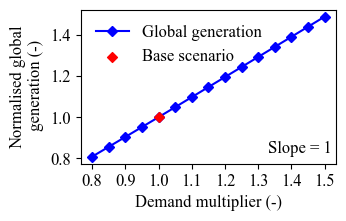

In [62]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
demands = [demand_global[multiple] for multiple in demand_multiples]
gens = [generation_global[multiple]/generation_global[1] for multiple in demand_multiples]
curs = [curtailment_global[multiple] for multiple in demand_multiples]     
plt.figure(figsize=(3.3, 2))
plt.plot(demand_multiples, gens, label='Global generation', color='blue', marker='D', markersize=5)
plt.annotate('Slope = 1', xy=(1.52, 0.83), xytext=(1.52, 0.83), ha='right')
plt.scatter(1.0, gens[4], s=25, color='red', marker='D', zorder=10, label='Base scenario')
#plt.title('Average Hourly Losses Against UTC Time')
plt.xlabel('Demand multiplier (-)')
plt.ylabel('Normalised global\n generation (-)')
plt.xticks(demand_multiples[::2])
plt.legend(frameon=False)
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/global-gen-demand-multiple.svg', format='svg')
plt.show()